# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 24.1 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:00


In [ ]:
import requests
import csv
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import time

# Analytics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ARIMA libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.arima.model
from pmdarima.arima import auto_arima

# LSTM libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from kerastuner.tuners import RandomSearch
from keras.metrics import RootMeanSquaredError
from kerastuner.engine.hyperparameters import HyperParameter
import kerastuner

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


Using TensorFlow backend


<ipython-input-3-29f54fc22c12>:39: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Gathering

## SP500 Tickers

In [ ]:
def save_sp500_tickers():
  # Retrieves S&P 500 table from Wikipedia
  URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  res = requests.get(URL)
  soup = BeautifulSoup(res.content, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})

  # Parses the table to a list of ticker symbols
  sp500tickers = []

  for row in table.findAll('tr')[1:]:
      ticker = row.findAll('td')[0].text.strip()
      sp500tickers.append(ticker)

  # Writing to csv
  filename = "sp500tickers.csv"
  with open(filename, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Ticker'])
      for ticker in sp500tickers:
          writer.writerow([ticker])

  return sp500tickers

In [ ]:
def load_sp500_tickers():
  path = r'https://raw.githubusercontent.com/jakem08/ms2/main/sp500tickers.csv'
  df = pd.read_csv(path)
  ticker_list = df['Ticker'].tolist()

  return ticker_list


## Stock Data

In [ ]:
def save_stock_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  open_df = data.loc[:, 'Open']
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  close_df = data.loc[:, 'Close']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info
  desc_df = pd.DataFrame()
  for ticker in tqdm(tickers):
    stock_data = yf.Ticker(ticker)
    info = pd.DataFrame([stock_data.info])
    info.index = [ticker]
    desc_df = pd.concat([desc_df,info], axis=0)
    time.sleep(.1)

  # save dataframes to csv
  dataframe_list = [open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df]
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df','desc_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df

In [ ]:
def load_stock_data():
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df', 'desc_df']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  open_df = stock_data['open_df']
  high_df = stock_data['high_df']
  low_df = stock_data['low_df']
  close_df = stock_data['close_df']
  adj_close_df = stock_data['adj_close_df']
  volume_df = stock_data['volume_df']
  desc_df = stock_data['desc_df']

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df


# Save or Load Data

Save or Load Tickers

In [ ]:
# sp500tickers_list = save_sp500_tickers()

In [ ]:
sp500tickers_list = load_sp500_tickers()


Save or Load Stock Data

In [ ]:
# open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = save_stock_data(sp500tickers_list, '2013-08-30', '2023-08-30')

In [ ]:
open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = load_stock_data()

# Data Cleaning


In [ ]:
sp500tickers_list = [x for x in sp500tickers_list if x not in ['BF.B','BRK.B','CAT','L']]

In [ ]:
adj_close_df = adj_close_df.drop(['BF.B','BRK.B'], axis=1) #drop BF.B, BRK.B; all NaNs
desc_df = desc_df.drop(['BF.B','BRK.B','CAT','L'], axis=0) #drop BF.B, BRK.B; all NaNs
adj_close_df.tail()

A    AAL        AAPL        ABBV        ABNB  \
Date                                                                         
2023-08-23 00:00:00  119.129997  14.78  181.119995  147.080002  128.130005   
2023-08-24 00:00:00  119.489998  14.57  176.380005  146.630005  124.720001   
2023-08-25 00:00:00  119.680000  14.58  178.610001  146.690002  125.790001   
2023-08-28 00:00:00  119.919998  14.73  180.190002  147.429993  126.154999   
2023-08-29 00:00:00  122.019997  14.90  184.119995  147.589996  132.250000   

                            ABT       ACGL         ACN        ADBE  \
Date                                                                 
2023-08-23 00:00:00  105.129997  75.400002  315.339996  530.710022   
2023-08-24 00:00:00  103.750000  75.410004  314.140015  512.429993   
2023-08-25 00:00:00  104.209999  74.620003  318.760010  525.059998   
2023-08-28 00:00:00  102.790001  74.190002  320.910004  529.919983   
2023-08-29 00:00:00  103.870003  75.750000  323.450012  540.570007   

                            ADI  ...       WYNN        XEL         XOM  \
Date                             ...                                     
2023-08-23 00:00:00  176.640335  ...  96.080002  57.005459  107.150002   
2023-08-24 00:00:00  172.868271  ...  95.489998  56.500019  106.349998   
2023-08-25 00:00:00  177.317123  ...  95.480003  57.064922  108.250000   
2023-08-28 00:00:00  179.476868  ...  96.790001  57.332504  109.160004   
2023-08-29 00:00:00  181.696304  ...  98.070000  57.431610  109.809998   

                          XRAY         XYL         YUM         ZBH  \
Date                                                                 
2023-08-23 00:00:00  37.779999  100.245552  128.796585  114.849998   
2023-08-24 00:00:00  37.240002   99.328522  128.935928  114.320000   
2023-08-25 00:00:00  37.529999  100.843613  129.135010  115.239998   
2023-08-28 00:00:00  37.650002  101.491516  129.309998  117.529999   
2023-08-29 00:00:00  37.790001  101.960007  128.899994  119.230003   

                           ZBRA       ZION         ZTS  
Date                                                    
2023-08-23 00:00:00  270.089996  33.980000  184.250000  
2023-08-24 00:00:00  265.920013  34.470001  181.559998  
2023-08-25 00:00:00  268.390015  34.130001  182.820007  
2023-08-28 00:00:00  269.920013  34.900002  186.979996  
2023-08-29 00:00:00  273.489990  35.439999  192.770004  

[5 rows x 501 columns]

In [ ]:
# split dataset into 5 sections for cross-validation
adj_close_df_f1 = adj_close_df[:int(len(adj_close_df)*0.2)]
adj_close_df_f2 = adj_close_df[int(len(adj_close_df)*0.2):int(len(adj_close_df)*0.4)]
adj_close_df_f3 = adj_close_df[int(len(adj_close_df)*0.4):int(len(adj_close_df)*0.6)]
adj_close_df_f4 = adj_close_df[int(len(adj_close_df)*0.6):int(len(adj_close_df)*0.8)]
adj_close_df_f5 = adj_close_df[int(len(adj_close_df)*0.8):]
cv_dfs = [adj_close_df_f1,adj_close_df_f2,adj_close_df_f3,adj_close_df_f4,adj_close_df_f5]

# Baseline Model: GBM

In [ ]:
# Calculate average GBM price path

def calculate_average_simulation_value(nested_list):
  """Calculates the average simulation value for the stock price for each day.

  Args:
    nested_list: A nested list containing simulations of stock prices.

  Returns:
    A list of the average simulation values for the stock price for each day.
  """

  # Create a NumPy array of the nested list
  array = np.array(nested_list)

  # Calculate the average simulation value for the stock price for each day
  average_simulation_values = np.mean(array, axis=0)

  return average_simulation_values

In [ ]:
# Fold 1 2013 - 2015
adj_close_df1 = adj_close_df.loc['2013-08-30 00:00:00':'2015-08-28 00:00:00']
adj_close_df1 = adj_close_df1.dropna(axis = 1, how = 'all')

ticker_column = []
rmse1_column = []
mape1_column = []

for i in tqdm(range(len(adj_close_df1.columns))):
  stock = adj_close_df1.columns[i]       # select ticker
  data = adj_close_df1.iloc[:,i]         # get prices
  data = data.dropna()                  # drop NaN values for tickers with less than 10 years of price history

  # calculate GBM inputs

  T = len(data)                         # the amount of time data we have
  dt = 1.0 / T                          # this will give equal parts for the time step
  t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
  lr = np.log( data / data.shift(1))    # log returns
  mu = np.cumsum(lr)                    # cumulative sum of the log returns
  sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
  X0 = data[0]                          # stock price at beginning of time series
  Y = []

  # Simulate and plot 1000 iterations of GBM price paths
  for i in range (1001):
    dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
    B = np.cumsum(dB)
    y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
    Y.append(y)

  average_GBM = calculate_average_simulation_value(Y)
  # actual prices vs GBM prices dataframe
  d = {'Actual' : data, 'Average GBM Prices': average_GBM}
  df = pd.DataFrame(data = d)

  # Calculate RMSE
  df = df.dropna()
  rmse = round(sqrt(mean_squared_error(df['Actual'], df['Average GBM Prices'])),2)
  ticker_column.append(stock)
  rmse1_column.append(rmse)

  # Calculate MAPE
  y_true = df['Actual']
  y_pred = df['Average GBM Prices']
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mape1_column.append(mape)


  0%|          | 1/481 [00:03<25:41,  3.21s/it]


KeyboardInterrupt: ignored

In [ ]:
d = {'Ticker': ticker_column, 'RMSE Fold 1': rmse1_column, 'MAPE Fold 1': mape1_column}
gbm_fold1 = pd.DataFrame(data = d)

In [ ]:
# Fold 2 2015 - 2017
adj_close_df2 = adj_close_df.loc['2015-08-31 00:00:00':'2017-08-28 00:00:00']
adj_close_df2 = adj_close_df2.dropna(axis = 1, how = 'all')

ticker2_column = []
rmse2_column = []
mape2_column = []

for i in tqdm(range(len(adj_close_df2.columns))):
  stock = adj_close_df2.columns[i]       # select ticker
  data = adj_close_df2.iloc[:,i]         # get prices
  data = data.dropna()                  # drop NaN values for tickers with less than 10 years of price history

  # calculate GBM inputs

  T = len(data)                         # the amount of time data we have
  dt = 1.0 / T                          # this will give equal parts for the time step
  t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
  lr = np.log( data / data.shift(1))    # log returns
  mu = np.cumsum(lr)                    # cumulative sum of the log returns
  sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
  X0 = data[0]                          # stock price at beginning of time series
  Y = []

  # Simulate and plot 1000 iterations of GBM price paths
  for i in range (1001):
    dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
    B = np.cumsum(dB)
    y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
    Y.append(y)

  average_GBM = calculate_average_simulation_value(Y)
  # actual prices vs GBM prices dataframe
  d = {'Actual' : data, 'Average GBM Prices': average_GBM}
  df = pd.DataFrame(data = d)

  # Calculate RMSE
  df = df.dropna()
  rmse = round(sqrt(mean_squared_error(df['Actual'], df['Average GBM Prices'])),2)
  ticker2_column.append(stock)
  rmse2_column.append(rmse)

  # Calculate MAPE
  y_true = df['Actual']
  y_pred = df['Average GBM Prices']
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mape2_column.append(mape)

100%|██████████| 487/487 [16:45<00:00,  2.06s/it]


In [ ]:
d_fold2 = {'Ticker': ticker2_column, 'RMSE Fold 2': rmse2_column, 'MAPE Fold 2': mape2_column}
gbm_fold2 = pd.DataFrame(data = d_fold2)

In [ ]:
# Fold 3 2017 - 2019
adj_close_df3 = adj_close_df.loc['2017-08-29 00:00:00':'2019-08-28 00:00:00']
adj_close_df3 = adj_close_df3.dropna(axis = 1, how = 'all')

ticker3_column = []
rmse3_column = []
mape3_column = []

for i in tqdm(range(len(adj_close_df3.columns))):
  stock = adj_close_df3.columns[i]       # select ticker
  data = adj_close_df3.iloc[:,i]         # get prices
  data = data.dropna()                  # drop NaN values for tickers with less than 10 years of price history

  # calculate GBM inputs

  T = len(data)                         # the amount of time data we have
  dt = 1.0 / T                          # this will give equal parts for the time step
  t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
  lr = np.log( data / data.shift(1))    # log returns
  mu = np.cumsum(lr)                    # cumulative sum of the log returns
  sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
  X0 = data[0]                          # stock price at beginning of time series
  Y = []

  # Simulate and plot 1000 iterations of GBM price paths
  for i in range (1001):
    dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
    B = np.cumsum(dB)
    y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
    Y.append(y)

  average_GBM = calculate_average_simulation_value(Y)
  # actual prices vs GBM prices dataframe
  d = {'Actual' : data, 'Average GBM Prices': average_GBM}
  df = pd.DataFrame(data = d)

  # Calculate RMSE
  df = df.dropna()
  rmse = round(sqrt(mean_squared_error(df['Actual'], df['Average GBM Prices'])),2)
  ticker3_column.append(stock)
  rmse3_column.append(rmse)

  # Calculate MAPE
  y_true = df['Actual']
  y_pred = df['Average GBM Prices']
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mape3_column.append(mape)

100%|██████████| 494/494 [16:57<00:00,  2.06s/it]


In [ ]:
d_fold3 = {'Ticker': ticker3_column, 'RMSE Fold 3': rmse3_column, 'MAPE Fold 3': mape3_column}
gbm_fold3 = pd.DataFrame(data = d_fold3)

In [ ]:
# Fold 4 2019 - 2021
adj_close_df4 = adj_close_df.loc['2019-08-29 00:00:00':'2021-08-26 00:00:00']
adj_close_df4 = adj_close_df4.dropna(axis = 1, how = 'all')

ticker4_column = []
rmse4_column = []
mape4_column = []

for i in tqdm(range(len(adj_close_df4.columns))):
  stock = adj_close_df4.columns[i]       # select ticker
  data = adj_close_df4.iloc[:,i]         # get prices
  data = data.dropna()                  # drop NaN values for tickers with less than 10 years of price history

  # calculate GBM inputs

  T = len(data)                         # the amount of time data we have
  dt = 1.0 / T                          # this will give equal parts for the time step
  t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
  lr = np.log( data / data.shift(1))    # log returns
  mu = np.cumsum(lr)                    # cumulative sum of the log returns
  sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
  X0 = data[0]                          # stock price at beginning of time series
  Y = []

  # Simulate and plot 1000 iterations of GBM price paths
  for i in range (1001):
    dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
    B = np.cumsum(dB)
    y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
    Y.append(y)

  average_GBM = calculate_average_simulation_value(Y)
  # actual prices vs GBM prices dataframe
  d = {'Actual' : data, 'Average GBM Prices': average_GBM}
  df = pd.DataFrame(data = d)

  # Calculate RMSE
  df = df.dropna()
  rmse = round(sqrt(mean_squared_error(df['Actual'], df['Average GBM Prices'])),2)
  ticker4_column.append(stock)
  rmse4_column.append(rmse)

  # Calculate MAPE
  y_true = df['Actual']
  y_pred = df['Average GBM Prices']
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mape4_column.append(mape)

100%|██████████| 498/498 [17:09<00:00,  2.07s/it]


In [ ]:
d_fold4 = {'Ticker': ticker4_column, 'RMSE Fold 4': rmse4_column, 'MAPE Fold 4': mape4_column}
gbm_fold4 = pd.DataFrame(data = d_fold4)

In [ ]:
# Fold 5 2021 - 2023
adj_close_df5 = adj_close_df.loc['2021-08-27 00:00:00':'2023-08-28 00:00:00']
adj_close_df5 = adj_close_df5.dropna(axis = 1, how = 'all')

ticker5_column = []
rmse5_column = []
mape5_column = []

for i in tqdm(range(len(adj_close_df5.columns))):
  stock = adj_close_df5.columns[i]       # select ticker
  data = adj_close_df5.iloc[:,i]         # get prices
  data = data.dropna()                  # drop NaN values for tickers with less than 10 years of price history

  # calculate GBM inputs

  T = len(data)                         # the amount of time data we have
  dt = 1.0 / T                          # this will give equal parts for the time step
  t = np.arange(dt, 1 + dt, dt)         # Start at dt because Y = X0 at t = 0
  lr = np.log( data / data.shift(1))    # log returns
  mu = np.cumsum(lr)                    # cumulative sum of the log returns
  sigma = [lr[:x].std() for x in range (1, len(lr)+1)] # standard deviation by step
  X0 = data[0]                          # stock price at beginning of time series
  Y = []

  # Simulate and plot 1000 iterations of GBM price paths
  for i in range (1001):
    dB = np.sqrt(dt) * np.random.randn(T) # change in Brownian motion
    B = np.cumsum(dB)
    y = [X0 * np.exp((mu[x] - 0.5 * sigma[x]**2) * t[x] + sigma[x] * B[x]) for x in range(len(mu))]
    Y.append(y)

  average_GBM = calculate_average_simulation_value(Y)
  # actual prices vs GBM prices dataframe
  d = {'Actual' : data, 'Average GBM Prices': average_GBM}
  df = pd.DataFrame(data = d)

  # Calculate RMSE
  df = df.dropna()
  rmse = round(sqrt(mean_squared_error(df['Actual'], df['Average GBM Prices'])),2)
  ticker5_column.append(stock)
  rmse5_column.append(rmse)

  # Calculate MAPE
  y_true = df['Actual']
  y_pred = df['Average GBM Prices']
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mape5_column.append(mape)

100%|██████████| 501/501 [17:19<00:00,  2.07s/it]


In [ ]:
d_fold5 = {'Ticker': ticker5_column, 'RMSE Fold 5': rmse5_column, 'MAPE Fold 5': mape5_column}
gbm_fold5 = pd.DataFrame(data = d_fold5)

In [ ]:
gbm_avg_rmse = np.mean([np.mean(rmse1_column),np.mean(rmse2_column),np.mean(rmse3_column),np.mean(rmse4_column), np.mean(rmse5_column)])
gbm_std_rmse = np.std([np.mean(rmse1_column),np.mean(rmse2_column),np.mean(rmse3_column),np.mean(rmse4_column), np.mean(rmse5_column)])
gbm_avg_mape = np.mean([np.mean(mape1_column),np.mean(mape2_column),np.mean(mape3_column),np.mean(mape4_column),np.mean(mape5_column)])
gbm_std_mape = np.std([np.mean(mape1_column),np.mean(mape2_column),np.mean(mape3_column),np.mean(mape4_column),np.mean(mape5_column)])

In [ ]:
gbm_results = pd.merge(gbm_fold1, gbm_fold2, how = 'outer', on = 'Ticker')
gbm_results = pd.merge(gbm_results, gbm_fold3, how = 'outer', on = 'Ticker')
gbm_results = pd.merge(gbm_results, gbm_fold4, how = 'outer', on = 'Ticker')
gbm_results = pd.merge(gbm_results, gbm_fold5, how = 'outer', on = 'Ticker')
gbm_results['Average RMSE'] = gbm_results.loc[:, ['RMSE Fold 1','RMSE Fold 2','RMSE Fold 3','RMSE Fold 4','RMSE Fold 5',]].mean(axis = 1)
gbm_results['Average MAPE'] = gbm_results.loc[:, ['MAPE Fold 1','MAPE Fold 2','MAPE Fold 3','MAPE Fold 4','MAPE Fold 5',]].mean(axis = 1)

In [ ]:
gbm_output = {'Average RMSE': [gbm_avg_rmse],
              'St. Dev. RMSE': [gbm_std_rmse],
              'Average MAPE': [gbm_avg_mape],
              'St. Dev. MAPE': [gbm_std_mape]}
gbm_output_df = pd.DataFrame(data = gbm_output)
gbm_output_df

Average RMSE  St. Dev. RMSE  Average MAPE  St. Dev. MAPE
0     10.614327       4.275184      0.082926       0.007781

In [ ]:
gbm_result = gbm_results[['Ticker', 'Average RMSE', 'Average MAPE']].copy()
gbm_result

Ticker  Average RMSE  Average MAPE
0        A         8.092         0.084
1      AAL         4.820         0.152
2     AAPL         7.814         0.088
3     ABBV         9.310         0.100
4      ABT         4.862         0.066
..     ...           ...           ...
496    OGN         1.745         0.050
497   OTIS         7.780         0.105
498    CEG        17.490         0.200
499   GEHC         7.960         0.090
500   KVUE         0.680         0.020

[501 rows x 3 columns]

In [ ]:
gbm_result.to_csv('gbm_results.csv')

# S1: ARIMA


In [ ]:
# create a function to calculate returns
def calc_return(df, lag=1):

    prevClose = [x for x in df[ticker_symbol][:-lag]]
    prevClose = [np.nan for i in range(lag)] + prevClose
    df[f'{lag}-day prevClose'] = prevClose
    df['return'] = np.log(df[ticker_symbol] / df[f'{lag}-day prevClose']).shift(1)

    return df

In [ ]:
# empty lists to store results
arima_tickers = []
arima_avg_rmse = []
arima_std_rmse = []
arima_avg_mape = []
arima_std_mape = []
model_order = [] ##

# 5 folds, all tickers

# for ticker in tqdm(range(5)):
for ticker in tqdm(range(len(sp500tickers_list))):
  ticker_symbol = adj_close_df.columns[ticker]
  arima_tickers.append(ticker_symbol)
  print(ticker_symbol)

  rmse_5fold = []
  mape_5fold = []
  model_order_5fold = []  ##

  for i in cv_dfs:
    df = pd.DataFrame(data = i.iloc[:,ticker])
    df = df.dropna()
    print(ticker_symbol)


    if len(df) > 0:

          # scale data
      scaler = MinMaxScaler(feature_range = (0,1))
      df = scaler.fit_transform(df)
      df = pd.DataFrame(data = df)
      df.columns = [ticker_symbol]

      # are prices stationary?

      dftest = sm.tsa.adfuller(df, autolag='AIC')
      dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
      for key, value in dftest[4].items():
          dfoutput['Critical Value ({0})'.format(key)] = value

      # if prices are stationary:
      if dftest[1] < 0.05:

        train_data, test_data = df[0:30], df[30:31]
        train_data = train_data.replace([np.inf, -np.inf], 1)
        test_data = test_data.replace([np.inf, -np.inf], 1)

        # search for optimal pq
        model = auto_arima(train_data, start_p=1, start_q=1,
                            test='adf',
                            max_p=9, max_q=9,
                            d=0,    # because prices are stationary
                            seasonal=False,
                            start_P=0,
                            D=None,
                            trace=True,
                            suppress_warnings=True,
                            stepwise=True)

        # fit the model based on optimal hyperparameters from above test
        model = statsmodels.tsa.arima.model.ARIMA(train_data, order=(model.order[0], model.order[1], model.order[2]))
        fitted = model.fit()

        # create predictions
        fc= fitted.forecast(len(test_data))
        fc.index = test_data.index

        # Calculate accuracy
        order=(model.order[0], model.order[1], model.order[2]) ##
        rmse = round(sqrt(mean_squared_error(test_data, fc)),3)
        mape = round(mean_absolute_percentage_error(test_data, fc),3)
        model_order_5fold.append(order)  ##
        rmse_5fold.append(rmse)
        mape_5fold.append(mape)

      # if prices are not stationary:
      if dftest[1] > 0.05:
        return_df = calc_return(df, lag=1)

        # train test split
        df = return_df['return'].dropna()

        train_data, test_data = df[0:30], df[30:31]
        train_data = train_data.replace([np.inf, -np.inf], 1)
        test_data = test_data.replace([np.inf, -np.inf], 1)
        # search for optimal pq
        model = auto_arima(train_data, start_p=1, start_q=1,
                            test='adf',
                            max_p=9, max_q=9,
                            d=1,
                            seasonal=False,
                            start_P=0,
                            D=None,
                            trace=True,
                            suppress_warnings=True,
                            stepwise=True)

        # fit the model based on optimal hyperparameters from above test
        model = statsmodels.tsa.arima.model.ARIMA(train_data, order=(model.order[0], model.order[1], model.order[2]))
        fitted = model.fit()

        # create predictions
        fc= fitted.forecast(len(test_data))
        fc.index = test_data.index

        # Calculate accuracy
        order=(model.order[0], model.order[1], model.order[2]) ##
        rmse = round(sqrt(mean_squared_error(test_data, fc)),3)
        mape = round(mean_absolute_percentage_error(test_data, fc),3)
        rmse_5fold.append(rmse)
        mape_5fold.append(mape)
        model_order_5fold.append(order)  ##


  arima_avg_rmse.append(np.mean(rmse_5fold))
  arima_std_rmse.append(np.std(rmse_5fold))
  arima_avg_mape.append(np.mean(mape_5fold))
  arima_std_mape.append(np.std(mape_5fold))
  model_order.append(model_order_5fold[-1])

  0%|          | 0/499 [00:00<?, ?it/s]

A
A
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-104.675, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3.858, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-99.825, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-104.246, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-105.078, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-102.515, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-102.436, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-104.532, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.168 seconds
A
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.058, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.657, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.085, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.018, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=57.158, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.022, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.668, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.165, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53.618, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.619, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49.894, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=51.633, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.141, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.876, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23.478, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.104, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.272, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.750, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.833 seconds
A


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.901, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.291, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.895, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
A
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.805, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.239, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.669, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.283, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.019, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-84.065, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89.771, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-91.476, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.077, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-88.079, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.764 seconds
AAL
AAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.284, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.172, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.046, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.664, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.784, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.870, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-63.206, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.140, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.590, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.514, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.135, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.842, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.528, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.799, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-65.201, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-64.498, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
AAL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.821, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.811, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.821, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.018, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.448, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-83.276, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-96.439, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-86.320, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-95.403, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-92.170, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-86.366, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-102.486, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.258, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.790, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.256, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-100.566, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.266, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-102.462, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.298, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.218, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-106.134, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-104.188, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.789, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-70.136, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.807, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.467, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.243, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-69.794, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.393, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-67.465, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.106, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.793, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-71

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.385 seconds
AAPL
AAPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.023, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.568, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.042, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.838, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.023, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.042, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.582 seconds
AAPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.783, Time=0.02 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.827, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.686, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.688, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-39.753, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-40.933, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.622, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.816, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-41.690, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-42.916, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.224 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AAPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.031, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.297, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.030, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.071, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.297, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17.070, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.754 seconds
AAPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.289, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.089, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.662, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20.806, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19.419, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21.406, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.990 seconds
AAPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.794, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.580, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.738, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.592, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.507, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.520, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.985 seconds
ABBV
ABBV


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predi

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.488, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.680, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.503, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.725, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.952, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.164 seconds
ABBV


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.933, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.855, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.833, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3.357, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.816, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.926, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.345, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.532, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.566, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.528, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds
ABBV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.549, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.316, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.665, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
ABBV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=143.294, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=123.584, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141.294, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=112.649, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=108.286, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=110.230, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=106.323, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=110.655, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=108.263, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=106.360, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=104

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=106.742, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.049 seconds
ABNB
ABNB
ABNB
ABNB
ABNB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.202, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.761, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.240, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=47.280, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.924, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=45.412, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.647 seconds
ABNB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.327, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.725, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.294, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.517, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.690, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-81.484, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.599, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-92.392, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-91.793, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-87.792, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-90

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ABT
ABT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.805, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.647, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.828, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
ABT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.017, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.667, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.027, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.843, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2.540, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.148, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.671, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=0.565, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.097

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.213, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.362, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.436, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23.172, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.658, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24.972, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.454, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.708, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.995, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=24.460, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.391, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.333, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25.662, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.546 seconds
ABT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.533, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.141, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.528, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
ABT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.006, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.417, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.870, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.340 seconds
ACGL
ACGL


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.196, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.574, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.199, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.827, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.575, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.832, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.699 seconds
ACGL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.995, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.400, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.032, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.955, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.268, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21.303, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.910, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.394, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-23.213, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-23.245, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Tot

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.634, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.452, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.628, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.292, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.432, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.265, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.825 seconds
ACGL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-123.932, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.903, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-125.918, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
ACGL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=106.599, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.858, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=104.603, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=98.420, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=99.561, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=96.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=97.860, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=97.562, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=94.481, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=92.627, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=94.511, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.891 seconds
ACN
ACN


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.858, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.350, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.670, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.891, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52.217, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49.813, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=50.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.360, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.699 seconds
ACN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.402, Time=0.07 sec
 ARIMA(0,1,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.981, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.864, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25.831, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27.827, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=27.825, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=25.207, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.394, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=27.183, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=27.177, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=25.846, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.890 seconds
ACN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.015, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.310, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.051, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
ACN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.684, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.819, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.675, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
ACN


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-78.694, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.503, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.907, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.601, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-83.141, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-84.705, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.531, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.409, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-85.392, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.808, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-82.150, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-85.225, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.778 seconds
ADBE
ADBE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.332, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.635, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.413, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.528, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49.885, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.170, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.209, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48.651, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=48.635,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.783, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.464, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19.936, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21.511, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20.503, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=17.962, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.846, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=19.530, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18.505, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.213, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.536, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33.857, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33.801, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.617, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.945, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.216, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.548, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31.861, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=31.806, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32.590, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.618, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.617, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.487, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.634, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.000, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=29.397, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=30.002, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=27.428, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.059, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=28.030, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.904, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.880, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.152, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-111.406, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-113.193, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-114.944, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-113.088, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-111.280, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-116.937, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-108.127, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-115.084, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-115.191, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ADI
ADI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.781, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.646, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.288 seconds
ADI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.081, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.272, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.120, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.307, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2.376, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2.425, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.304, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.294, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4.371, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4.419, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.565, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.674, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.895, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.798, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=27.171, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.613 seconds
ADI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.422, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.812, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.406, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.484, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.548, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-58.862, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-61.783, Time=0.17 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-62.536, Time=0.28 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-61.535, Time=0.33 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-58.363, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-58.020, Time=0.21 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-58.797, Time=0.33 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=-63.140, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-63.136, Time=0.11 sec
 ARIMA(7,1,0)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

ADI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.756, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.437, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.614, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.748, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-53.724, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-59.562, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.430, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-55.578, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.756 seconds
ADM
ADM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.162, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.519, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.406, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=37.789, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.882, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.550, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=36.254, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.870, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.075, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.439, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.105, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.133, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-72.138, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-73.212, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-76.044, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.027, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-74.065, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-74.068, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-75.943, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-74.126, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.027 seconds
ADM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.917, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.895, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.916, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.223, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.907, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.172, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.763, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.880, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-43.346, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45.276, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-43

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.243, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.642, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
ADM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.402, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.618, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78.414, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=67.193, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.190, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=65.256, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=68.641, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=66.256, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ADP
ADP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.544, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72.151, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78.428, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=73.987, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75.245, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=70.360, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=72.242, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.553, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=73.364, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.539 seconds
ADP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.915, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.274, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.052, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.287, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.539, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=32.074, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=31.885, Time=0.15 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=33.885, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=33.886, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33.076, Time=0.13 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=35.358, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=31.526, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=31.321, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=31.4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.428, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.022, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.988, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.239, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28.567, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27.417, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26.354, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=27.043, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=29.043, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=25.464, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.052, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.499, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.435, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=26.383, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.647, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.259, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.637, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
ADP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.792, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.252, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.794, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=93.288, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=90.258, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=91.291, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.668 seconds
ADSK
ADSK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.576, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.824, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
ADSK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.514, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.682, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.538, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.070, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39.933, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.135, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.704, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.016, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-35.806, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.019, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.708, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-37.777, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.987, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-35.814, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-33.856, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39.759, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-37.794, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-37.803, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.631, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-35.846, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.548 seconds
ADSK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.107, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.168, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.159, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17.364, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16.461, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13.169, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12.123, Time=0.10 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=13.625, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=13.959, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12.980, Time=0.17 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=15.980, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=10.453, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=11.271, Time=0.05 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=11.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.871, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.756, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.871, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.827, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-93.757, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-99.133, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-98.259, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-97.155, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-97.159, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-98.691, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-94.966, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-100.465, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AEE
AEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.231, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.226, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.374, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.249 seconds
AEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.177, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.285, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.321, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
AEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.183, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.032, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.183, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.611, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-43.409, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-44.714, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-43.137, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-45.067, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-43.317, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-43.597, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-45.354, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

AEE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.055, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.209, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.465, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.822, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.207, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.349, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.878 seconds
AEE


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-98.770, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24.758, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7.213, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-96.776, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-96.784, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-99.638, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-66.703, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-100.770, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-43.655, Time=0.02 sec


  3%|▎         | 14/499 [01:08<45:28,  5.63s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-99.523, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-97.508, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.907 seconds
AEP
AEP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.231, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.409, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.328, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.371, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.527, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.514, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.671 seconds
AEP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.658, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.256, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.913, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
AEP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-59.762, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.627, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.346, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.341, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.614, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-59.790, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-57.742, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-61.681, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-60.975, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.240, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-58.736, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.957 seconds
AEP
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-149.048, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-146.489, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-147.957, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-149.376, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-146.559, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-147.344, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-147.285, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-147.183

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.572, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.350, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.387, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.583, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.502 seconds
AES
AES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.772, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.751, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.763, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.784, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.712, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.718, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.779 seconds
AES
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.951, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.562, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.196, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.537, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-25.134, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-26.948, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.667, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23.255, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-28.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-30.710, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-28.877, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.149, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-26.886, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.013 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AES
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.886, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.499, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.827, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.380 seconds
AES


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.571, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.760, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.570, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.348 seconds
AES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.658, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.196, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.153, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.196, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.255, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.145, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-76.251, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.656, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.993, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.789 seconds
AFL
AFL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-74.773, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38.822, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-74.011, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-73.673, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-15.434, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-74.366, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-72.031, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-74.318, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.725 seconds
AFL
Performing stepwise search t

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.005, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.136, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.872, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.402, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42.101, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39.886, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=60.050, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=40.450, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=40.169, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.466, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.669, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.470, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
AFL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.672, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.415, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-141.080, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.666, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-140.058, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-142.387, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-130.411, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-141.589, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.984 seconds
AFL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.323, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.324, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54.257, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=50.699, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=52.262, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.620 seconds
AIG
AIG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.785, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.191, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.252 seconds
AIG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.212, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.799, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.166, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.480, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-46.188, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-48.801, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-46.714, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-46.268, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-48.469, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-44.516, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-44.963, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-49.026, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.707, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.288, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.707, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.442, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-116.612, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-118.885, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-109.825, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-121.326, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-114.351, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-117.025, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-118.393, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-119.380, Time=0.36 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-114.341, Time=0.26 sec
 ARIMA(5,1,2)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-123.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.627, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-133.575, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-125.352, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-132.787, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-131.048, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-134.635, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-133.045, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-133.629, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.586, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-131.640, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.782 seconds
AIG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.571, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.695, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.512, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.828, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.628, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.763, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.815 seconds
AIZ
AIZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.052, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
AIZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.669, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.038, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30.677, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.557, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-29.035, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.470 seconds
AIZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.646, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.265, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.647, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19.294, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16.266, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=17.296, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.680 seconds
AIZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.343, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
AIZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-114.156, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.073, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.350, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-115.106, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.072, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-112.942, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-116.924, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.831, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-115.430, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-115.321, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-114.679, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.660 seconds
AJG
AJG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-97.905, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3.165, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-99.555, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28.735, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-97.923, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-96.654, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-98.953, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.434 seconds
AJG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53.619, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.877, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.026, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53.819, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.822, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-54.909, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.378, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-54.385, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.978, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.783 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AJG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.724, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=96.662, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.734, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=92.455, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=93.335, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=90.530, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=94.707, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=91.391, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=84.623, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=82.642, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.504, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.743, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.475, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
AJG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.287, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.732, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
AKAM
AKAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.663, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.026, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
AKAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.472, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.201, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.195, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-96.513, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-96.117, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-97.508, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-98.719, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-96.688, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-97.817, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-96.147, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-100.421, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-99.306, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-99.319, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.745, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.351, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.821, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.391, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=47.860, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=49.537, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=46.090, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49.699, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=47.772, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AKAM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.503, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.472, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.354 seconds
AKAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.198, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.659, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.193, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.931, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.733, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-107.552, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-99.628, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-105.034, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-103.515, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-103.147, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-101.481, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-102.335, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-107.439, Time=0.10 sec

Best model:  ARIMA(3,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ALB
ALB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.170, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.281, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.141, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.202, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-108.878, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-114.032, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-110.958, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-111.257, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-112.130, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-109.829, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.365 seconds
ALB
Performing stepwise searc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.606, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=106.255, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.629, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103.983, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=104.384, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=102.024, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=104.290, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=102.442, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.695, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.613, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.689, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.206, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-104.604, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-104.179, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-109.832, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-111.014, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-109.758, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.921 seconds
ALB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.627, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.574, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.608, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds
ALB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.108, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.127, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.106, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
ALGN
ALGN
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-107.944, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15.060, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-109.094, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-46.170, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-108.239, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-108.349, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
ALGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.827, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.805, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51.497, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=51.805, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.949 seconds
ALGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37.707, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.245, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.920, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.452, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.517, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.451, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.720, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34.916, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.576, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=36.772, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.869, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.582 seconds
ALGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.376, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.374, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.804, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-53.851, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-52.072, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-54.971, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53.107, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-51.786, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-54.644, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-51.377, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-54.201, Time=0.11 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.646 seconds
ALGN
Performing stepw

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-123.550, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-124.397, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-125.519, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.329 seconds
ALK
ALK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.987, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.677, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.108, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
ALK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.206, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.897, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.152, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.989, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.619, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-46.840, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-46.524, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-45.023, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-47.034, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-48.734, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-50.904, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90.982, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=73.060, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-89.017, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-88.537, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-94.547, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-71.281, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-95.568, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-50.070, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-94.754, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-92.990, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-120.477, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.782, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-132.151, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-122.423, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-130.271, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-128.158, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-134.042, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-132.058, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-132.078, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.716, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-130.140, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.721 seconds
ALK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.718, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.721, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.717, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.453, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.359, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.811, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.768, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-65.582, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.237 seconds
ALL
ALL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.396, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.212, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.803, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.332, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22.218, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23.754, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.057, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.036, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19.853, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.247, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.890, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.358, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.870, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=84.254, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=80.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=86.911, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=82.272, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=76.077, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=77.471, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.874, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.174, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.095, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.872, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.093, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.796 seconds
ALL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.249, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.983, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.243, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
ALL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.719, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.693, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.636, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.998, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-85.902, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.882, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.591, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-87.781, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.134 seconds
ALLE
ALLE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.305, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.500, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.313, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.202 seconds
ALLE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.139, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.304, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.149, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.031, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7.689, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5.032, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9.305, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5.690, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-81.254, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.847, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.739, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.721, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-79.263, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-79.245, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-80.672, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.906, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-78.335, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.927 seconds
ALLE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.565, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.022, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.565, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
ALLE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.351, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.814, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.023, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-87.932, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-90.128, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-88.522, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-89.219, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-92.362, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-93.291, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.919, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-89.702, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-91.856, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.419 seconds
AMAT
AMAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.735, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.593, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.054, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.884, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.226, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=36.543, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=35.032, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=37.023, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=36.988,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.681, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.427, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.627, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.681, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.372, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.430, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.376, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.357, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.628, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.608 seconds
AMAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.475, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.407, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.441, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
AMAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.888, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.240, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.887, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.399, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.329, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57.478, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-55.501, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-54.707, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-59.240, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.516, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.399, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AMAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.282, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.514, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.752, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.072, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.081, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-77.507, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.056, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.555 seconds
AMCR
AMCR


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.321, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.153, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.321, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.512, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5.921, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2.529, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.153, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4.010, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2.630, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.632, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.293, Time=0.02 sec
 ARIMA(0,1,2)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.468, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.534, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.468, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.725, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.414, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-68.951, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.238, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-69.238, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-71.212, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.199, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1248.323, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-90.387, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.484, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.550, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.484, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.740, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.619, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-93.611, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-91.617, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.550, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.820, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.903, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.108, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-81.154, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-86.360, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-84.052, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-84.301, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-86.122, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.255 seconds
AMCR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-63.672, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.557, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.611, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.546, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.686, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-67.495, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.573, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-65.558, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.655 seconds
AMD
AMD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.001, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.981, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.289, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.912, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-98.600, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-98.402, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-99.868, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.056, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-101.615, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-99.937, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.218, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-99.931, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-101.615, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-96.973, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.234, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.109, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=63.095, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.219, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.139, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=59.143, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=58.509, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=61.125, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.461 seconds
AMD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.947, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.701, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.089, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.864, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-42.005, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.011 seconds
AMD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71.945, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.445, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.683, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=88.604, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=63.984, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.212, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63.954, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=65.973, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61.047, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=80.888, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.887, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.917, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=71.042, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=62.255, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.660 seconds
AMD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.053, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.644, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.673, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.686, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.541, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-92.880, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.580, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-92.023, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-90.937, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-95.158, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.288, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.051, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-95.256, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.790 seconds
AME
AME
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-114.936, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19.925, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-116.870, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-49.735, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-114.930, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-116.885, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-73.594, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.197, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.191, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-94.219, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.025, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.464, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.988, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.532, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-43.553, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-43.559, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-47.529, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.450, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-45.550, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-45.556, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-43.498, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AME
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.946, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.110, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.107, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.239, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.305, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29.994, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31.990, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31.983, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=33.129, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30.346, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.979 seconds
AME
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.079, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.383, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.073, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
AME


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.065, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.025, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.277, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.006, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.264, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.906 seconds
AMGN
AMGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.176, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.324, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.201, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
AMGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.792, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.439, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.897, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.793, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.898, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.187, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.440, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=40.933, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.657 seconds
AMGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.940, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.408, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds
AMGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.962, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.052, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11.941, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.989, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9.977, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.113, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1.151, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.117, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.680 seconds
AMGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.882, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.941, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.786, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.760, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23.642, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.410, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-25.236, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-25.115, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24.446, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-24.003, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-23.115, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.887 seconds
AMP
AMP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.978, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.993, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.549, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.081, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.845, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11.675, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.919, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.564, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.909, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-71.184, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.004, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-72.099, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-72.244, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-70.381, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-75.997, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-73.182, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-74.095, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-74.132, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.291, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.348, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.554, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.857, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.614, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-91.687, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-90.030, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-88.497, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-89.386, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-89.864, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

AMP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-81.118, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.496, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-80.757, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.870, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-79.586, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.657, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-77.597, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-82.404, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.756, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-82.628, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.409, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-80.628, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.644, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.346, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.906, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.592, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-28.643, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.338, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.433 seconds
AMT
AMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.670, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.515, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.997, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
AMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.156, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.984, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.218, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2.837, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.997, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4.725, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.781, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.162, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=0.837, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=0.997, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.498, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2.726, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.831, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.144, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.831, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.593, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.207, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.449, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.216, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.596, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=54.460, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.518, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.543, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.514, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.495, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-43.982, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-44.934, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-43.007, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-47.409, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.501, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-45.890, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-46.842, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-44.909, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.996, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-101.655, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.629, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.468, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-104.915, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-102.987, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.356, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-105.358, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.358, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-103.440, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-103.418, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.776 seconds
AMZN
AMZN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.625, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.530, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.140, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.130, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.218 seconds
AMZN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.461, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.724, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.341, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36.027, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.422, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.500, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=34.105, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.965 seconds
AMZN
Performing stepwise search to minimize a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.257, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.623, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.267, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.027, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.129, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71.936, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=72.567, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=69.945, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.149, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=70.571, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.085, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.706, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.107, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21.215, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.962, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10.429, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9.228, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13.121, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6.982, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19.270, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=8.502, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=7.466, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=11.247, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AMZN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-119.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.748, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-125.610, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-121.504, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-125.810, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-124.004, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-124.795, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.680, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-125.933, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-124.753, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.162, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.423 seconds
ANET
ANET
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.901, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.990, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.888, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59.208, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.067, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60.761, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=58.470, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.099, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=59.903, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.793, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.343, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.044, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.672, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-27.188, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.036, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.241 seconds
ANET
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=116.058, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.068, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.116, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=107.330, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=107.892, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=105.410, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=106.137, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=105.966, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.887, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.838, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.777, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.354 seconds
ANET


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=101.596, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=133.482, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=118.671, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=131.482, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=112.420, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.830 seconds
ANSS
ANSS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.740, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.268, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.731, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
ANSS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11.040, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.413, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.140, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.462, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.909, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.900, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11.902, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15.875, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.139, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13.878, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13.886, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13.008, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=96.399, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.359, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=94.879, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=93.844, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=95.832, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=91.844, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=92.880, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=93.832, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.620, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.816, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.713, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
ANSS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.882, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.788, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-108.551, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.064, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-106.913, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-110.289, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-100.777, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.001 seconds
AON
AON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.260, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.659, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.292, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.584, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.676, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.602, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=56.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=58.716, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=58.226, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=57.449, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.769, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.965, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.489, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.173, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.813, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2.198, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-0.849, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.696, Time=0.08 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.754, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.801, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.753, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.600, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.516, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.563, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24.779, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-33.454, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-42.042, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40.736, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-40.069, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.396, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.209, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.396, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
AON
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.033, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.544, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.032, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.899, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51.544, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.899, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.792 seconds
AOS
AOS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.092, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.771, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.916, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.479, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.777, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.811, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14.590, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.175, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16.568, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AOS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.152, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.239, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.249, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.350, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=45.291, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44.581, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.448, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.258, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=43.402, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=42.798, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best mo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.894, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-127.502, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.304 seconds
AOS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.311, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.186, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-65.623, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.254, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-62.832, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-67.474, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.020, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.808 seconds
AOS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-69.006, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.983, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.081, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.979, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.732, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-66.082, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.066, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-70.710, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-70.981, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.940, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.695 seconds
APA
APA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-147.927, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-136.424, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-139.563, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-149.449, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-138.340, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-148.919, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-147.395, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-152.829, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-150.829, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-150.827, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-141.483, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-149.274, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.904 seconds
APA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.844, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.475, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.852, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17.714, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19.707, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19.705, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15.716, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.479, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=17.708, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17.706, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.396, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

APA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-90.402, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.344, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92.250, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.521, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-90.407, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.481, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.703, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.716, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.193, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.397, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.853 seconds
APA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.855, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.144, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.812, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.926, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-73.774, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-75.965, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-73.972, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.981, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.915, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-73.306, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

APA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120.931, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.307, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=118.941, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=108.415, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=106.343, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=106.448, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
APD
APD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.332, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.834, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.390, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.064, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.079, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.325, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

APD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.670, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.803, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.642, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.367, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.411, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21.417, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-22.016, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-25.360, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19.796, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-23.407, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-23.413, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24.467, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.750, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.751, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=76.100, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=73.244, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.101, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
APD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.911, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.873, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.909, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.437, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-39.455, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-39.932, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-38.079, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-40.052, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-38.966, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-40.922, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41.957, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.928, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.002, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.383, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
APH
APH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.113, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.162, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.133, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.746, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=79.987, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=76.806, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=87.169, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=78.126, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.582, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.953, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.631, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.810, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23.004, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22.927, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-25.807, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.940, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-25.003, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24.927, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.117 seconds
APH
Performing stepwise search to m

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.805, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.057, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.809, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.836, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-38.019, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-40.879, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-41.796, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-38.195, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-39.837, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-39.163, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-39.794, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-37.494, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

APH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.813, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.439, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.793, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.337 seconds
APH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53.505, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.825, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.992, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.809, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.105, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.979, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55.088, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-55.480, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.783 seconds
APTV
APTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.777, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.037, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.891, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.288 seconds
APTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.875, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.895, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.843, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.243, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.243, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36.244, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.216, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-37.869, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-38.216, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-38.216, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

APTV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.285, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.186, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.284, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds
APTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-105.781, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.697, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-101.281, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.618, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-103.817, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-103.289, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-105.793, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.071 seconds
APTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-89.564, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.780, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.477, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.778, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.444, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.890 seconds
ARE
ARE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.701, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.116, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.803, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.936, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.117, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.948, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=54.652, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52.858, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=54.701, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.655 seconds
ARE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.424, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.063, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.010, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-47.499, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-47.348, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-50.903, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.298, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-49.335, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-49.196, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.747, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.844, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.750, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.060, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15.197, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15.323, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15.046, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.007, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.135, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-17.145, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17.275, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.946, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.165, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-112.588, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.941, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-119.200, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-117.960, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.900 seconds
ARE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.156, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.171, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.148, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-116.265, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-114.765, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-116.675, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-115.628, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-114.974, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-116.951, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.638, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-120.605, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-118.863, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.816 seconds
ATO
ATO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.956, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45.686, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.222, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
ATO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.953, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.606, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
ATO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.282, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.275, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.118, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-38.101, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-41.725, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-40.533, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-42.654, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-43.647, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-40.149, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-44

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.387, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.315, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.665, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.313, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.548, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.603, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.495, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-110.251, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-106.316, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.950 seconds
ATO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.069, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.082, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.202, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=35.190, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35.112, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.839, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=33.229, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=33.149, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32.447, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.865 seconds
ATVI
ATVI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.503, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.622, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.790, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
ATVI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.733, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.552, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=45.956, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.702, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=39.750, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39.634, Time=0.10 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=41.416, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=41.464, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=39.816, Time=0.15 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=42.833, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=39.276, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=38.853, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.282, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.604, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.550, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-94.756, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.521, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-94.630, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.560, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.750, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-94.852, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.447, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.007 seconds
ATVI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.606, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.303, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.076, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.175, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=41.159, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=42.481, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.925, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.544, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=40.157, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.451, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41.460, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.403 seconds
ATVI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.426, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.886, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.426, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.615, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.882, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.610, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.758 seconds
AVB
AVB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.559, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.235, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.132, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1.141, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.080, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.556, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.090, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.988, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.310, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.065, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.377, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=61.896, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.435, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.366, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=59.925, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.160, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=54.878, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=56.160, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=54.824, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-84.679, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.870, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.364, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.827, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-77.318, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-82.389, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.905, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.893, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.917, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-75.330, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-84.561, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-140.785, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-131.352, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.597, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-133.341, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-135.459, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-139.763, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-136.543, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-137.717, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.053 seconds
AVB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.250, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.221, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.232, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-89.466, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-88.103, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-90.929, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-89.535, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-86.716, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.589 seconds
AVGO
AVGO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.857, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.786, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.947, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.242 seconds
AVGO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.225, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.403, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.531, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.314, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.302, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40.296, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.770, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.762, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.762, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=38.757, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.333, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.866, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53.722, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.333, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55.683, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.854, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.912 seconds
AVGO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-89.538, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.618, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.740, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-91.521, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.575, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-89.680, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.588 seconds
AVGO


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.714, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.709, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.944, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-30.502, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.941, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.674 seconds
AVY
AVY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.324, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.559, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.379, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.998, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=46.814, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.152, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.636, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=44.944, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.976 seconds
AVY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.447, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.292, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=80.403, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.549, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=78.415, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=78.467, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=78.563, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.881 seconds
AVY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.616, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.603, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.608, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
AVY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.326, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.739, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.312, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.098, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.360, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.032, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-83.894, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-85.580, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.858, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-85.644, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-84.492, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.211, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.430, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.988, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.427, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-86.455, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-86.610, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-87.747, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.881, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.781, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-90.499, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.860, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-83.427, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

AWK
AWK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.946, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.938, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=67.824, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.947, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.214 seconds
AWK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.190, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=105.971, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.200, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=91.915, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=92.813, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=90.171, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=104.017, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=91.009, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.897 seconds
AWK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.890, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.661, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.407, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-30.969, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-29.103, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-30.940, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-32.744, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29.264, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-30.859, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.132, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.758, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.089, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.047, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.168, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-83.546, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-85.963, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.659, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-84.092, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-86.518, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.456, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-89.480, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.306, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.225, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.406, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.150, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.750, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-83.471, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.334, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.840, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.300, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.124 seconds
AXON
AXON


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.322, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.263, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
AXON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.120, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.721, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.110, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.252, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-51.325, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.727, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-51.746, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-51.972, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55.294, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-55.217, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.063, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.347, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22.511, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19.064, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=20.511, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.648 seconds
AXON
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.571, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.565, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.672, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.313 seconds
AXON
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.775, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.717, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.772, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.746, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-88.941, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-87.123, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-90.038, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-89.219, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-89.625, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-87.912, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-87.163, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

AXP
AXP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.029, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.327, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.153, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.113, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.455, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.747, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49.434, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=44.145, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.168, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=44.396, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=46.092, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.205, Time=0.04 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-88.721, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.623, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.517, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.154, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.564, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-86.742, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-84.940, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.735, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.140, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-88.719, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.472, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-86.911, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.882 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AXP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.664, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.362, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.609, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.673, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.620, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.594 seconds
AXP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.721, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.833, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.366 seconds
AXP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.413, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.287, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.391, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.310, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.265, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.286, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-48.090, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-49.960, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-48.044, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-51.676, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

AZO
AZO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.781, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.392, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.782, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.010, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.837, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=67.495, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=63.929, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=68.033, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=65.598, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AZO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.735, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.709, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.734, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.280, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.691, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-89.257, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.718 seconds
AZO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.912, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.328, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.908, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=43.733, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=40.198, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=40.064, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35.862, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=34.031, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=35.893, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=37.663, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.886 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

AZO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.355, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.042, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.327, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.570, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.678, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-84.658, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-82.258, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-82.426, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-82.647, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-80.272, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.617, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.648, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.621, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.016, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.154, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=53.154, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=54.326, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=51.192, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.155, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=52.406, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=51.237, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.828 seconds
BA
BA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.572, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.033, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.983, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.963, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6.599, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.360, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.485, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.431, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=8.266, Time=0.05 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-52.981, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.863, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.114, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-52.533, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.807, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-61.970, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.388, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.183, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60.554, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.387, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-48.098, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.183, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-63.970, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.963, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-62.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.470, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.819, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.470, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.480, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.822, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.483, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.138, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.592, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.690 seconds
BA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-136.564, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-123.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.742, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-125.504, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-135.974, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-136.505, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-129.440, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-133.058, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-138.136, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-140.133, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-138.137, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-128.721, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.623, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.747, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-102.128, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.607, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.290, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-103.230, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-103.324, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-103.203, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.076, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-106.040, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.336, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-106.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-104.171, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.834 seconds
BAC
BAC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.571, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.787, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.235, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.571, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.236, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.714, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=48.944, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.656 seconds
BAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.584, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.716, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.199, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.612, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-75.218, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76.570, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-75.180, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-73.488, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-79.228, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-74.724, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-77.224, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-77.136, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.571, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-75.571, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-114.176, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9.950, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-115.805, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-114.190, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-115.477, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.419 seconds
BAC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.302, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.296, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.357, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-87.448, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-88.641, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-86.650, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-86.539, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-87.887, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-84.641, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-90.640, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89.812, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-90.265, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.819, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.031, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.814, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.052, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.023, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.043, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-82.386, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-84.318, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-82.367, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-83.685, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.726 seconds
BALL
BALL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.460, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.716, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.490, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.217 seconds
BALL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.953, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.153, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.500, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=67.025, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.955, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=65.029, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-81.271, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.491, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.164, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.242, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-79.449, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.112, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-77.274, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.870, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-83.831, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-81.877, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-77.755, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-79.834, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.885, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.191, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.883, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.821, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.445, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.461, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-67.466, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-65.464, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

BALL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-144.549, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-143.886, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-145.707, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-146.401, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
BAX
BAX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.602, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.323, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.609, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.251 seconds
BAX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.415, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.348, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.845, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=57.812, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=57.569, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=53.845, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.348, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.812, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=55.570, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52.596, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=50.916, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=52.703,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.441, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.170, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.075, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.544, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=58.084, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=57.038, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=57.826, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.790, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.613, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=57.614, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=57.509, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=56.711, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=59.254, Time=0.06 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BAX
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90.632, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.462, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-82.365, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-92.085, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-90.810, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-88.651, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-97.589, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-99.110, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-101.066, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-94.844, Time=0.02 se

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.725, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-119.258, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-122.959, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.447, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-119.929, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-122.619, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.568 seconds
BBWI
BBWI


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.444, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.343, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.403, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.624, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-20.988, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.623, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19.323, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-22.986, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-25.656, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-27.237, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-29.237, Time=0.04 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.266, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-120.177, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-125.656, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.265, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-121.847, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-127.282, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-125.476, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-122.159, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.895 seconds
BBWI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.368, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.230, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.757, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-73.763, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-75.734, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-78.487, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-80.316, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-74.873, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-79.009, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-79.233, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-78.551, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-74.172, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

BBWI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.907, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.071, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.850, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.665, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.796, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.592, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-67.960, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-67.751, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-70.858, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.858, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-74.607, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-72.865, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.758, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.667, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.782, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.641, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-103.064, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-104.215, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-104.717, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.280, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102.451, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.917 seconds
BBY
BBY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.881, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.098, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.861, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds
BBY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.594, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.670, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.345, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.346, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.587, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-74.640, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.230, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.408, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.301, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.338 seconds
BBY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.957, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.416, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.959, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
BBY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.961, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.250, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.879, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
BBY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.326, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.466, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.322, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.519, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-88.445, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.483, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.048, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.295, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-96.046, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.869 seconds
BDX
BDX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.580, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.595, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.773, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.859, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23.204, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.348, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.517, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23.639, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=23.489, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=25.462, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.691 seconds
BDX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.660, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.941, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.698, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.461, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.393, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=55.260, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=51.500, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.975, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.429, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53.294, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.816, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BDX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.487, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.148, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.500, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.813, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.123, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.106, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.124, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.816, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=54.107, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.145, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.005, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-98.296, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-100.550, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-106.645, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-97.256, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-108.489, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-82.853, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-106.573, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-104.499, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] int

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.486, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.178, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.301, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.362, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.703, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.702, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-33.545, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-35.545, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-33.545, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.774 seconds
BEN
BEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.409, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.915, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.399, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.663, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.513, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-52.662, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51.892, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-51.513, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56.366, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.348, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-60.348, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.756, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.701, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-59.531, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.269, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-59.677, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-57.942, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.224, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.754, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-61.634, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-61.486, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-59.263, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-59.899, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.923 seconds
BEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.865, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.552, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.861, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.244, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-94.293, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.604, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-97.279, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-99.766, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-95.930, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-97.217, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-97.940, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-96.046, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-99.220, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.728, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.681, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.154, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.637, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.194, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-93.227, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.340, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.712, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.544, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-95.749, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.204 seconds
BEN
Performing stepwise searc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.945, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.494, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.032, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.945, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.032, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.854, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.730 seconds
BG
BG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.148, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.120, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.105, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.333, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.083, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.302, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.775 seconds
BG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.349, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.347, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.281, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.278, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-90.590, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.942, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.053, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.054, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.885 seconds
BG


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.554, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.993, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.710, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.554, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.537 seconds
BG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.035, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-115.042, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.035, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-116.298, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-114.306, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-116.600, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-114.405, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-117.577, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-119.321, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-120.930, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.089, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=82.273, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=80.162, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=78.421, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=80.257, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.777 seconds
BIIB
BIIB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.803, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.077, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.958, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
BIIB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-64.592, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.211, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-67.320, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-67.045, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-66.265, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-67.349, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-69.057, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-59.564, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-66.469, Tim

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.162, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.355, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-87.448, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-85.165, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.584, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.775, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-88.908, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.481, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-86.590, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.713 seconds
BIIB
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-154.471, Time=0.08 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-73.877, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-156.466, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-101.474, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-154.471, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-152.470, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-156.052, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
BIIB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.256, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.025, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.255, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.324, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-85.593, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-88.711, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-87.084, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-84.067, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-84.936, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-89.032, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-90

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.909, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.025, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-90.909, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.943 seconds
BIO
BIO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.501, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.311, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.495, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
BIO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.880, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.317, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.818, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.224, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17.423, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21.215, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.295, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-19.410, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total f

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BIO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.208, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.903, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.221, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.666, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.929, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.708, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=54.869, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52.872, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=54.869, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=56.789, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.639 seconds
BIO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.294, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.008, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.810, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.318, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53.202, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=55.993, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=52.134, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.761, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49.762, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=51.759, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.286, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.245, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-118.112, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-116.224, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-117.957, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.008 seconds
BK
BK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.035, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.042, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.962, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=57.554, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.092, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=59.533, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61.159, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=55.568, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=57.546, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=57.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=60.067, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=59.164, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.440 seconds
BK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.973, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.084, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.708, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.945, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-41.931, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41.491, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38.892, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-43.924, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.615, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.892, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-71.867, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-71.897, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-72.214, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-74.965, Time=0.19 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-76.900, Time=0.24 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-74.959, Time=0.44 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-68.692, Time=0.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-76.301, Time=0.23 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-73.009, Time=0.49 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=-77.757, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.167, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.230, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.170, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.150, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.228, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-83.990, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.016, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.125, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.128, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.814, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.124, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-83.844, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.576 seconds
BK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-67.559, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.640, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.552, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.629, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.554, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.462, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.463, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.465, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-72.637, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-71.126, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-72.722, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-71.150, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-71.255, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BKNG
BKNG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-108.736, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-25.868, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-109.772, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-56.673, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-108.372, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-107.329, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-109.486, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.351 seconds
BKNG


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.252, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.662, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.198, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.643, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.660, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-54.206, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.546, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.603, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-54.561, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-59.141, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.552, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.731, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.551, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.719, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.641, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.613, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.893 seconds
BKNG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.999, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-119.859, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.086, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-117.955, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-116.222, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-121.416, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-119.800, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.971, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-117.928, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.744 seconds
BKNG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.134, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.464, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.122, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.328 seconds
BKR
BKR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9.626, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.906, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.998, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.828, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.322, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9.297, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10.336, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6.948, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8.757, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BKR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.653, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.662, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.643, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.819, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.900, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.888, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-54.817, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-50.660, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-52.899, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-52.887, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.699, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.901, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.000, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-114.686, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.889, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.725, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.977, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.564 seconds
BKR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.680, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.802, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.656, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.153, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.782, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-83.136, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.764, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.713, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-88.764, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.796 seconds
BKR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.787, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.371, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.896, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.389, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.066, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.784, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.844, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.885, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.214 seconds
BLK
BLK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.163, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.144, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.200, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.217 seconds
BLK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.589, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.799, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.645, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.310, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.291, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.279, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.823, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.291, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.279, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.296, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.410, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.236 seconds
BLK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.634, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.807, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.541, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.371, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.797, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63.792, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-63.702, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-62.085, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.690, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.119, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-65.747, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-64.625, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.697, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.377, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-108.487, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.697, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-110.273, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.934, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-106.373, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.779 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BMY
BMY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.055, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.143, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.078, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.866, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62.912, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=63.290, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=61.649, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59.681, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=61.624, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=62.293, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=59.444, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=68.123, Time=0.04 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.792, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.205, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.780, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.459, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.483, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-27.657, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.414, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.196, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-29.443, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-29.630, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.965, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.739, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.125, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.928, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-83.083, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.790 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BMY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.597, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.502, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.664, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
BMY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.214, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.795, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.100, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-46.385, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-44.806, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-45.569, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-43.360, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-47.753, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-42.681, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-46.129, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-46.856, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.502 seconds
BR
BR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.209, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.962, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.322, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.704, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
BR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.046, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.565, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29.482, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31.357, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=27.540, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.099, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=29.428, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=28.253, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit t

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.439, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.913, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.057, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.799, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.381, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8.324, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10.290, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6.126, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.948, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.855, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.041, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9.790, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.649 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.635, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.170, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.339, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.578, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
BR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.680, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.460, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
BRO
BRO


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-43.136, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.503, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.088, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.397, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.130, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41.130, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.904, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.940, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.946, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-42.940, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.548 seconds
BRO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.940, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.998, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.897, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.122, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-20.583, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20.525, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.122, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-11.988, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-22.582, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-22.525, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BRO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18.502, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.122, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.795, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.934, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.350, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18.360, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21.650, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17.850, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.010, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.532, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21.513, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=16.291, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=21.429, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=17.593, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=18.479, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.967, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.947, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.954, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.329, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.425, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-22.367, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-24.410, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.329, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-24.335, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.904, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.910, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.905, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.701, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12.917, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13.711, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.424, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.652, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7.981, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BSX
BSX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.268, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.974, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.397, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.115, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.484, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.122, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5.173, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.572, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.439, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.297, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1.173, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.545 seconds
BSX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.597, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.497, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.380, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.665, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61.938, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=63.843, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=59.944, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.389, Time=0.02 sec
 ARIMA(3,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.729, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.054, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.726, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.510, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-68.917, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.309, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.166, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-72.156, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.953, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-70.492, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-70.743, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.431, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-69.257, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.005, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.361, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.002, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.012, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.916, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-69.492, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-73.642, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-71.201, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-71.195, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-70.458, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-73.503, Time=0.12 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BSX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.590, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.365, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.505, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
BWA
BWA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.791, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.538, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.790, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
BWA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.380, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.087, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.380, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.441, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.081, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.434, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.779 seconds
BWA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.547, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-101.802, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.507, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.238, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-107.290, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.360, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-107.758, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-110.783, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-103.604, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-108.846, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-108.918, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.122, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.777, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BWA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.284, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.099, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.098, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.144, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.965, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.238, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-83.367, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.971, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-87.223, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.897, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-85.307, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.762 seconds
BWA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.263, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.124, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.411, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.218, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.319, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-60.811, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-62.719, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-63.500, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-62.684, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-60.915, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-61.547, Time=0.07 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BX
BX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.657, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.958, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.778, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.986, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=35.646, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=32.353, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=20.862, Time=0.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=22.698, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=21.441, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24.029, Time=0.13 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=23.177, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=21.488, Time=0.10 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.851, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.301, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.826, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-33.959, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.975, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-31.986, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-35.952, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.279, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-33.970, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-33.982, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.657, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.640, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds
BX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.451, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.494, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.442, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.493, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-63.941, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-61.945, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-61.945, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-59.943, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.000 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.425, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.119, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.216, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.108, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-72.895, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-70.935, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-70.938, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-68.895, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-73.550, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-72.800, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-73.263, Time=0.04

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-71.596, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-71.497, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.581, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-69.196, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.742 seconds
BXP
BXP


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.034, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.385, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.058, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12.745, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14.034, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.400, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10.785, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12.084, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.646 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

BXP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.350, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.078, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.447, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.106, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=57.785, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.129, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.124, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.788, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=52.851, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.693, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.641, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.268, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.640, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.173, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.067, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29.155, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21.265, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-28.058, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-110.715, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-117.469, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-112.710, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-121.577, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-120.422, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-127.941, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-125.953, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-125.507, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-126.316, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-123.981, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-128.838, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-123.577, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-119.955, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.421, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.083, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-120.084, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-119.839, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-117.589, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-121.212, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-120.375, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-118.687, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.393 seconds
C
C
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.961, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.636, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.993, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.286 seconds
C
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-79.698, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.352, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.731, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.255, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.704, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-78.188, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.832, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.999, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.204, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.507, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.642, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.991, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-78.447, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.927, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.806, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.906, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.242, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.775, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-89.193, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.859 seconds
C
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-101.018, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.741, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.730, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-99.231, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.337, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-97.267, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-102.797, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-104.758, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.804, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.071, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.062 seconds
C
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.521, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.719, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.580, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.519, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.813, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.107, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.570 seconds
CAG
CAG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.462, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.026, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6.226, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-4.941, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8.187, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8.019, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-6.892, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-11.647, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13.203, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.128, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.289, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
CAG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.374, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.500, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-112.158, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.310, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.262, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.678, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-110.838, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-109.005, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.172, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-113.259, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-112.436, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-105.497, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-111.474, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.909 seconds

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.110, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.767, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.104, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.213, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.367, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-25.915, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-27.336, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-29.364, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.203, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-27.908, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-28.962, Time=0.08 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.936, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.764, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.919, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.293, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.422, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-26.109, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21.748, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-24.211, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.124 seconds
CAH
CAH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.015, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.254, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.222, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.229, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.449, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.211 seconds
CAH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.204, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.459, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.149, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.046, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-43.085, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-43.706, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-44.738, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-46.897, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.391, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-44.944, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-45.597, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-101.624, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.743, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.099, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.743, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-100.831, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.010, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-101.640, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-100.751, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-98.916, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.603, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-104.597, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-93.099, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-101.168, Time=0.08 sec

Best model:  ARIMA(0,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-123.010, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-122.743, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-121.200, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-121.114, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-122.775, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.700 seconds
CAH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.959, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.263, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.957, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.415, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.199, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.334, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38.340, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-34.673, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37.539, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-41.529, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-36.297, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-39.761, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.716 seconds
CARR
CARR
CARR
CARR
CARR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58.601, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.583, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.917, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.669, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.673, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=58.547, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=60.388, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=55.803, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=57.778, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=57.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.108, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=59.580, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.354 seconds
CARR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.847, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.595, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.847, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.182, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-84.684, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.514, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-85.647, Time=0.22 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-84.871, Time=0.30 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-86.647, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-88.571, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.027, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-87.743, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CAT
CAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.560, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40.968, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.550, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-39.761, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-42.967, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.002, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-41.677, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.728 seconds
CAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.950, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.247, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.136, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.946, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14.124, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.247, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.793 seconds
CAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.888, Time=0.02 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.117, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.266, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.656, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27.069, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=14.289, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=14.523, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22.831, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12.849, Time=0.24 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=15.443, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=15.155, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=16.184, Time=0.19 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=16.785, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=14.316,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CAT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60.998, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.095, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.621, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.921, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.013, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-61.023, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-59.046, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-64.710, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.862, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.893, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.370, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-60.902, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
CAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.933, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.873, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-33.227, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.926, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-35.224, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.737 seconds
CB
CB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.523, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.455, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.662, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.151, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34.597, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.269, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.269, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27.508, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.219, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.468, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.662, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.990, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107.680, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.663, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.862, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=81.327, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.137, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.892, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=79.649, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.270, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.494, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.268, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18.885, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22.487, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-20.877, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.789 seconds
CB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.413, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-101.658, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.409, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.068, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-109.517, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-111.437, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-112.101, Time=0.19 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-111.849, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-114.165, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-114.492, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-117.163, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-117.510, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-117.387, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=103.428, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.828, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=101.429, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=84.929, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=79.894, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=75.766, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=73.858, Time=0.10 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=75.584, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=75.733, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=75.485, Time=0.08 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=77.813, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=73.799, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=74.887, Time=0.03 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CBOE
CBOE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=121.870, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=114.915, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120.098, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=110.419, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=110.319, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=110.093, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=111.455, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=108.189, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=108.465, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=109.509, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.779, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.687, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.789, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.258, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11.300, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15.136, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.659, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13.178, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17.528, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-19.453, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-18.971, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-17.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.264, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.431, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.263, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.737, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.286, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-66.287, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-64.408, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-61.930, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-65.857, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CBOE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.466, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.491, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.451, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.565, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.492, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.418, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-81.905, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-81.864, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.726, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.757, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.726, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.595, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.509, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.588, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-39.757, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-43.494, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.145 seconds
CBRE
CBRE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.209, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.272, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.329, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.847, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52.710, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.410, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.431, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.948, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=51.279, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.882, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.194, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.848, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.941, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.255, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62.201, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60.152, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-60.102, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-61.609, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-59.211, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-58.180, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18.501, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.523, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.506, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.504, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.896, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.185 seconds
CBRE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.408, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.906, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.385, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
CBRE


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.877, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.247, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.079, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.795, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-97.614, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-93.662, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.209, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-98.668, Time=0.09 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CCI
CCI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.531, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.880, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.551, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=68.027, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.880, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=66.033, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.754 seconds
CCI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63.533, Time=0.07 sec
 ARIMA(0,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.111, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.362, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=65.135, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=63.140, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=65.112, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=61.148, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=61.305, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=63.144, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=63.136, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61.615, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.852 seconds
CCI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91.785, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.981, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.786, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
CCI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.552, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.867, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.513, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-40.773, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-40.814, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-42.780, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-40.882, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-40.926, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-42.330, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-38.780, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-38.921, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CCI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-113.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.993, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-115.084, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-120.719, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-119.384, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-120.271, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-118.272, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-122.177, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-118.822, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-120.901, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-121.745, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-122.332, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-122.337, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-121.341, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.286 seconds
CCL
CCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.300, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.968, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.304, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
CCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.245, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.603, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.225, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.849, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.599, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.848, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.595, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.598, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-26.233, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.241, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.724, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.240, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.742, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.904, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-72.945, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-75.529, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-77.312, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-71.546, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-79.149, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-77.862, Time=0.15 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-77.056, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-77.300, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.821, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.105, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-115.784, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.928, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-113.789, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-111.994, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-117.722, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.793, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-114.222, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-111.082, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-113.938, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.742 seconds
CCL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.164, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.224, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.143, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.327, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.195, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.222, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-107.325, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-108.395, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-109.174, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.823 seconds
CDAY
CDAY
CDAY
CDAY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.081, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.162, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.533, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.673, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22.023, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.008, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.621, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21.116, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.949, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.007, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.949, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.395 seconds
CDAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.128, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58.686, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.109, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-56.918, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-59.031, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.276, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-58.561, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-47.452, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-56.561, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.776 seconds
CDAY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-114.803, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-108.937, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.034, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-110.899, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.077, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-114.868, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-116.753, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-117.989, Time=0.30 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-119.114, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-116.249, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CDNS
CDNS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.215, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.344, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.287, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
CDNS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.720, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.424, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.417, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13.694, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17.404, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12.705, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-15.675, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.198, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.443, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.182, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
CDNS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.254, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.026, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.244, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.312 seconds
CDNS
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.010, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.920, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.999, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.969, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.867, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29.917, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38.071, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39.784, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-38.049, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-37.800, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.801 seconds
CDW
CDW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.515, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.622, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.820, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-0.835, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-0.851, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4.367, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.219, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2.393, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2.416, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.770, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.453, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6.919, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CDW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.676, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.457, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.546, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.809, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.517, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-37.124, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-34.264, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-34.738, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-36.548, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-34.983, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CDW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.712, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.864, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.359, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.739, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.231 seconds
CDW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.270, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.844, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.268, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.529, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.267, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.534, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-65.404, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-65.142, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-66.969, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-64.830, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-64.479, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.191, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.150, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.158, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.656, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45.068, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.582, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-51.306, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-50.388, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-49.712, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-50.826, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-48.828, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.896 seconds
CE
CE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.765, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.701, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.788, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
CE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.036, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.493, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50.649, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.091, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52.546, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=54.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=48.672, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=50.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49.528, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=52.672, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.458 seconds
CE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51.787, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.422, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-51.329, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.288, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-50.986, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-53.006, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-50.683, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-54.416, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-53.307, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-52.449, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-52.827, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-53.418, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-119.981, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111.874, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.828, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-121.951, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-113.849, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-119.999, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-117.976, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-123.835, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-121.897, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-121.917, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-118.757, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-119.841, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.750 seconds
CE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-98.763, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.123, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.846, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.117, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.851, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-98.457, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.914 seconds
CEG
CEG
CEG
CEG
CEG
CEG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.664, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predi

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.567, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.146, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.222 seconds
CF
CF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.410, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.324, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.559, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32.761, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=33.557, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31.169, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.606, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.154, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.540, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.117, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.072, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.563, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-85.091, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-86.952, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.067, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.127, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.273, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-84.950, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-88.944, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.549, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.466, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.140, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50.414, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50.573, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52.790, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.573, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=52.301, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=50.495, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.641 seconds
CF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.369, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.250, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-116.073, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.303, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-116.193, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-115.873, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-114.272, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.859 seconds
CF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.326, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.707, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.588, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.764, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.412, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.589, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.414, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.387, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53.592, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=42.397, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=43.047, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=43.396, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41.738, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=50.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=45.154, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.311 seconds
CFG
CFG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.039, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78.029, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.040, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=76.764, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=76.548, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=77.258, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=74.549, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.764, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=75.258, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.254, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.277, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.189, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.919, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.750, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-52.113, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-54.723, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.892, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-54.098, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-46.288, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.323, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.624, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.317, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.899, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-49.623, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-47.896, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-48.283, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.770 seconds
CFG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.889, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.976, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.879, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.621, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-100.366, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-102.574, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-100.750, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-101.273, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-103.130, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-103.870, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-101.363, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.765, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-81.125, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.887, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.661, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.876, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.713, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.641, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-82.694, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-83.114, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-85.300, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-83.553, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-87.658, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CHD
CHD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=48.697, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.344, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50.304, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.739, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50.089, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.286, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46.742, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=48.309, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.370, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=48.129, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CHD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.358, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.953, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.285, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.882, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11.266, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14.832, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.876, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13.208, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-19.944, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21.448, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-21.209, Time=0.04 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.592, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.871, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
CHD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.258, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.418, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.349, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.198, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-69.334, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.564, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.343, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-69.101, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-69.212, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-70.551, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-68.925, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-67.224, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.145, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.702, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.197, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.577, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.127, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.101, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.527, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-72.455, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.500 seconds
CHRW
CHRW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56.683, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.154, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.510, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58.637, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.151, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-54.690, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-60.411, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.539, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-58.632, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.502, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-57.839, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.725 seconds
CHRW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.281, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.394, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.256, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.083, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.827, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-21.854, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-23.991, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-22.008, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-21.786, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-20.099, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.665 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CHRW
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-37.364, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-114.799, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-113.019, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-115.086, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-77.637, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-113.205, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-113.308, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-113.346, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.897 seconds
CHRW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.464, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.775, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.917, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-68.565, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-67.474, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-70.275, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-67.793, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-70.232, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-66.250, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-116.533, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-67.324, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-118.221, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-116.566, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-114.553, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-122.689, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-109.242, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-123.212, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-123.693, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-122.373, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-121.976, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-122.855, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-120.751, Time=0.15 sec


 19%|█▊        | 93/499 [08:09<41:11,  6.09s/it]

 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-114.593, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.957 seconds
CHTR
CHTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.439, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.429, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.297, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.813, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.364, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-27.417, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-27.878, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29.878, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-27.878, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28.774, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-26.332, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-31.307, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-30.183, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.684, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.726, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.704, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
CHTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.018, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.799, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.918, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-97.410, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.786, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-99.273, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.866, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.855 seconds
CHTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.541, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.507, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.707, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.604, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-41.534, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.761 seconds
CHTR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.891, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.642, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-124.134, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-128.059, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.586, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-124.849, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.915, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.467 seconds
CI
CI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.283, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.860, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.302, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.622, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2.199, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.368, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.887, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=0.204, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.995

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.764, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.188, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.835, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35.412, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.704, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.758, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37.320, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.615 seconds
CI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-88.626, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.268, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.836, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.267, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-87.223, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-89.013, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-87.301, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-85.959, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.634, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-88.806, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-88.859, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.172, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-87.530, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.529, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.834, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
CI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.211, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.243, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.541, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.245, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.055, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.536, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.048, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.204, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.585 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CINF
CINF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.359, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.600, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.372, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.493, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20.761, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.132, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21.317, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.811, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.910, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.672 seconds
CINF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.929, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.635, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.629, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.838, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30.163, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28.500, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28.547, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.315 seconds
CINF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.723, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.708, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.722, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.033, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.706, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.031, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.809 seconds
CINF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-122.667, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-122.222, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-124.667, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.385 seconds
CINF


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-70.929, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.421, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.852, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.421, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.913, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-74.849, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-72.912, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.928, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.349, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.529, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.240, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.813 seconds
CL
CL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-107.471, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-31.786, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-109.400, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-60.857, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-107.477, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-109.566, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-76.265, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-107.568, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-107.568, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-95.153, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] int

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99.460, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=97.485, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.012, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=69.371, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71.256, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=67.582, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=76.320, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=69.478, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.884, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.752, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.649, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
CL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.745, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.920, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.742, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds
CL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-105.660, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.184, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-103.980, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-104.271, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-102.447, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-108.653, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-93.537, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-109.856, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-75.623, Time=0.02 sec


 19%|█▉        | 97/499 [08:25<30:56,  4.62s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-108.500, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-106.709, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.965 seconds
CLX
CLX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.417, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.254, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.399, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=87.357, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=84.511, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=85.121, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=84.302, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=86.232, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=82.752, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.904, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.950, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.713, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=60.080, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60.424, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62.018, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=60.782, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=58.612, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=58.947, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=60.551, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.612, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.757, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.595, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.595, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.089, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.566, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.722, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-38.061, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.236, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.590, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.237, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.629, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.104, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=50.886, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=50.581, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=51.389, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=47.198, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=49.263, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=46.917, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CLX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.253, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.863, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.145, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
CMA
CMA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.850, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.552, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.851, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.361, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.653, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=73.715, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.772, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=72.381, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=72.039, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=69.544, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-61.625, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.525, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.195, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.469, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.976, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58.279, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.793, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51.160, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-61.942, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-63.475

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.090, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.459, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.091, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.032, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2.459, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4.032, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.737 seconds
CMA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.527, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.639, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.938, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.614, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-109.666, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-111.552, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-108.193, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.219, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-111.222, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-113.209, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-110.731, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CMA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-102.347, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.821, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.310, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.802, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-102.438, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-108.974, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-108.332, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,5)(0,0,0)[0]             : AIC=-107.350, Time=0.31 sec

Best model:  ARIMA(0,1,4)(0,0,0)[0]          
Total fit time: 3.299 seconds
CMCSA
CMCSA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.295, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.165, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
CMCSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.522, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.713, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.972, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=44.971, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44.949, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=40.985, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.561, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=42.985, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=42.963, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.021, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.125, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.991, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.540, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-55.498, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.749, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-53.647, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-51.783, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.222 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CMCSA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-89.110, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.866, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.905, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-90.898, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.802, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-87.903, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.814, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.842, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.936, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.795, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.664, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.017 seconds
CMCSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.832, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.465, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.822, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.109, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.359, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-89.609, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.752, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-87.747, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.351, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.026 seconds
CME
CME


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.660, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.766, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.726, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.116, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48.716, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=49.028, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=46.791, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.213, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=47.126, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.240, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.515, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.243, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16.383, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15.743, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=14.345, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=16.060, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=14.316, Time=0.25 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=16.115, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(6,1,0)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CME
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.219, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.233, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.232, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.396, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.286, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.435, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=45.892, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=47.427, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=45.503, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=46.439, Time=0.04 sec
 ARIMA(1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.632, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.093, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.594, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
CME
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.844, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.231, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.843, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.245, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.227, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.242, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.730, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-33.178, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-31.561, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-29.183, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.786 seconds
CMG
CMG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.778, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.077, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.513, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.984, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27.659, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.387, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.191, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=33.450, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=31.129, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
CMG


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-114.558, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-122.842, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-116.552, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-129.002, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-127.038, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-132.387, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-130.293, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-131.464, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-129.369, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-129.635, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.225 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CMG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.061, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.257, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.056, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.408, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.512, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.397, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.256, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-33.507, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.001, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.173, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.573, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.248, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-89.510, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.989, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-88.175, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-91.090, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-89.380, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-89.559, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CMG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.698, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.959, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.652, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.999, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-100.330, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-102.382, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-101.052, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-99.719, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-100.912, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-99.296, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-99.940, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-99.640, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-104.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-100.733, Time=0.17 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.583 seconds
CMI
CMI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.765, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.994, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.754, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.613, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18.850, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-17.424, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-19.293, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17.272, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-16.797, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-17.615, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.536, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-15.951, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-21.136, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.450, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.409, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.445, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.529, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.560, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60.556, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.482, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.394, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-62.516, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.512, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.165, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.415, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-106.308, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.745, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.001, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.335, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.903, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.738 seconds
CMI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.081, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.290, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.228, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.204, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.646, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-79.006, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.404, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.104, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.845 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CMI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-46.413, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.550, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.271, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.545, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.302, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-50.271, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.302, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-48.413, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.643 seconds
CMS
CMS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.902, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.913, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=85.188, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=87.187, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=87.187, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=83.327, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=89.308, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=85.326, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=85.325, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.713 seconds
CMS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.628, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.627, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=61.468, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61.198, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.349, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.819, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=60.222, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=60.229, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=57.034, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=59.689, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=58.880, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=56.860, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=58.265, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.188, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.570, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.164, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.518, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.998, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-56.807, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-54.847, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-55.182, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-57.875, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58.145, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-55.622, Time=0.17 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CMS
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-113.606, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.021, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-111.634, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-112.380, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-109.973, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-120.391, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-106.335, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-120.368, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-118.770, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-118.584, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-82.217, 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.286, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.631, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.234, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.466, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.524, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.204, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.538, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-33.210, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.125 seconds
CNC
CNC


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.599, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.905, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.561, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.297 seconds
CNC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.124, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.330, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.133, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
CNC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.385, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.394, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.258, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.125, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.045, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=55.802, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53.821, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=55.805, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=57.631, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.617 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CNC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=126.748, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=116.598, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=124.748, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=108.912, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=108.709, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=97.282, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=98.708, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=98.524, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=100.184, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=95.406, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=106.811, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=96.835, Time=0.07

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.355, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.725, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.644, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=52.561, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=45.400, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=44.968, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=46.734, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=45.480, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=44.606, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=46.577, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=47.579, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=42.611,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=45.537, Time=0.23 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 2.413 seconds
CNP
CNP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.260, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.047, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.253, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.885, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-57.939, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.839, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.042, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-59.874, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.504, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.100, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.572, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.692, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10.349, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.308, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10.611, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.599, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.990, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12.234, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12.193, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.355, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-11.897, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.395, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.425, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.092, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.355, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.466 seconds
CNP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-128.141, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-115.188, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.892, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-127.976, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.921, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.047 seconds
CNP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.133, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.763, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.134, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.831, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75.939, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=77.348, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.940, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.832, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=75.348, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.260 seconds
COF
COF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21.762, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.370, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.606, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.029, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.628, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21.153, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.260, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21.059, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.504, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=24.055, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.579 seconds
COF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.807, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.377, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.720, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.128, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.862, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-55.361, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53.253, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-52.854, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-54.620, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-50.905, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-51.326, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-47.820, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.446, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.595, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-47.013, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.417, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-49.570, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.441, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47.631, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-47.631, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-48

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

COF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-108.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.743, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-116.061, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-110.356, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-114.095, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-118.060, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-116.849, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-117.209, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-111.661, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-115.483, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.781 seconds
COF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-90.232, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.913, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.108, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-90.596, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.834, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-89.478, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-93.148, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-90.443, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-88.182, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.462, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.641, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.471, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

COO
COO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.741, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.368, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
COO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.764, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.511, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.749, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.303, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.303, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35.302, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.303, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.490, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.303, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37.309, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.236, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.219, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.248, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13.961, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.219, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11.963, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.739 seconds
COO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.973, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.185, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.662, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.283 seconds
COO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-107.496, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.588, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.448, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.534, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.462, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-112.835, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-116.420, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-107.780, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-114.412, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-114.407, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-111.784, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-113.713, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-116.352, Time=0.12 sec

Best model:  ARIMA(3,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

COP
COP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.746, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.621, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.969, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-127.127, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.615, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-128.818, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.876, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-118.950, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.867 seconds
COP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.487, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.739, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.460, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.879, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.100, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59.753, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-61.870, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.725, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-60.087, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.353, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-65.582, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

COP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.000, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.535, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.848, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.811, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.074, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.076, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.508, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.582, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7.554, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5.241, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5.691, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.629 seconds
COP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.624, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.744, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.168, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-95.800, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-94.130, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-94.078, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.031, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-91.930, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-97.780, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.144, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-96.107, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-96.057, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-96.024, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.312, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.365, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.318, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.308, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52.405, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.344, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.655 seconds
COR
COR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.985, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.312, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.357, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.178, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4.629, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.537, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.047, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5.737, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4.420, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.16 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.978, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-94.478, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.715, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-92.478, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.552, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-96.464, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.465, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-94.466, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-91.943, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.548, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.657 seconds
COR
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-96.103, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8.987, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-97.730, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-21.582, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-96.070, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-95.262, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-103.115, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-88.197, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-101.358, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-101.320, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-98.765, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-99.545, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.590 seconds
COR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.154, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.968, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.484, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.677, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-20.754, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-21.937, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-24.619, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.484, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-22.713, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.179, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.681, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.734, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.083, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.179, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.209, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.668 seconds
COST
COST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.301, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.787, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.660, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34.445, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=36.275, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33.443, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=37.295, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31.653, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30.529, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.416, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=103.851, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.626, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=101.874, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81.253, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70.666, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=70.412, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=70.174, Time=0.09 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=70.829, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=68.174, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=68.412, Time=0.05 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=68.829, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.814, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.276, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.864, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
COST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.136, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.238, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.139, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.504, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=37.608, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.532, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.254, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=35.636, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.344, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.394, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.530, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.330, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.494, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7.537, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10.109, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-10.069, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16.180, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14.947, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12.468, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.283 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CPB
CPB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.370, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.283, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.373, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.201, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.541, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.982, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-0.716, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-6.253, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.174, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.655, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.048, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.959, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.906, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21.367, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23.367, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.848, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.223, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.808, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=22.799, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.079, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=24.845, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.440, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.923, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.440, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.018, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.933, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59.105, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-56.798, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-56.938, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-53.141, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CPB
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93.202, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21.098, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-91.273, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-91.885, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-93.148, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-92.900, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-93.726, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-80.510, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-95.470, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-66.979, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-93.627, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-91.471, Time=

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.805, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.586, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21.598, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18.692, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.806, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=19.775, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14.722, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=16.718, Time=0.06 sec
 ARIMA(2,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=17.293, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.288 seconds
CPRT
CPRT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-56.738, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19.514, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-57.658, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12.257, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-56.636, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-55.463, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-61.634, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-42.175, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-63.455, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-62.227, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-62.319, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-62.347, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] int

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.981, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.728, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.036, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=47.904, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.745, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=45.917, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40.968, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.696 seconds
CPRT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.548, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.588, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.383, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26.883, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23.542, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=24.735, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24.573, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26.400, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24.996, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=22.209, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=25.589, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=23.440, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=23.323, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=25.076, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.070, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.442, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.064, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.622, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.027, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-62.746, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-64.017, Time=0.16 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-62.861, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-62.878, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-64.192, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-61.933, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.686, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CPRT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.125, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.117, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.372, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.357, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57.359, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.728 seconds
CPT
CPT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.680, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.429, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.603, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
CPT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107.898, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.175, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=102.112, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=103.436, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=100.117, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=105.902, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=101.471, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.381, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.062, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-73.788, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.358, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-72.770, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.448, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.035, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.279, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-69.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-74.154, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.787 seconds
CPT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-141.292, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-127.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-132.443, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-129.349, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-139.238, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-132.741, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.986 seconds
CPT


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.533, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.419, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.513, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.887, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-96.026, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-98.130, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-96.337, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-94.818, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-99.903, Time=0.12 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CRL
CRL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.374, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.583, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.228 seconds
CRL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=101.745, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.796, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.746, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=84.271, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=86.222, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=82.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=84.798, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=84.265, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.921 seconds
CRL


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.899, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.291, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.898, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.993, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.658, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-40.010, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-39.906, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-39.897, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-38.762, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-43.653, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.993, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-42.000, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-41.897, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.654, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.408, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.629, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
CRL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.076, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.353, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.056, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-94.678, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.302, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-96.634, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.805 seconds
CRM
CRM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.230, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.614, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
CRM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.359, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.214, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.264, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.647, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.690, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-41.558, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40.117, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-39.597, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-46.381, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.733, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.131, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.736, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=76.593, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=77.836, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=85.145, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.888, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.552, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.139, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.513, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.740, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.371, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-48.653, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52.043, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-50.116, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-50.962, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-49.201, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.555 seconds
CRM
Performing stepwise searc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.569, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.291, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.561, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.337 seconds
CSCO
CSCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.782, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.143, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.778, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
CSCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.547, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.276, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.489, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.869, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.209, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-25.869, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.250, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-24.208, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-25.497, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-26.591, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-26.185, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.509, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.766, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.566, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.555, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.915, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.714, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.622 seconds
CSCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.194, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.153, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.160, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.678, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.418, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.521, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-80.133, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-83.226, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.593, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-85.475, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-83.218, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-81.474, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CSCO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.391, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.029, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.388, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92.150, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-96.027, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-94.150, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.799 seconds
CSGP
CSGP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.964, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.775, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-48.654, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.884, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.218 seconds
CSGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.636, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.376, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21.893, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.621, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-19.998, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18.310, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23.566, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-21.987, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.372, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-20.299, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
CSGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.513, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78.064, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.522, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.228 seconds
CSGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.129, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.756, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.136, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.631, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.095, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2.333, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.961, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4.537, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-4.190, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-6.305, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8.300, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CSGP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-118.970, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.986, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.174, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.952, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-117.022, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.186, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-118.698, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-110.634, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-117.040, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-119.228, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-121.110, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-119.244, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-114.070, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-118.438, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.186 seconds
CSX
CSX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.508, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.468, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.394, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.807, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.240 seconds
CSX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38.717, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.017, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.380, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.017, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-40.249, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.965, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-40.273, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-38.276, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.906, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.371, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-42.207, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-42.184, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40.692, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-40.210, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.569, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.304, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.576, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.477, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=46.293, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=45.408, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=46.586, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=42.289, Time=0.24 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=46.810, Time=0.13 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CSX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.493, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.161, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.213, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-85.129, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.103, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-83.479, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.118, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.315, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.067, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.891 seconds
CSX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.198, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.198, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-33.651, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.420, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-35.630, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40.761, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-42.450, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40.734, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.759 seconds
CTAS
CTAS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.399, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.655, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.335, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.780, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.378, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.415, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5.202, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.207, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.206, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.773, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.285, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CTAS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.669, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.144, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.746, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.262, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16.503, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11.932, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12.586, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13.920, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10.064, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13.271, Time=0.03 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.882, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.596, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.479, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=70.004, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71.608, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.667 seconds
CTAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.283, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.277, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.286 seconds
CTAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.635, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.661, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.632, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.235, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30.338, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.652, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.231, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-32.332, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.725 seconds
CTLT
CTLT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.486, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.369, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.079, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.485, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.647, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.148 seconds
CTLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.007, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.449, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.003, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
CTLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.804, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.438, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.764, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.162, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-48.859, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.871, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53.146, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-48.605, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CTLT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.481, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.243, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.422, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
CTLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-136.266, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.487, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-136.827, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-130.304, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-134.946, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-132.640, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-134.581, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-132.765, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-132.436, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-136.207, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.295 seconds
CTRA
CTRA


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.279, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.465, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.260, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.177, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-85.259, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-84.659, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-90.400, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-89.278, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-88.927, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-86.362, Time=0.12 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

CTRA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.769, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.769, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
CTRA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-102.553, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.187, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.297, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.173, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-98.984, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-98.365, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-103.318, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-100.026, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.289, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-100.972, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-105.917, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-102.525, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40.777, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8.402, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-102.917, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-101.503, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-101.030, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-104.652, Time=0.16 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-102.570, Time=0.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-102.616, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-104.410, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-101.214, Time=0.16 sec
 ARIMA(4,0,3)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.351, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.711, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.966, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.877, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.376, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3.168, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5.165, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1.918, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.354 seconds
CTSH
CTSH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.829, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.417, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.662, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.631, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.048, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.847, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4.411, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.497, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.634, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.531, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.213, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.882, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.207, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.250, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.780, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-61.061, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-61.191, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.203, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.873, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-62.739, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-63.032, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.690, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.195, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-109.371, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.678, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-107.392, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.613 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CTSH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.462, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.122, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.157, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-94.300, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.412, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.083, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-96.149, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.426, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.276, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.797 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CTSH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-103.501, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.085, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.269, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.083, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-101.522, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.359, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.007 seconds
CTVA
CTVA
CTVA
CTVA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.250, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.351, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.254, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.227 seconds
CTVA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.668, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.496, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.488, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.522, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-56.263, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.169, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.185, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.850, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.326, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.658, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.327, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.104, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.658, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=76.104, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.642 seconds
CVS
CVS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.109, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.169, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.110, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=77.294, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=79.111, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=76.842, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=77.571, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=77.054, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=75.118, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=74.298, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=84.169, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.621, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.139, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.614, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.975, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-66.010, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-66.083, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.785, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.962, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.123, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-67.998, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-68.073, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.531, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.015, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.506, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
CVS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.539, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.274, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.538, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
CVS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.206, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.753, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.595, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.732, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.022, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.450, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.888, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-70.066, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.672 seconds
CVX
CVX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-142.891, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-137.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-140.358, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-144.884, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-139.491, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-142.548, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-141.792, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-146.855, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-144.827, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-143.345, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-142.284, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-145.254, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.685 seconds
CVX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.079, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.691, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.103, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
CVX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-114.528, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18.985, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-112.529, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-113.025, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-110.533, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-113.830, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.777 seconds
CVX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.531, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-120.462, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-126.529, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-120.361, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.687, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-128.454, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.541, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.691, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-122.385, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-124.667, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.721 seconds
CVX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.220, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.783, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=80.582, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=88.220, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=78.647, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.788, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.649 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CZR
CZR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.581, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.612, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.596, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.751, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49.477, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=47.809, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=49.223, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=47.193, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=49.207, Time=0.20 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.093, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.556, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.095, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.158, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.828, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=51.168, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.561, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.842, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.967, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.109, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.002, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.047, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9.661, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.160, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.096, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.954, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5.612, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8.924, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.517 seconds
CZR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.008, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.133, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.863, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.944, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.063, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-103.946, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-102.006, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.010, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.458, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.947 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

CZR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.769, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.945, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.743, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.205, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-103.351, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-101.392, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-105.959, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-77.007, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-104.830, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-103.253, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

D
D
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.273, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.814, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.559, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds
D
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.063, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.387, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.153, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.665, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-0.980, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.666, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4.200, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.522, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2.408, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2.706, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.091, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-2.534, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Tot

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.238, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.092, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.105, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.360, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.369, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-81.635, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-84.004, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-75.963, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-82.022, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-127.196, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.620, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-120.089, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-120.758, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-131.265, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-110.306, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-131.866, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-83.577, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-130.318, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-130.057, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.949, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.912, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.678, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.252, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.901, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.470 seconds
DAL
DAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.506, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.220, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78.554, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.235, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.982, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=53.912, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=54.909, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=55.005, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=53.565, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.863, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.872, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.858, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-59.123, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58.859, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-60.681, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-58.794, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-56.868, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.670, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-60.844, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-60.782, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-61.885, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-58.854, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.404, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.811, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.411, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27.486, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=29.212, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28.092, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=25.539, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.825, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=27.301, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26.532, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=25.772, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-123.315, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-125.492, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-125.314, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-133.475, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-133.533, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-136.859, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-135.354, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-137.544, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-134.734, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-135.641, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-136.254, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-136.100, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.777, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.441, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.862, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.403, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-67.923, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-67.142, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.248, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-66.188, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-70.762, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.831, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-69.734, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-67.999, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.189 seconds
DD
DD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.086, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48.915, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.208, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.909, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=48.802, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=45.772, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46.819, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=45.859, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=47.324, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.930, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.903, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.277, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.037, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.338, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46.223, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=46.785, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.978, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.719 seconds
DD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.590, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.115, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.570, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.322 seconds
DD


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.831, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.831, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.714, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-105.603, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-115.429, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-114.546, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-113.034, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-111.917, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.434 seconds
DD
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.100, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.549, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.098, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.929, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-70.564, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-70.630, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-69.708, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-76.503, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-77.882, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-74.232, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76.632, Time=0.09 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.892 seconds
DE
DE


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.191, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.734, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.200, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
DE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.923, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.980, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.892, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=45.642, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.912, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52.927, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=43.665, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.993 seconds
DE
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34.509, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-152.031, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-159.274, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-155.879, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-156.766, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-155.298, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-158.419, Time=0.05 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.110 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


DE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.291, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.363, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.209, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
DE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.383, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.134, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.296, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.138, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.742, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-25.742, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-29.395, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-31.257, Time=0.21 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-24.619, Time=0.10 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-31.465, Time=0.25 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-29.645, Time=0.16 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(7,1,2)(0,0,0)[0]             : AIC=-29.691, Time=0.29 sec

Best model:  ARIMA(6,1,1)(0,0,0)[0]          
Total fit time: 5.370 seconds
DFS
DFS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.077, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.789, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.079, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.303, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.188 seconds
DFS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-42.658, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.827, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.331, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.741, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-42.171, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-39.826, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-41.599, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.407, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.636, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-42.192, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45.340, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.243, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-44.554, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-44.095, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DFS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.766, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.143, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.305, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.165, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2.494, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.577, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.374, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=0.609, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.806, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.696, Time=0.03 sec
 ARIMA(3,1,1)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-131.240, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-121.527, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-123.513, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-130.397, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-129.367, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-125.937, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-128.244, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-132.344, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-133.872, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.392, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-130.625, Time=0.12 sec

Best model:  ARIMA(0,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42.391, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-74.692, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-78.942, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-76.490, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-76.454, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-75.440, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-77.645, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-73.012, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-83.163, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-81.329, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-82.066, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-83.105, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|██▋       | 132/499 [11:52<43:48,  7.16s/it]

 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-77.069, Time=0.18 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 3.078 seconds
DG
DG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.212, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.661, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.212, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40.596, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.484, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39.149, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.996, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=41.062, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=40.192, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.358, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.579, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.709, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.146, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
DG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.835, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=98.808, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=99.824, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=97.262, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=98.135, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=98.238, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.423, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.757, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-50.476, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.414, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-50.366, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.496 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.978, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.813, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.976, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
DGX
DGX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.340, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.511, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.339, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
DGX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.743, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.565, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.757, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.747, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.794, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47.055, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=47.480, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.569, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48.713, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.610 seconds
DGX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.719, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.526, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.716, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.162, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.319, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.153, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.526, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.308, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.721, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.718, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.299, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-106.623, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-105.261, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-113.074, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.441, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-110.803, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-109.548, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-108.825, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-110.762, Time=0.11 sec

Best model:  ARIMA(3,1,1)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DGX
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-111.596, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.496, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-109.625, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-109.627, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-108.263, Time=0.10 sec


 27%|██▋       | 134/499 [12:01<34:44,  5.71s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-111.218, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.682 seconds
DHI
DHI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.431, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.751, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
DHI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.183, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.181, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.486, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.866, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.459, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.598, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-38.840, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.253, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.248, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.285, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.620, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-29.889, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-28.503, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-25.144, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

DHI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-126.625, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-114.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-121.065, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-116.791, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-122.270, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-122.785, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.094 seconds
DHI


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.266, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.310, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.263, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.709, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.458, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-86.805, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-84.973, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-81.746, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-88.774, Time=0.13 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.562 seconds
DHR
DHR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.846, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.120, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.564, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.045, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27.549, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28.887, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27.972, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.555, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.559, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DHR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.142, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.528, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.363, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.570, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38.150, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.819, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.182, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.643 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DHR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.571, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.973, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.591, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.098, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40.316, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=42.301, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=42.270, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.226, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.687 seconds
DHR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.801, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.109, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.801, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
DHR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.536, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.709, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92.312, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.445, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.458, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.473, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.474, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.579, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-88.486, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.716 seconds
DIS
DIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15.451, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.858, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.948, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.891, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.147, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15.261, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.038, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.712, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.803, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.912, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.740, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.974, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.019, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36.047, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.934, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.881, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.982, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-38.013, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=94.945, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.452, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.953, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=90.906, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=87.457, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=88.911, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
DIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.240, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-114.113, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.968, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.186, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.550 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.355, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.352, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.695, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.347, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-106.752, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-101.779, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-104.378, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-109.133, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.067, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-109.274, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.991 seconds
DLR
DLR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.653, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.469, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
DLR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.722, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.519, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.753, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.322, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=77.122, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=75.629, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.325, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.329, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.840, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.329, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.282, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-45.346, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-46.912, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.272, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.839, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-47.336, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.204, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.673, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.191, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
DLR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.075, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.629, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.037, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-94.077, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-92.773, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-93.225, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.414, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-95.763, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.465, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-94.488, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-94.904, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-97.389, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.544, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DLTR
DLTR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.578, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.902, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.832, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24.676, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-26.796, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19.549, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-26.636, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-31.541, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-30.699, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-29.575, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.126, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.374, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.216, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.251, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.846, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=42.433, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39.003, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.510, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=40.524, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DLTR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.811, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.425, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.282, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.385, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.600, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=56.823, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.923, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.496, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.111, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.117, Time=0.03 sec
 ARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.327, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.196, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.593, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.186, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.102, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-105.374, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-96.791, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.919 seconds
DLTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.321, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.602, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.321, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.936, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.602, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.937, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.610 seconds
DOV
DOV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.335, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.804, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.296, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.802, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-82.910, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.307, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.706, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-81.138, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-84.540, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.165, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-84.935, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.291, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-83.674, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.330, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.851, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.381, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.097, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5.599, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-3.634, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3.614, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5.205, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-6.088, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-4.791, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-3.765, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3.319, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2.762, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-2.401,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

DOV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.927, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.184, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.817, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.552, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.447, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.230, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4.817, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5.047, Time=0.08 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.339 seconds
DOV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.591, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.825, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.585, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
DOV


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.808, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.256, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.815, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.703, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.710, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.793 seconds
DOW
DOW
DOW
DOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-37.765, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.557, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.396, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.503, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.731, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35.732, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.325, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.661, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-39.694, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-41.905, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40.003, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-39.831, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.687 seconds
DOW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.016, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.194, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.797, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-94.948, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.101, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-96.645, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.618, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-96.082, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.883 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.578, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.584, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.859, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-48.571, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-47.833, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.548, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-54.516, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
DPZ
DPZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.055, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.466, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.242, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.946, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=64.230, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=64.546, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=65.569, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=64.720, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=68.203, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=64.379,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.116, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.852, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.767, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.657, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.919, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.138, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=56.785, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=49.648, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=51.537, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.825, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.901, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.816, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.231 seconds
DPZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.158, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.695, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.576, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.827, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=44.869, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45.619, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.712, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.144, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.815, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49.773, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=44.436, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.556 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DPZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-135.579, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-125.643, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.732, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-137.274, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-127.599, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-139.076, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-137.355, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-137.745, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-128.669, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.037 seconds
DRI
DRI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=108.969, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.757, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=106.969, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.105, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=88.619, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.121, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.761, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=86.632, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.276, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.835, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.245, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.883, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25.896, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.844, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.833, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-27.850, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-34.638, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-36.253, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.902, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.788, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.902, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.736, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70.565, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.737, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=71.788, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=68.565, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.960 seconds
DRI
Performing stepwise search to minimize ai

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-121.978, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.932, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-123.954, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-131.654, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-129.674, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-133.156, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-131.407, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-133.909, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-132.239, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-133.656, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-133.415, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-131.850, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DRI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.670, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.286, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.658, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.322 seconds
DTE
DTE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.351, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.687, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.376, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.687, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.732, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.732, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
DTE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.880, Time=0.01 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.906, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.232 seconds
DTE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.029, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.466, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.024, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.007, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.739, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-58.544, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60.991, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-59.000, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-59.380, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-56.991, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-62.665, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.367, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-60.650, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-119.969, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-120.191, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-121.969, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.418 seconds
DTE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.058, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.661, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.995, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.392, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15.858, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.189, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.535, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-17.649, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.083 seconds
DUK
DUK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.953, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.608, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.030, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
DUK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.765, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.656, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.815, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13.955, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15.710, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15.215, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12.069, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.742, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=13.844, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13.520, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.690, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13.363, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.313, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.177, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.744, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.398, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.851, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-80.918, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-82.636, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-81.020, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-78.917, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-83.866, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-80.792, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-82.217, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-82.351, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.666, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DUK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111.445, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.471, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-113.442, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
DUK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.764, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.387, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-46.300, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.751, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.048, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46.403, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-46.348, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-39.360, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.724 seconds
DVA
DVA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.264, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.959, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.442, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.536, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.327, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.366, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.290, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14.085, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15.470, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15.397, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.388, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.687, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.289, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.355, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.505 seconds
DVA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.916, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.120, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.916, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.841, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.952, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-37.076, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.465, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.119, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-38.534, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-38.603, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-39.065, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-38.244, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36.330, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.368, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.222, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.613, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.374, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=35.940, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.636, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34.355, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=33.972, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.234, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.634 seconds
DVA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.473, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.769, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.447, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.978, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-111.614, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-110.557, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-108.273, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.760, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-108.525, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-113.306, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-108.872, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-112.324, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-110.326, Time=0.16 sec

Best model:  ARIMA(3,1,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DVN
DVN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-109.059, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.959, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-111.045, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.959, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-107.057, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-113.052, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-111.063, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-102.633, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.793 seconds
DVN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.817, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.677, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.738, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
DVN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.839, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.120, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.835, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.119, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.829, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.105, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.790, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-94.048, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.813 seconds
DVN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-90.972, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.675, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.828, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.643, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-90.062, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.924, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.072, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.640, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-91.529, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.798, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-91.016, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135.860, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133.860, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=114.668, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=113.457, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=114.956, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=111.597, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=112.856, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=113.073, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.227 seconds
DXC
DXC


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.018, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.021, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.029, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
DXC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.368, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.024, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.476, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=96.289, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=95.903, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=96.496, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=93.911, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=94.291, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=94.513, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-152.767, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-154.515, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-154.766, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
DXC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.998, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.557, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.331, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-81.361, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-79.367, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-80.621, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-82.522, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-80.531, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-81.931, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-84.230, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.749, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DXC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.735, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.217, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.733, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.401, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-89.146, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-90.656, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.016, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-89.951, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-79.580, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-81.910, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-86.667, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-92.653, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

DXCM
DXCM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.116, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.234, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.124, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=84.624, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.242, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.721 seconds
DXCM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.100, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.421, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56.563, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.087, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-55.076, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-57.195, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56.058, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-55.891, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.411, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-54.087, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.889 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DXCM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.625, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.989, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.010, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.063, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=72.601, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=74.067, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=70.612, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.067, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=72.079, Time=0.04 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

DXCM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.686, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=105.805, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107.686, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103.422, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=100.323, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=102.228, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=98.324, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=101.425, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=100.229, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.238, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.762, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.238, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92.962, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-102.334, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-104.781, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-104.491, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-105.031, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-108.909, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.105, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-106.406, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-105.228, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

EA
EA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.988, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.683, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.962, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
EA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.216, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.805, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.100, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.049, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25.319, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-27.762, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-26.668, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-26.114, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28.184, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-27.932, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.459, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.498, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.358, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-102.436, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.345, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.599 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.992, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.601, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.968, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.014, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23.426, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-22.616, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-22.264, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24.138, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23.697, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-20.503, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-25.449, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.315, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EA
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-50.755, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=74.720, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-48.564, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-49.326, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-47.346, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54.879, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-35.948, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-56.371, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-15.395, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-55.139, Time=0.06 sec


 30%|███       | 150/499 [13:28<35:06,  6.03s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-56.293, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.938 seconds
EBAY
EBAY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.899, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.071, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.892, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16.954, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19.016, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-18.889, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-22.577, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24.574, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22.577, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.679 seconds
EBAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.717, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.198, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.698, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.343 seconds
EBAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.232, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.381, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.068, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.973, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-105.143, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.852, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-106.784, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-106.707, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-107.826, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-104.291, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-107.841, Time=0.07 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.272 seconds
EBAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.494, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.687, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.460, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.182, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-89.223, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-93.848, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.793, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-93.479, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-89.772, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-95.883, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-91.910, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.261, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.418, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.226, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.190, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-101.352, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-99.635, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-99.484, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-101.039, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-96.762, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-97.455, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.126 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

ECL
ECL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-103.888, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4.888, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-105.535, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-34.634, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-103.864, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-102.180, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-104.884, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.429 seconds
ECL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.351, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.317, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.478, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.030, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.922, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.603, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1.940, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.380, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-0.044, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-0.355, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit t

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.077, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.180, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.077, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.852, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=59.779, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.881, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=56.200, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=57.808, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.110, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.227, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.158, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.096, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-104.340, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.530 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ECL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.489, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.584, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.454, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.698, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-106.520, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-104.632, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.863, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.883 seconds
ED
ED


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.717, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.200, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.731, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.288 seconds
ED
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.494, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.093, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.583, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
ED
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.524, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.228, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.501, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.023, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.320, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-61.630, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62.458, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60.726, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.178, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.911, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-63.476, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-64.263, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.989, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.704, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.860, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
ED
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.426, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.496, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.283, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.429, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=43.442, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.992, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=44.243, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.496, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.990, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.606 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EFX
EFX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.675, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.709, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
EFX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.759, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.618, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.835, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.284, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36.048, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.285, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.629, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=34.049, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.548, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39.084, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35.122, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.087, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.063, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.187, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.647 seconds
EFX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.429, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.151, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.404, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
EFX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.180, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-114.169, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.848, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-112.172, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-115.711, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-116.873, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-112.220, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-116.055, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-116.906, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-114.471, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-113.947, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-114.977, Time=0.22 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 3.443 seconds
EG
EG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.829, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.552, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.866, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
EG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.539, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.778, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.548, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.742, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.103, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=57.101, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.104, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.742, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=55.102, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53.120, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.925, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.812, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.348, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.485, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.351, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=64.928, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.485, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-108.863, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.037, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.266, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.691, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.981, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-106.998, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-106.088, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-109.215, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-107.481, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-106.193, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-106.028, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.215 seconds
EG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.784, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.784, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.825, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=88.749, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.829, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=85.943, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=86.764, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=80.617, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=78.675, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=80.586, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=78.693, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=82.574, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.914 seconds
EIX
EIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.146, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.491, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.186, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
EIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.389, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.025, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.252, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=76.964, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=75.525, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.040, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=67.384, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=68.928, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-126.735, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-132.299, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-128.735, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-137.456, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-138.376, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-137.444, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.926 seconds
EIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.823, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-103.569, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.631, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-101.853, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-104.637, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-102.940, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.884, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-100.372, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-101.659, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.866 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EIX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.916, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.150, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.948, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.093, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.283, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=51.171, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.208, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.335, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.947 seconds
EL
EL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.561, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.399, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.408, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.389, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.736, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9.359, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10.721, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6.505, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8.502, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.492, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.049, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8.431, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.649, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.818, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.379, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=72.653, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=69.381, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.659, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=70.658, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
EL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.810, Time=0.08 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.680, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.801, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48.126, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=49.788, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.833, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=43.665, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=44.790, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.053, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.875 seconds
EL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.836, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.548, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.616, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
EL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-110.931, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.524, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.919, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.507, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-110.924, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-114.769, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-116.151, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-110.175, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-115.075, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-112.644, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-114.004, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-109.409, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-112.195, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-118.190, Time=0.14 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

ELV
ELV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.534, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.283, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.541, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.339 seconds
ELV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.953, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.190, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.869, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.765, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-28.027, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28.545, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.595, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.078, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-29.854, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-30.376, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.346, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103.572, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.348, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=102.875, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=100.923, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=97.281, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=97.849, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=95.287, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=98.926, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=95.858, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.080, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.564, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.077, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
ELV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-113.152, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-51.640, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-111.723, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-69.837, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-123.584, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-115.486, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-122.741, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-121.337, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-117.094, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-118.211, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-120.448, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-126.599, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-117.674, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-119.077, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-127.255, Time=0.13 sec
 ARIMA(3,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|███▏      | 158/499 [14:09<30:21,  5.34s/it]

 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-121.982, Time=0.23 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 2.163 seconds
EMN
EMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.903, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.613, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.892, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
EMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.589, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.963, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.558, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.256, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12.394, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.347, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16.236, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.928, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-14.370, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-14.324, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.303, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.775, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.229, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.740, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-85.415, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.040, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-85.004, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.834, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-83.064, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.638 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EMN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.315, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.096, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.279, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
EMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.537, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.488, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.534, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.545, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.479, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-68.533, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.090, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.684, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-73.975, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.843 seconds
EMR
EMR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.929, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.904, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.928, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
EMR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.450, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.526, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107.451, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=85.489, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=83.734, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=84.791, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=81.735, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=83.489, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=82.794, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=78.964, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.851, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.177, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.096, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.974, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16.537, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-15.181, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-17.655, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-15.393, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-15.109, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-14.205, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EMR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.316, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.093, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-91.285, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.285, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.831, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.012, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-91.351, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.887 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EMR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.085, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.320, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.999, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.710, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.159, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.571, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.881 seconds
ENPH
ENPH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.673, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.423, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
ENPH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.576, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.021, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.576, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
ENPH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.756, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.920, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.780, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.334, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.276, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.746, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10.707, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.191, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8.177, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8.182, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.082, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10.042, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.499 seconds
ENPH
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.034, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.049, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.038, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.906, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3.107, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3.041, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.849, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5.014, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.030, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4.968, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7.371, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.085, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7.280, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.965, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.744, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.947, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.664, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.430, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-35.076, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36.744, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-33.465, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-33.848, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-35.864, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-38.659, Time=0.12 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-36.566, Time=0.15 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.439 seconds
EOG
EOG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.740, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.796, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.737, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds
EOG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.562, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.901, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.544, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.365 seconds
EOG


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.253, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.760, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.241, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.802, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.496, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-79.664, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-78.978, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-78.367, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-72.074, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-75.760, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76.646, Time=0.11 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EOG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-99.588, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.753, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.906, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-100.792, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.750, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-99.793, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-101.414, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-100.416, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.145, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-97.414, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.998 seconds
EOG
Performing stepwise search to minim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.030, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.687, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60.704, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.135, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=56.866, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.169, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=58.866, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.327, Time=0.02 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.075 seconds
EPAM
EPAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.818, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.865, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.831, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
EPAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.764, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.072, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.752, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.535, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-33.622, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36.745, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-38.673, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.504, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EPAM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.390, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.631, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.069, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.408, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.867, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22.385, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.301, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.609, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21.589, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21.584, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.828, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23.489, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.495 seconds
EPAM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.258, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.301, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.125, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.766, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1.038, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2.176, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-1.809, Time=0.23 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-0.556, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1.109, Time=0.18 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=2.379, Time=0.14 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.809, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-113.708, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.271 seconds
EQIX
EQIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.263, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.829, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.356, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12.219, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11.320, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16.058, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17.284, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-15.903, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.658 seconds
EQIX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35.107,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33.131, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.849, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=35.107, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=37.106, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.209, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34.204, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=34.204, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35.697, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=36.204, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.510 seconds
EQIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.293, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.789, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.734, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.241, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-91.738, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.554, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-92.572, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.733, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.155, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.833 seconds
EQIX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.616, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.955, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.527, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.901, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-21.197, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.498, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22.581, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.876, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.964 seconds
EQIX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.684, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.166, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.653, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.429, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-89.474, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.127, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.056, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-91.158, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-91.981, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.964, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.902, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.969, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.438, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.261 seconds
EQR
EQR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.853, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.849, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.951, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.094, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.059, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39.096, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.849, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=40.060, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=37.400, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=36.264, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=37.611, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-78.428, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13.597, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-76.153, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-78.098, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.401 seconds
EQR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.862, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.437, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.861, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
EQR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-131.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-136.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-145.246, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-133.602, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-145.650, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-143.395, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-144.191, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-142.619, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.834 seconds
EQR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.910, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.422, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.891, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92.953, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-91.211, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.820, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-93.145, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-90.795, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.185 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EQT
EQT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.053, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.718, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.049, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.694, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-59.591, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-59.945, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.618, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.718, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-61.417, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-61.751, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.241, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.830, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69.152, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.221, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.249 seconds
EQT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-141.607, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-141.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-143.600, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
EQT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-65.557, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.220, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.747, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.459, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.109, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-65.561, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-63.611, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.621, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-66.625, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-66.630, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.552, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-64.764, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.616 seconds
EQT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.643, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.221, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49.124, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.847, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51.111, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=48.124, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=50.038, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=50.107, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.727, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.539 seconds
ES
ES


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.619, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.463, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.683, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.493, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=87.038, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=84.340, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=85.043, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=83.613, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=85.533, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=87.163, Time=0.27 sec
 ARIMA(4,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.898, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.139, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.008, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
ES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.162, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.485, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.129, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.385, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.614, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-61.393, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-63.897, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-62.147, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-61.677, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-63.306, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-60.281, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-65.637, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-147.865, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.688, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-146.184, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-150.264, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-117.466, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-152.214, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-90.188, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-150.253, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-148.400, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-66.133, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.690, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.805, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.959, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.650, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-69.863, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-67.864, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-67.867, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-67.149, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-71.680, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-69.604, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-69.687, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-69.701, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.104, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ESS
ESS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.969, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.685, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.030, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.658, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49.907, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.139, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=49.133, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=48.976, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=50.890, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=45.880, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.342, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.715, Time=0.03 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.313, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.349, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.283, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.441, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.940, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-26.876, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-24.942, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.404, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.310, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-28.922, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-28.854, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-25.618, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-26.924, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.657, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.228, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.507, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.482, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-74.186, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-75.079, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-75.718, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-75.925, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-72.935, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-73.599, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ESS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-134.955, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-136.263, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-136.909, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds
ESS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.229, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.181, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.184, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.520, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-95.760, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-99.074, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-98.986, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-97.851, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-96.906, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-101.005, Time=0.12 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 2.341 seconds
ETN
ETN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.006, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.006, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
ETN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.181, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.568, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.192, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.967, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3.060, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3.078, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3.444, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.967, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.572, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.060, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5.078, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total f

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-119.304, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-120.748, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-31.544, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-118.541, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-122.627, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-71.421, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-121.974, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-123.122, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-123.224, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-121.649, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-119.225, Time=0.11 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.362 seconds
ETN
Performing s

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.771, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-65.368, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.902, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.382, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-61.394, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.521, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.890 seconds
ETN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.515, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.016, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.509, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.321, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.280, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-63.027, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-62.418, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-64.258, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-57.607, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-65.526, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-66.971, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ETR
ETR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.569, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.566, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
ETR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.764, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.852, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.229 seconds
ETR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.956, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.203, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.968, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.359, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6.014, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7.150, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4.089, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8.426, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=5.251, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4.651, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2.875, Time=0.07 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.127, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-114.442, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.124, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-118.859, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-117.107, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-120.970, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-120.458, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-119.483, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-121.434, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.525, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-121.074, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ETR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.346, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103.312, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.346, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
ETSY
ETSY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.931, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.916, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.487, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10.518, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14.434, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12.891, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12.463, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-66.207, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.596, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.255, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-65.878, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.566, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.324, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.863, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.617, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.554, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.417, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-65.706, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-66.133, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.625 seconds
ETSY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.659, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.120, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.771, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
ETSY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60.574, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.056, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.538, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.469, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.986, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-60.675, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-59.219, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-64.007, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.096, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.184, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.317, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-60.762, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.600 seconds
ETSY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.147, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.106, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-89.917, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-91.876, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-91.664, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-99.268, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-101.140, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-99.314, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.765 seconds
EVRG
EVRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=125.003, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.331, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=123.013, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=114.127, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=114.861, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=112.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=113.341, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=112.932, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.677, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.489, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.246 seconds
EVRG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.607, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.841, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.638, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.825, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26.348, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=22.983, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.922, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=24.551, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19.826, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.086, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18.506, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.881, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18.573,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-118.499, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-114.691, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.733, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-112.998, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-116.684, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-123.723, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-118.666, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-121.532, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-121.813, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-118.816, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-120.202, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-125.258, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-120.638, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.633, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.024, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.632, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.830, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.287, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-45.321, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-43.390, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-42.583, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-42.007, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.706 seconds
EW
EW


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.837, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.003, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.695, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-65.029, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.983, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.095, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-66.996, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.835, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.759 seconds
EW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.493, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.057, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.169, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=60.640, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58.890, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=60.889, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=56.898, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.188, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=58.897, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.506, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.213, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.711, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.213, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
EW


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.383, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.570, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.382, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.865, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-61.555, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63.677, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-63.488, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-70.132, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-68.411, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-67.332, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-65.711, Time=0.27 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

EW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.126, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.108, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.483, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.602, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-86.427, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.897, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-96.884, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-94.899, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.700, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.809 seconds
EXC
EXC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.839, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.655, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.885, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.874, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-35.393, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-30.634, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EXC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.352, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.201, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.347, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.451, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14.187, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.439, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.712 seconds
EXC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.008, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.694, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.033, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12.214, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9.760, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10.308, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.254, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5.809, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5.803, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.401, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7.645, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit t

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-113.032, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.922, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-115.011, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-117.606, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-122.368, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-121.353, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-120.635, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.216, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-117.840, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-118.964, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-122.773, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-124.664, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.253, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.173, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.302, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.359, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.967, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=51.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.226, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.977, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds
EXPD
EXPD


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30.419, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.643, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.571, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-32.377, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.435, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-30.457, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28.458, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-33.454, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.581, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-31.729, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.244, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-29.528, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.561 seconds
EXPD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.753, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.889, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.758, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.515, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.438, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-21.064, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19.483, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-19.101, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-23.433, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21.505, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-23.064, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EXPD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.927, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.267, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.021, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32.768, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.714, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=34.064, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=31.435, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31.211, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.442, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.677, Time=0.04 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.794, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.236, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-66.260, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.663, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.661 seconds
EXPD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.059, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.762, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.056, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
EXPE
EXPE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.019, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.328, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.628, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34.408, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=36.301, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=36.32

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EXPE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.708, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.842, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-43.218, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.581, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-41.280, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.613 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EXPE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-103.199, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=76.683, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-100.832, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-102.925, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-113.342, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-111.882, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-115.281, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-103.612, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-113.357, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-111.286, Tim

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-152.872, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-145.747, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-145.205, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-147.688, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-157.184, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-153.920, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-153.617, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-154.363, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-154.290, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-154.489, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-152.099, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.302 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

EXPE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.639, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.557, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.870, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.632, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.279, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.508 seconds
EXR
EXR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.581, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.914, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.258, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.660, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.576, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3.016, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.208, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1.431, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=0.858, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.484, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.408, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.889, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2.324, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.334, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.263, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-104.092, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15.529, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-100.970, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-41.567, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-103.408, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-105.504, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-56.406, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-100.845, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-103.996, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-66.644, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-101.903, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-105.407, Time=0.15 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.127 seconds
EXR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] int

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.667, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.232, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
EXR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-116.131, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.573, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-118.096, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-118.916, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-118.072, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-118.601, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-116.945, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-120.790, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-120.500, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-119.903, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-120.461, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-118.776, Time=0.10 sec

Best model:  ARIMA(2,1,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

EXR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-79.832, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.156, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.861, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.767, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.155, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-79.352, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.846, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-83.718, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.784, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-81.207, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-75.847, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-79.798, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.739 seconds
F
F
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.628, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.868, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.584, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.621, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.768, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.377, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.839, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.873 seconds
F
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.495, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.361, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36.494, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.489, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-38.449, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.358, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.811 seconds
F
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-102.069, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-117.403, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-104.031, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-115.408, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.495, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-117.424, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.475, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-115.473, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.281, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-113.465, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.808 seconds
F


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-123.640, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.725, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.004, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-126.182, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.704, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-122.738, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-127.645, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-125.700, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-125.724, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-117.950, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-124.326, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.920 seconds
F


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.293, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.305, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.276, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
FANG
FANG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.185, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.668, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.003, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.352, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.224 seconds
FANG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.100, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.165, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.871, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3.680, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.532, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4.906, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.107, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.362, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1.699, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1.549, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2.916, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit t

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.690, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.877, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.693, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
FANG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.547, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.254, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-107.972, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.539, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-104.802, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.745, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.235, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.911 seconds
FANG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.327, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.443, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.321, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.327, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.321, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.748 seconds
FAST
FAST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.652, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.640, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.926, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-40.831, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-40.451, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-42.568, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.187, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-41.920, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-41.573, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-43.361, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-42.254, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.432, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.183, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.124, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.186, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.292, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40.239, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35.004, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.293, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=36.432, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.126, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=38.240, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.388 seconds
FAST


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.592, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.619, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.796, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.569, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.339, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=30.311, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.265, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.494, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27.285, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=28.410, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.751 seconds
FAST
Performing stepwise search to minimize aic
 ARIMA(1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.022, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.821, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.847, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.382, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.536 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FAST
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.629, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.839, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.590, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.455, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58.868, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-56.966, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.982, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-54.903, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.170 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

FCX
FCX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-137.144, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-125.629, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.267, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-139.155, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-127.600, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-137.139, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-135.191, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-140.040, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-137.908, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-138.045, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-130.243, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-136.175, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.903 seconds
FCX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.152, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.663, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.394, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.096, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-59.340, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.626, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.820 seconds
FCX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.375, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.348, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.317, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.059, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-70.243, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-74.464, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.281, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-69.297, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-75.574, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-76.283, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.865, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.624, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.277, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.003, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.293, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.090, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76.104, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-74.905, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.903, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.329, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.999, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-76.660, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-78.644, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-78.960, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

FCX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.968, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.895, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.341, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16.076, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.264, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.951, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-17.983, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.075 seconds
FDS
FDS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.970, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.086, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.819, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.339, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.483, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14.370, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.161, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.768, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13.999, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.815, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.550 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FDS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.844, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.659, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.783, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-44.819, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-43.060, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-43.168, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-41.014, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-46.818, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.619, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-45.059, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-45.168, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-42.435, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.235, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.913, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.554, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.608, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17.605, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14.367, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.425, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16.367, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16.290, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11.591, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.691, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11.590, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29.970, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18.206, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.064, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-32.077, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.197, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-30.246, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28.593, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-34.060, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.951, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-32.168, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.047, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-30.514, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.599 seconds
FDS
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-114.943, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28.887, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-111.395, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-112.944, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-112.490, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-117.310, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-98.147, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-117.044, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-115.430, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-115.488, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-76.314, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-117.380, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept

 36%|███▋      | 182/499 [16:19<28:34,  5.41s/it]

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-113.405, Time=0.11 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.340 seconds
FDX
FDX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.122, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.526, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.132, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=111.433, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=110.724, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=109.548, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=111.453, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=107.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-43.022, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.182, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41.748, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-42.014, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-43.801, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-40.819, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-45.679, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-43.910, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.997, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.183, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-106.253, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.179, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.110, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-111.751, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-110.245, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-111.360, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-104.763, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-107.750, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.311 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FDX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.428, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.789, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.416, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.822, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.974, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-53.041, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.210, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-52.044, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-56.936, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.745, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-54.997, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-78.364, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.114, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.859, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.110, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.965, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.334, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-74.853, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-79.952, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.434 seconds
FE
FE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.397, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.373, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.467, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.636, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.380, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-49.469, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-52.537, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.511, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.475, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.555, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18.167, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19.540, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=16.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=25.618, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=17.905, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14.652, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.209, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.493, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.095, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.497, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
FE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-125.032, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-125.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-127.032, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.350 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.644, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.642, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.089, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.251 seconds
FFIV
FFIV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.120, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.230, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.205, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
FFIV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.219, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.211, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.153, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.135, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.941, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-66.098, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.168, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.892, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-70.390, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-71.609, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.628, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.121, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.655, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.575, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.304, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=82.144, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=79.505, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=77.568, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FFIV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.476, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.058, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.721, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.028, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-80.999, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.813, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-84.734, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.107, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-84.573, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.662, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.941, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.399, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.065, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.932, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.060, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.899, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.760 seconds
FI
FI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33.452, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.815, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.107, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.513, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.950, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=33.443, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=35.425, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.373, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32.257, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32.218, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.718, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=34.014, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.080, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.636, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.163, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54.775, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.002, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=54.520, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.416, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=53.218, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=53.000, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=50.889, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=49.624, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.397, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.619, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.414, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.828, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=33.520, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=35.404, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=31.812, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39.847, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=33.606, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=33.617, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.529, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.138, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.365, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.164, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.675, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-74.112, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.652, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-69.871, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-72.704, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-76.945, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

FI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.727, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.752, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.591, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-48.149, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-50.517, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.882, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.756 seconds
FICO
FICO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.588, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.416, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.487, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.438, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
FICO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.524, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.455, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.574, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.221, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=57.514, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.492, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.548, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.035, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.705, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=50.466, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.931, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.986, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.932, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.238 seconds
FICO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.570, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.085, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.563, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.761, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.078, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.750, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.677 seconds
FICO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.947, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.023, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.927, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
FIS
FIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.551, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.243, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.343, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44.083, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=44.354, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=42.357, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=44.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.205, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.496, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.189, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.502, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-45.598, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.628, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-47.156, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.502, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.482, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-47.598, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47.627, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.282, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.736, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.311, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16.551, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11.175, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9.826, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11.054, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1.599, Time=0.21 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-4.713, Time=0.32 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4.293, Time=0.11 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-3.568, Time=0.36 sec
 ARIMA(6,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FIS
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-112.553, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.792, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-112.940, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-110.545, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-109.213, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-117.030, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-114.139, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-118.441, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-113.802, Time=0.04

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.703, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.292, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.654, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.321, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-114.667, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-120.607, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-118.723, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-121.407, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-123.345, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-121.493, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-118.475, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.009 seconds
FITB
FITB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.129, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.350, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.131, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.026, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=43.935, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=43.757, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=45.268, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=45.537, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=42.194, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=42.045, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42.045, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.353, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.791, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.654, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.739, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.676, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.574, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63.620, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-66.692, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-68.040, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-65.885, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-67.402, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.984, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-70.013, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-70.868, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FITB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.555, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.632, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.552, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.727, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.632, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-33.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.701 seconds
FITB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.101, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.748, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.716, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-113.164, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-113.073, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-111.808, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.914 seconds
FITB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.278, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.235, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.628, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.226, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.628, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.336, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.294, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.619, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.619, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

FLT
FLT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.202, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.632, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.299, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
FLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51.134, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.704, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.694, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.677, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.081, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-52.835, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-50.968, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.083, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-48.719, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-51.072, Time=0.04 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.408 seconds
FLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.139, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.406, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.142, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
FLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-118.711, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=70.357, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-116.799, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-118.521, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-119.579, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-117.348, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-122.499, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-123.413, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-114.245, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.384, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.969, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.329, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.146, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-96.573, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-97.992, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-92.957, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-95.558, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-96.148, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94.572, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-97.771, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-94.635, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.685 seconds
FMC
FMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.339, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-131.279, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.336, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-130.482, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-133.271, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-132.479, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-140.406, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-142.303, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-140.417, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-139.031, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.812 seconds
FMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.987, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.173, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.987, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.764, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=77.523, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.772, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.176, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.530, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.559, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.859, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.490, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-51.726, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55.487, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.555, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-53.723, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.143 seconds
FMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-73.261, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.044, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.205, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.035, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-73.214, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-71.576, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.125, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-75.309, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.713, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-73.344, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.629 seconds
FMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17.122, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.142, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.057, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.321, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17.594, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.781, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18.925, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.634, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17.606, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15.232, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.869, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=17.205, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17.203, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17.688, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=19.203, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.878 seconds
FOX
FOX
FOX
FOX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.046, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.440, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.042, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.982, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23.223, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-22.022, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-23.277, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-20.658, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-20.733, Time=0.11 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FOX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-101.791, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.159, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.613, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-104.564, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.132, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-103.120, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.735, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-106.561, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.900, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.116, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.545, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-104.516, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.689 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FOX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.626, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.737, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.625, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.096, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.733, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.094, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-66.733, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-66.298, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-65.481, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-67.655, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-66.241, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-65.702, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-66.621, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.537 seconds
FOXA
FOXA
FOXA
FOXA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.008, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.917, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.241 seconds
FOXA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.966, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.814, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.382, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.808, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.770, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-98.102, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-96.355, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-101.799, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-99.979, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-100.079, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.271, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.675 seconds
FOXA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.779, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.719, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.779, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.627, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.711, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.623, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.959, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.384, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-67.796, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-67.832, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.849 seconds
FRT
FRT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.836, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.018, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.253, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.480, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.268, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.985, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=54.556, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.876, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=55.999, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=52.767, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FRT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71.136, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.741, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.328, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71.759, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.764, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71.754, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=73.586, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.785, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=69.763, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=69.770, Time=0.05 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.726, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.842, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.188, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.726, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.594 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FRT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-164.048, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-156.700, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-157.816, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-158.558, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-162.464, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-162.152, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-164.481, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-165.237, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-166.588, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-165.015, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-159.790, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=in

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.773, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.175, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-83.041, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.773, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-84.882, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.634, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-83.749, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-82.142, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.049 seconds
FSLR
FSLR


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.133, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.597, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.148, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
FSLR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.236, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.145, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.235, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.626, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.632, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-63.632, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-61.626, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.620, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.145, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.626, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-65.625, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.771, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-63.621, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.808 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

FSLR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.302, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.716, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.302, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-33.685, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32.268, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-35.685, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23.707, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-34.268, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.645, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.187, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.642, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.748, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.163, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.733, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.232, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-83.073, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-81.188, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-79.171, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.831 seconds
FSLR
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.612, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.460, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.800, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.602, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.612 seconds
FTNT
FTNT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.898, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.856, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.896, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
FTNT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-93.678, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.660, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.811, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.659, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.731, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.520, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.940, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.922, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.937, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.798, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-92.234, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.597, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.598, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.757, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82.071, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=83.967, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=80.072, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=80.767, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=81.967, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.239, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.907, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.241, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.793, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=66.914, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.817, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
FTNT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-102.912, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.700, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-102.718, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-101.838, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-110.260, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-103.858, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-111.295, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-88.815, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-110.148, Time=0.04 sec


 39%|███▉      | 196/499 [17:38<23:57,  4.75s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-108.277, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.930 seconds
FTV
FTV
FTV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.730, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.216, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.844, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.231 seconds
FTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.851, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.200, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.697, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.036, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.917, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.438, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6.215, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.448, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3.009, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.686 seconds
FTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.263, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.483, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.169, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
FTV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.114, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.233, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.705, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.229, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.975, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-92.116, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-91.721, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.022 seconds
GD
GD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.272, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.260, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.461, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
GD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.456, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.872, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.449, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.058, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.723, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24.088, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-24.529, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-22.988, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-22.867, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-25.835, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.643, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.769, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.643, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.110, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.909, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-109.746, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-104.905, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-111.805, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-107.110, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-116.653, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.862, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-122.540, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-118.638, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-122.888, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.951, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-121.085, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-118.994, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-124.879, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-124.498, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-123.080, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-120.987, Time=0.11 sec

Best model:  ARIMA(0,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.030, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.032, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.303, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=45.797, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.981, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=43.807, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.018 seconds
GE
GE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-110.435, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-25.400, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-107.712, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-110.606, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-106.931, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-110.882, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-111.101, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-109.432, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-109.476, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-110.806, Time=0.11 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.962 seconds
GE
Performing st

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.076, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.666, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.113, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.776, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63.815, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=63.995, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62.299, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=64.896, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=60.572, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.994, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.496, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-133.423, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-120.991, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-134.252, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-132.341, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-128.475, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-130.265, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.959 seconds
GE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.375, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.036, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.288, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.840, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-74.505, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-76.992, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-73.684, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-72.276, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-72.508, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.285 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

GE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.262, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.651, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.262, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.288, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-79.947, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-83.676, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-81.901, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-82.441, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-78.657, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-85.312, Time=0.13 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.050 seconds
GEHC
GEHC
GEHC
GEHC
GEHC
GEHC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predi

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.223, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.964, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.456, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
GEN
GEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.139, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.375, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.117, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.620, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-92.187, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-90.637, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-96.513, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-94.995, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-95.418, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-93.511, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-96.922, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.874, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.248, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.887, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.244, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30.068, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28.926, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=26.260, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.265, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=28.081, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26.931, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.117, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.152, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.273, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.112, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
GEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.914, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.059, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.914, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30.917, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30.070, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=31.683, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=28.080, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.967, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=29.685, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GEN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-107.705, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.156, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.646, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.154, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-106.170, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.751, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-106.861, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.946 seconds
GILD
GILD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.386, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.148, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.387, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds
GILD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.145, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.026, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.677, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.011, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.447, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-66.313, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.867, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-64.324, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.910 seconds
GILD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.337, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.616, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-52.598, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.723, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
GILD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.499, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.156, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.526, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.555, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2.066, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-0.071, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-0.071, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=0.999, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.954, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2.765, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1.956, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1.956, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GILD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.230, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.224, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.797, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-67.168, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-66.759, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-71.701, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-69.835, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-68.103, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.082 seconds
GIS
GIS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.068, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.088, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.068, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.495, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.010, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=69.896, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=69.880, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=69.709, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=66.252, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.524, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=68.170, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=68.161, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=68.083,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.560, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.662, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.591, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.117, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71.096, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.117, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=75.669, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=69.096, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.732, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.383, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.732, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.400, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-71.275, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.959 seconds
GIS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.823, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.541, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.790, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
GIS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.636, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.319, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.432, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41.813, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=40.653, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=42.553, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=38.654, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39.814, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=40.556, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 1.532 seconds
GL
GL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.404, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.066, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.619, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29.119, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27.024, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28.040, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=26.304, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=28.130, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=26.468, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=29.895, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.172, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.882, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.133, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.772, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.037, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-53.043, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.023, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.766, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-55.029, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-60.355

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-120.447, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17.983, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-120.823, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-119.592, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-119.969, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-120.102, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-116.615, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-121.422, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-121.739, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-85.619, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-123.375, T

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.186, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.023, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.184, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.385 seconds
GL


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.364, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30.357, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.648, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.358, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.078, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20.126, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.086, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.665 seconds
GLW
GLW


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.174, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.500, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
GLW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.731, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.204, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48.470, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.745, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=46.504, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49.205, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.849 seconds
GLW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.890, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.949, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.330, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.441, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-54.696, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.149, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.817, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-56.266, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56.529, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-60.680, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-62.680, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.617, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.913, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.586, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.361, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.282, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-72.612, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.360 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

GLW
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-104.348, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.710, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-104.010, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-102.441, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-103.011, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-106.665, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-77.704, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-108.663, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58.616, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-106.665, Time=0.09 sec


 41%|████      | 205/499 [18:24<24:50,  5.07s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-105.997, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.051 seconds
GM
GM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.957, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.910, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.956, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
GM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.265, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.659, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.441, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.745, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9.646, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.136, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9.855, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10.351, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6.149, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.479, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7.868, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7.657, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8.280, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=8.365, Time=0.10 sec

Best mo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.855, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.223, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-100.099, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-97.875, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-101.423, Time=0.13 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.783 seconds
GM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.744, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.105, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.018, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.077, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-98.683, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-98.560, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.303, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.968 seconds
GM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.620, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.253, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.209, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.250, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-90.987, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.086, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.300, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.429, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.617, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.181, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-91.846, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.098 seconds
GNRC
GNRC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.915, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.687, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.907, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.854, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.792, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.303, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-83.432, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-80.239, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-81.177, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-82.411, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-79.344, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-83.513, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.856, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.261, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.856, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
GNRC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.340, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.481, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.007, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.638, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.240 seconds
GNRC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.478, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.678, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.841, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.521, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.484, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.181, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.099, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.793, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41.085, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.624 seconds
GNRC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-116.556, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-107.297, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.148, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-109.295, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.247, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-114.137, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.926 seconds
GOOG
GOOG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.747, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.741, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.093, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30.376, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.953, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=31.951, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.321, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103.984, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.386, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103.854, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=105.742, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=101.875, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=102.006, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=103.765, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=99.465, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=97.472, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=99.46

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.023, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.545, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.053, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
GOOG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.206, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.292, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.194, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
GOOG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.321, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.264, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.242, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.243, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.245, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-100.224, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-98.226, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-98.299, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-103.369, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-102.245, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

GOOGL
GOOGL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.747, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.741, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.093, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30.376, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.953, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=31.950, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=33.933, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.874 seconds
GOOGL
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.598, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.064, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.661, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=76.419, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=78.083, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.475, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.096, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=76.148, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.631, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.268, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.655, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
GOOGL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.072, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.056, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.063, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
GOOGL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.063, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.051, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-107.123, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.052, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-105.290, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.566 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GPC
GPC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.504, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.262, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.125, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.747, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38.570, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.296, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=36.782, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36.009, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.803, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=37.893, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.576 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GPC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.543, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.126, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.276, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11.139, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11.007, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.277, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21.567, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=9.140, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9.008, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.785, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.675, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-0.850, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.531, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=0.306, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5.462, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2.077, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.635 seconds
GPC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.112, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.793, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-112.366, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.082, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-111.705, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.161, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-113.417, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-112.306, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-112.833, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-106.750, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-110.933, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.798 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

GPC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.791, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.869, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.084, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.869, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54.029, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=50.090, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=52.033, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.794, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.612 seconds
GPN
GPN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.374, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.570, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49.921, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.655, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.520, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48.119, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=45.030, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GPN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.139, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.940, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.186, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.373, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22.208, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18.373, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.951, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=20.208, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.623, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.276, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.512, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.931, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=73.026, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.689, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.674 seconds
GPN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-84.223, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.053, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.468, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.045, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.742, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.082 seconds
GPN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.197, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.634, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.144, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
GRMN
GRMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.017, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.363, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.787, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
GRMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.749, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.625, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.728, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.266, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32.373, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-32.370, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-33.765, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.262, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21.617, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-34.368, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-34.365, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-33.322, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.119, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.298, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.230, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=72.861, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=72.043, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=72.984, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=70.351, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=70.899, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=71.557, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=69.217, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=67.472, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.193, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.121, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.187, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.599 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

GRMN
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-122.249, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=80.243, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-120.255, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-118.334, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-125.547, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-92.924, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-125.975, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-64.613, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-125.580, Time=0.06 sec


 42%|████▏     | 212/499 [18:55<21:08,  4.42s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-122.427, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.917 seconds
GS
GS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.431, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.428, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.717, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.629, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.224 seconds
GS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.685, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.250, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.981, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.567, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-50.598, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-52.123, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-54.484, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.915, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-52.518, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.617, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.309, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.598, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.267, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.265, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-88.192, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.857 seconds
GS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.530, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-90.725, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.520, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.706, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.771, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.010, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.353, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.779 seconds
GS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.079, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.929, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.075, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.028, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.925, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.024, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.802 seconds
GWW
GWW
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-75.969, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=74.830, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-73.969, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-72.264, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-78.144, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-57.232, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-78.365, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-36.364, T

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.351, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.198, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.344, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.113, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.155, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.156, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.565, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-68.079, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.192, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-66.120, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-66.120, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-66.558, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13.931, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.515, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.935, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.893, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13.933, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.237, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13.223, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.217, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.062, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14.990, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.772 seconds
GWW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.969, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.036, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.792, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.254, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.633, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.789, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.865 seconds
GWW


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.194, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.839, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.201, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
HAL
HAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-99.490, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.401, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.610, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.698, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.396, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-99.499, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-97.701, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-103.654, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-101.342, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-101.771, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.607, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-99.659, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.706 seconds
HAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.059, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.156, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.042, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.198, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-33.211, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-33.217, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.197, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.150, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-35.210, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-35.216, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.981 seconds
HAL
Performing stepwise searc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-126.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-127.189, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-128.522, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
HAL


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.421, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.829, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-97.666, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.634, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.602, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.962, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-97.722, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-98.707, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.825, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.835 seconds
HAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.685, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.742, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=93.680, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=89.700, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=91.695, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.619 seconds
HAS
HAS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.963, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.502, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
HAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.234, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.731, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.912, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16.537, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-14.542, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15.269, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16.519, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-14.151, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-18.512, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16.897, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-16.518, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.095, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.883, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.095, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
HAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-135.314, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.366, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-132.171, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-137.164, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.348, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-133.708, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-138.921, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-137.092, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-134.071, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-135.474, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.949 seconds
HAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.653, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.125, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.690, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-111.632, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-109.671, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.595, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-115.527, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-112.619, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HBAN
HBAN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.107, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.926, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.771, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=57.263, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=59.223, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=59.230, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.108, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.660 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HBAN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.777, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.135, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.080, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60.815, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-62.549, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.917, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.456, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-64.088, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.643, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.500, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-62.474, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-109.377, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-107.655, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-108.434, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41.102, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-106.517, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-109.405, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-61.877, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-111.251, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-35.626, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-109.453, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-107.668, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.273, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.966, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.309, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.253, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.527, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-105.855, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.808, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-102.827, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-103.752, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.865 seconds
HBAN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-81.602, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.163, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.973, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.160, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-77.007, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-83.620, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-80.972, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.408 seconds
HCA
HCA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.856, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.644, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.980, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.925, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11.389, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11.391, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8.381, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.729, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=10.040, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10.059, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.685, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.097, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.683, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
HCA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.201, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.904, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.203, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.734, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.904, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=33.741, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.685 seconds
HCA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.305, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.790, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.698, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.271, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-110.548, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-112.031, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-110.304, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-110.255, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-108.317, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-113.994, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-112.546, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-112.279, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=-112.277, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-112.689, Time=0.05 sec
 ARIMA(1,1,4)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.336, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.528, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.645, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.302, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-106.232, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.211, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-106.800, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-101.331, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-104.933, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-104.929, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.068, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-102.801, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.224 seconds
HD
HD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.650, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.730, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.652, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.366, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.308, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=55.719, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.338, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.463, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=53.721, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=49.427, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91.660, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.372, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.729, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.033, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=76.722, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.033, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.383, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=74.722, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.103, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.772, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.128, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.158, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=78.082, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=79.590, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=76.612, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.285, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=78.270, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=77.272, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=75.509, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-102.508, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.396, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-104.487, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds
HD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.528, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.110, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.524, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-71.712, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.748, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-72.018, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-73.577, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-75.441, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.382 seconds
HES
HES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.029, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.485, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-104.991, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds
HES


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.456, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.801, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.847, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.398, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.784, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.485, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-63.072, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.766, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-61.707, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.761 seconds
HES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.383, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.720, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28.904, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.148, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-28.910, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-27.079, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-27.118, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.192, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-25.141, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.759 seconds
HES
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.547, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.260, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.547, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.616, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-76.479, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.260, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.993, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-78.126, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-80.195, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-78.602, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HES
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.934, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=108.334, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95.521, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=91.953, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=93.542, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.679 seconds
HIG
HIG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.589, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.333, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.503, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.588, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21.085, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.031, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.872, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.619, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.822, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.622, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-49.510, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.795, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-48.561, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.632 seconds
HIG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.277, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.273, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.502, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.019, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.502, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.830 seconds
HIG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.387, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-127.847, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.379, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HIG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.786, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.816, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.130, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.742, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.101, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.838 seconds
HII
HII
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.966, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.277, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.588, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.196, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.529, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.569, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.905, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14.536, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.320, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15.862, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.436, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.572, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.909, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.594, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.104, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.064, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=53.112, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.912, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=54.071, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.990, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.308, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.914, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds
HII
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.774, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.209, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.579, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.925, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-95.968, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.374, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-94.395, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94.073, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-94.688, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-91.968, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-97.968, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-97.313, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HII
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.330, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.787, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.309, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.799, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-20.958, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.449, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21.683, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-22.564, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24.288, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-26.248, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-28.209, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24.245, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.051 seconds
HLT
HLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.701, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.199, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.791, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.408, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23.227, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=24.027, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16.761, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12.858, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.720, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HLT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.989, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.700, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.972, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
HLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.161, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.667, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.464, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.905, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23.342, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16.439, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.278 seconds
HLT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-105.346, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.996, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.951, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.386, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.259, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-103.421, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102.335, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-100.121, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-101.271, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-107.175, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-107.324, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-108.607, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HLT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-96.094, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.023, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2.802, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-95.463, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-95.909, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-97.396, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-95.516, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-95.048, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-96.026, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-93.472, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-99.253, Time=0.13 s

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 45%|████▍     | 223/499 [19:50<26:28,  5.75s/it]/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


HOLX
HOLX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.147, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.148, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
HOLX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.356, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.459, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.302, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.507, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.617, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24.117, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-26.564, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-28.827, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-29.681, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-29.553, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-28

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.490, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.297 seconds
HOLX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.874, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.271, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.874, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.706, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-107.935, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-112.805, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-110.818, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-113.326, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-115.305, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-111.748, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HOLX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.917, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.921, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.761, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds
HON
HON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.724, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.395, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.726, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.648, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21.241, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.228, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.319, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.803, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.290, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.344, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.303, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36.553, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35.815, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.817 seconds
HON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.581, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.503, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.402, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.288 seconds
HON
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.067, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.363, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.055, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
HON


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.396, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.467, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.320, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-86.409, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.705 seconds
HPE
HPE
HPE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.096, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.941, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.107, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.882, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11.531, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8.954, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.985, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=9.642, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6.231, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.328, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2.328, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4.328, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6.314, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.101, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.687, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.102, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.872, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10.871, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6.879, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.688, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=8.878, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HPE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.649, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.117, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92.305, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.647, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-93.014, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.464, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-91.332, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.083, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.621, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.931 seconds
HPE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.833, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.287, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.832, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.623, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.410, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10.619, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.285, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9.408, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10.896, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.892, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14.507, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-12.899, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-11.005, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.073 seconds
HPQ
HPQ


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.160, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.160, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.331, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.153, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.321, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=56.174, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=51.305, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=50.285, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.882, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.608, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.881, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.250, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-46.261, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.939, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-44.691, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.250, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.607, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-48.249, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47.930, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-48.773, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-46.678, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.121, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.121, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.168, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.935, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2.509, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2.247, Time=0.11 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-0.249, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-4.618, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-3.182, Time=0.30 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HPQ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.322, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.016, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-46.448, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.321, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-46.700, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-43.004, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-45.639, Time=0.07 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.403 seconds
HPQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.807, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.440, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.844, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.903, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.184, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5.935, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.492, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6.234, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.077 seconds
HRL
HRL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.356, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.043, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.916, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.498, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.420, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.374, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=40.269, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.323, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41.351, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.596 seconds
HRL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.427, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.497, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=45.958, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=47.861, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.750, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=46.484, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=46.319, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.503, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=44.343, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HRL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.614, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.143, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.767, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31.825, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.789, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.661, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=29.869, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.556, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.688, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.223, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.255, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
HRL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.865, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.262, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.135, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2.386, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2.220, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4.385, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.258, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4.188, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-9.695, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.486, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13.425, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-11.498, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9.531, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.972 seconds
HSIC
HSIC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.655, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.645, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.261, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.883, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.804, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26.616, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.497, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.328, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=25.362, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.809, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.277, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.142, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.839, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.171, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.851, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.911, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=41.068, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=43.240, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.658 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HSIC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.601, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.413, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.600, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.209, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-56.709, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57.461, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.166, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.408, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-58.648, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-59.357, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.575, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.122, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.574, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.337, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-78.071, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-81.328, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-79.480, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-77.447, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-78.538, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.025, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.506, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.023, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.244, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.498, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.236, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.821 seconds
HST
HST
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=79.072, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.174, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=85.181, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.194, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=78.653, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.066, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=78.689, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=80.585, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=76.307, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=83.572, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=77.080

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.961, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.348, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.959, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.766, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.505, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41.550, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-39.591, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.765, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.347, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-43.504, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-43.549, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45.445, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-47.257, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.579, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.395, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.911, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.494, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.825, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
HST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.731, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.044, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.094, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.041, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-113.266, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.177, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-111.774, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-108.795, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-110.951, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-112.875, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.270 seconds
HST
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10.909, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-103.152, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-38.135, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-101.470, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-103.138, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-110.661, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-98.067, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-108.895, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-108.787, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-105.956, Time=0.03 sec


 46%|████▌     | 230/499 [20:26<22:27,  5.01s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-109.170, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.655 seconds
HSY
HSY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.884, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.670, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.906, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13.010, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.713, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11.183, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.665 seconds
HSY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.218, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.298, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.940, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3.944, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.917, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.660, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.920, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.123 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HSY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.668, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.569, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.307, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.717, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-75.287, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.619, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-74.696, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.941, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.289, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.657, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.160, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-88.920, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.184, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-88.092, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-90.051, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-90.839, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HSY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.007, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.392, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.958, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=60.173, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=58.200, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=59.731, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=56.207, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=58.178, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=57.778, Time=0.04 sec
 ARIMA(4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.719 seconds
HUM
HUM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.976, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.097, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.255, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.778, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=47.788, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45.340, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=47.170, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=44.005, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=42.804, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40.804, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=42.804, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.446, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.923, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.319, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.789, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.339 seconds
HUM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.785, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.698, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.858, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.698, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15.748, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.330, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10.358, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13.785, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.836, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

HUM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58.507, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.631, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59.862, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.621, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-61.465, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.917, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.743 seconds
HUM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17.880, Time=0.07 sec
 ARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.120, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16.564, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16.395, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-19.617, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-19.626, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-18.256, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19.560, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.989 seconds
HWM
HWM
HWM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.690, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.582, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49.486, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.778, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.219 seconds
HWM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.367, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.292, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.367, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.554, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.290, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-75.554, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-85.171, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-83.175, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.911 seconds
HWM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-135.705, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-135.576, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.545, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-135.764, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-137.529, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
HWM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.390, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.876, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24.320, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.373, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.637 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IBM
IBM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.856, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.783, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-80.462, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.850, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.633, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.424, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.784, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-80.853, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-74.783, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-79.178, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.906 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IBM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-52.291, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.056, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.779, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.010, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-54.791, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.987, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.018, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-53.065, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-54.754, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-52.797, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.012, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.978, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-55.060, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.190, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.533, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.190, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.592, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-104.335, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-114.890, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-112.163, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-112.541, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-110.886, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-116.884, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-107.592, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.133, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.913, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-100.465, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.128, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.388, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-101.283, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-99.545, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-99.841, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.882, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-101.664, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-100.620, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-100.236, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-101.534, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.900, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.218, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.899, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.266, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.216, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.265, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-48.073, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-50.018, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-48.057, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-46.254, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.816 seconds
ICE
ICE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.450, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.233, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.836, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.539, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.910, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.683 seconds
ICE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.326, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.534, Time=0.01 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.577, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59.935, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.371, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59.580, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.143, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=59.205, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=57.437, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.989, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=58.961, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=59.174, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=59.379, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=61.295, Time=0.10 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.925 seconds
ICE
Performing stepwise search to

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.906, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.526, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.551, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.547, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.545, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=28.331, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.571 seconds
ICE


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.526, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.459, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
ICE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.129, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.156, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.094, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.136, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.435, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-73.141, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.083, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-76.416, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.186, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.824, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.146, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.666 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IDXX
IDXX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.857, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.104, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.643, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.188, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
IDXX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.651, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.444, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.161, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.279, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.996, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12.922, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16.598, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6.599, Time=0.02

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.956, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.242, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.120, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.337, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.930, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5.360, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7.238, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7.985, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4.158, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13.451, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6.083, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5.895, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.974, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=7.539, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.927, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.080, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.914, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.352, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.483, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-73.276, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.414, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.410, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-74.509, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-75.904, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-72.572, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76.412, Time=0.10 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IDXX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.775, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.019, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.769, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-108.776, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.940, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-106.778, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.662 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IEX
IEX
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-119.176, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9.505, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-119.637, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-42.663, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-118.844, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-117.265, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-118.775, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
IEX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.607, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.630, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.655, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.283, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81.231, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.961, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.813, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.591, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=79.544, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total f

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.541, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.156, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.654, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
IEX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.004, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.193, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.914, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
IEX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.644, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.898, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.574, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.176, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.765, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-59.078, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.835 seconds
IFF
IFF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.269, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.369, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.404, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32.974, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.336, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33.507, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33.762, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31.822, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33.757, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=35.754, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30.940, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35.118, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31.233,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.567, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.647, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39.757, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.197, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.780, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.920, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.598, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.524 seconds
IFF


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.261, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.532, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.868, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.521, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.862, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-98.965, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-107.289, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.213, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-107.306, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.864, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-105.314, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.988, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.986, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.684, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40.210, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.678, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-43.993, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-45.953, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-43.991, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-42.854, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.782 seconds
IFF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.581, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-104.696, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.505, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-103.308, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.964, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-106.011, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.785, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.066, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-96.562, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-103.078, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.669 seconds
ILMN
ILMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.294, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.923, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.524, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.346, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=50.154, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.695, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=51.932, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.000, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.655 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ILMN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.104, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.824, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.104, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.278, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.833, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.822, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9.818, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13.432, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.032, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.794, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.387, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.507, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.918, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29.030, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31.018, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.966, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.507, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27.511, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.632, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.496, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.429 seconds
ILMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.691, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.667, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.658, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
ILMN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-123.063, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-117.406, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-117.087, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-122.076, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-119.405, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-121.611, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-116.396, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.903 seconds
INCY
INCY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.007, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.535, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.083, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=50.595, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=52.573, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.732, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52.698, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=50.720, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.373, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

INCY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.241, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.316, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.224, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
INCY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-82.696, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.182, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.697, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.805, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-82.697, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-80.738, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-85.994, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-83.995, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-83.995, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.480, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-82.299, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.871 seconds
INCY
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-112.649, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-110.669, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-110.674, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-109.411, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.310, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-100.242, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-117.255, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-84.243, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.311, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-113.312, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.994 seconds
INCY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.262, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.877, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.196, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.387, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.792, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15.295, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21.826, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23.797, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-21.821, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-20.048, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.731 seconds
INTC
INTC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.946, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.798, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.304, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.978, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.876, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.808, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.805, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=44.802, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.745, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32.900, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.030, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33.983, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31.886, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=30.447, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=31.767, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33.441, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.632, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31.887, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=30.958, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=30.862, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31.383, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.960 seconds
INTC
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-45.924, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-166.784, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-166.154, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-167.541, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.880 seconds
INTC
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-115.336, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2.543, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-117.005, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-115.329

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130.544, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.937, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-132.530, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-133.133, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-138.877, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-139.003, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-133.561, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-137.794, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-137.555, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-131.560, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-133.697, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-141.766, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

INTU
INTU
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17.700, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.406, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.255, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.199, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.658, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.889, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15.122, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.718, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16.006, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.652, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.121, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.550 seconds
INTU


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.313, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.108, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.727, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.117, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=52.221, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=56.598, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.623, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.760, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.561, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.741, Time=0.03 sec
 ARIMA(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.051, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.024, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.601, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
INTU
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.301, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.624, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.299, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.304 seconds
INTU
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.673, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.864, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.577, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.855, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.101, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-92.557, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.774, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.199, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.631, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

INVH
INVH
INVH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.451, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.578, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.944, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.223 seconds
INVH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.999, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.668, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.375, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.979, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.354, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.745 seconds
INVH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.659, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-121.572, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-120.657, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-131.099, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-129.430, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-129.579, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-130.380, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-133.066, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-123.572, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-131.383, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-131.514, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-131.827, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-131.777, Time=0.12 sec

Best model:  ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

INVH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.175, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.349, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.676, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.319, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-85.268, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-85.617, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.892, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-84.403, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.899 seconds
IP
IP


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.447, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.851, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.448, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
IP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.966, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.471, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.907, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.760, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-40.873, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.707, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.454, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-42.752, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-43.970, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45.606, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-47.600, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.969, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.969, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.895, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.527, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-104.915, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-103.439, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-110.681, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.394, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-110.657, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.898 seconds
IP
Performing stepwise search to minimiz

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.533, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.316, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.049, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.505, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.721, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.853, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.124, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.074 seconds
IP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-117.047, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.324, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-108.341, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-108.842, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-116.902, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.970 seconds
IPG
IPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.796, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.029, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
IPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-98.592, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15.889, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-100.570, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-98.595, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-101.008, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-61.978, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-99.410, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-99.342, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.750 seconds
IPG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-99.516, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


IPG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.013, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.660, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.008, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
IPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-66.129, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.135, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.411, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.127, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.726, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-69.397, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.715, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.118, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
IQV
IQV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.127, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.646, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.137, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.235, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.687, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.271, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.665 seconds
IQV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.407, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.694, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.380, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.324, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.936, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.293, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.678, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-28.892, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.052 seconds
IQV


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.389, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.137, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.410, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.586, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=68.171, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=68.629, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61.764, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=63.529, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=61.764, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.757, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.076, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.741, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.076, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-101.022, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.943, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-103.763, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-103.589, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.506, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.317 seconds
IQV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.341, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.839, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.315, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.114, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.807, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-82.089, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.750 seconds
IR
IR
IR
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17.286, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.119, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17.357, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-16.766, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-15.442, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-17.629, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1.994, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18.742, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-16.803, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-18.458, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.727, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.434, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.702, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.053, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-79.210, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-78.316, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-78.508, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-80.462, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-79.169, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-80.947, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-80.479, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.954, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.940, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-54.334, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.895, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.575 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.123, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.485, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.059, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.177, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.373, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-61.073, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-72.035, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.821 seconds
IRM
IRM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=55.679, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.033, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.765, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.103, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=56.328, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=55.154, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=53.529, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53.914, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

IRM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-47.829, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.731, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-46.456, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.601, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-50.593, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-48.378, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-48.813, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-51.024, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.402, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-49.060, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.670, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.404, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.669, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.883, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.159, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-64.659, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-62.847, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-70.544, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-68.837, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-67.746, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-67.149, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

IRM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.387, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.213, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.386, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.386, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.554 seconds
IRM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.940, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.058, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.024, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.036, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=27.925, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.607, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.519, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=26.500, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.515, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.595 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ISRG
ISRG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.683, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.018, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.703, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27.556, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28.373, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=25.590, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.043, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=26.421, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18.840, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.219, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.224, Time=0.03 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.117, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.022, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=91.299, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=93.298, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=93.268, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=89.483, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.231, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=91.482, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=91.446, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
ISRG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.562, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.577, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.553, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.254, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.544, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.550, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.498, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3.498, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.498, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.612, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5.346, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.579 seconds
ISRG


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.273, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.197, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.270, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
ISRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.442, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.614, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.783, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.300, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-88.621, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-100.360, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-96.428, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.766 seconds
IT
IT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.429, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.663, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.484, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=92.241, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=94.097, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=90.297, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.696, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=92.162, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.704, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.788, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.822, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.859, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.501, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.383, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10.471, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9.383, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14.286, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.870, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12.388, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12.422, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.605, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.680, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.686, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.471, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
IT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.372, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.717, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.372, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.506, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-109.635, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-109.136, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-111.388, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-109.329, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-109.166, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-111.835, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.140, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.995, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.136, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.822, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.982, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.807, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.812 seconds
ITW
ITW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75.484, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.667, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.206, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.695, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.240, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=76.805, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.128, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.261, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=74.660, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=73.468, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.513, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.239, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.883, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.842, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.903, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.559, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=66.865, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=66.340, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=64.517, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=64.403, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=66.249, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.272, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.763, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-94.284, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.269, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-92.327, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-96.247, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-96.417, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.719, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-94.556, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-93.208, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.091 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ITW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.898, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.797, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.875, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
ITW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.318, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.491, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.277, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.349, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.444, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57.321, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.836 seconds
IVZ
IVZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.409, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.410, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.458, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
IVZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-61.203, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.561, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.036, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60.481, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-60.087, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-61.842, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-60.067, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-58.235, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-63.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-62.005, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-62.028, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.202, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.324, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-131.481, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.324, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-131.213, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-136.533, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-134.665, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-135.820, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-129.991, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-132.612, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.289 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

IVZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.870, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.865, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.819, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.152, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.447, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-103.642, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-103.793, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-102.650, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-106.553, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-108.530, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.43

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.601, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.411, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.598, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.659, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.411, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.658, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.787 seconds
J
J
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.355, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-104.215, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.354, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.346 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

J
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.566, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.540, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.579, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.596, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2.844, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2.814, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.596, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.546, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4.843, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4.813, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.372, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best mo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

J
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.389, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.736, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.578, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.962, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
J
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.932, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.332, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.911, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
J
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.120, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.802, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.118, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.910, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.802, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.910, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.743 seconds
JBHT
JBHT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.083, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.083, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.463 seconds
JBHT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20.164, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.910, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.433, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.887, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20.412, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.897, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-20.701, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18.702, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.297, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21.167, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-22.110, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21.808, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21.708, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-20.111, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.878 seconds
JBHT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.034, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.155, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.034, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.562, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.575, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-63.397, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.106, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-66.557, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.145, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.570, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-65.395, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

JBHT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.706, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.221, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.435, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-82.126, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-80.480, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-84.152, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.934, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-82.396, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-84.044, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-83.870, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-82.275,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-94.690, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11.526, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-21.121, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-92.475, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-93.257, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-91.258, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-97.361, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-85.288, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-99.357, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-66.380, Time=0.02 sec


 51%|█████     | 254/499 [22:21<18:36,  4.56s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-97.360, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-95.383, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.942 seconds
JCI
JCI


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.095, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.039, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.864, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
JCI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.571, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.261, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.554, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.757, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-39.759, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-39.760, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.756, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.260, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-41.757, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-41.759, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-43.579, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.691, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.825, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.787, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.047 seconds
JCI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-107.331, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.978, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-109.272, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds
JCI


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.285, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.576, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.282, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.640, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.548, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-85.617, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-92.649, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-92.306, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.360 seconds
JKHY
JKHY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21.854, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.446, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.501, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19.917, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.673, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21.860, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23.854, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18.632, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20.594, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.593, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.042, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.593, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.545 seconds
JKHY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.607, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.477, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.485, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31.447, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31.548, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29.774, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=31.424, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33.336, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.187, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.393, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=30.903, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=30.768, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30.076, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.678, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.598, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.776, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
JKHY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.451, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.224, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.448, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.253, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.274, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-31.104, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-36.063, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-34.075, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-37.250, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41.116, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

JKHY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.666, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.754, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.650, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.382, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.749, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57.380, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.718 seconds
JNJ
JNJ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.112, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.273, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.173, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.112, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=48.983, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.452, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47.185, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=47.309, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.276, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.627 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

JNJ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.548, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.023, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.088, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.568, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.479 seconds
JNJ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.570, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.829, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.403, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.450, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32.531, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.158, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.666, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-34.218, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-37.425, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39.377, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-37

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.235, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.602, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.183, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.684, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.552, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-51.659, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.690 seconds
JNJ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.260, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.435, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.468, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.541, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.419, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2.478, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4.170, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.740 seconds
JNPR
JNPR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.584, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.457, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.322, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.919, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.672, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.198 seconds
JNPR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-41.837, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.979, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.755, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.896, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-42.546, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.586, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.896, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-41.547, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45.515, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.668, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-43.830, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-44.473, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-43.711, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-43.468, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90.446, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.744, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-88.445, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-88.767, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-86.596, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-97.375, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-93.089, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-98.925, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-78.187, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-97.413, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-95.553, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] inter

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.616, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.613, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
JNPR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.626, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.982, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.626, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.350, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.986, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.359, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.978, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2.128, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.956 seconds
JPM
JPM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.195, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.562, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.343, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
JPM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.122, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.727, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.046, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.374, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-28.577, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-26.974, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-28.334, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-30.545, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.348, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-28.950, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-123.296, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20.593, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-121.358, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-121.805, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-71.759, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-123.232, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.772 seconds
JPM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.785, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.829, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.753, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.315, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.817, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-91.684, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.680, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.038, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.727, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.703, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-92.890, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.730 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

JPM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.485, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.899, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.277, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.898, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.882, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-89.639, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.470, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.787, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.944, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-93.276, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.972, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.288 seconds
K
K
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.478, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.010, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.460, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.739, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8.664, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11.737, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.988, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-10.647, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

K
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.453, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.031, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.030, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=66.030, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.423, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=66.379, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.421, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=64.421, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.053, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.338, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.042, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.104, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.479, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-50.230, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-50.429, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-52.403, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-52.085, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-52.044, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-53.159, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-55.149, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-110.955, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.302, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.702 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


K
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.906, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.907, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.664, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.686, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.799, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.747, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=30.891, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.000 seconds
KDP
KDP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.263, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.267, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.274, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.234, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=83.533, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=80.248, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=80.269, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=81.567, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-23.681, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-106.905, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-50.153, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-106.853, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-63.301, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-118.545, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-116.435, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-105.002, Time=0.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-115.003, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-117.279, Time=0.15 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 1.597 seconds
KDP
Performing stepwis

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20.876, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.408, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.649, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.407, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20.823, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.933, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-22.873, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.647, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22.820, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.845, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.191, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.843, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.858, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-78.005, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.674, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-78.694, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-79.135, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-81.530, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-80.120, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-79.177, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-77.662, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KDP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.995, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.180, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.995, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
KEY
KEY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.101, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.489, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.101, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.178, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.000, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=72.414, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=73.149, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=69.969, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=73.153, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=71.320, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=70.649, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=75.127, Time=0.10 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=68.565,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KEY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.371, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.806, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-48.590, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.103, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-47.440, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-51.131, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-49.155, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-49.051, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-47.156, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KEY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-54.798, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.891, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.691, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.879, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.781, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.685, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.774, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56.791, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.685 seconds
KEY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.946, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.157, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.946, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-100.157, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-98.677, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-99.471, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-102.069, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.116, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-100.633, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-102.255, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-103.000, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-104.993, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.915, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.801, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.305, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.416, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-108.653, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-110.737, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-109.367, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-110.326, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.830, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-110.557, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.752 seconds
KEYS
KEYS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34.913, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.031, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.669, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32.936, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.219, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=34.802, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36.901, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.186, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34.175, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=34.112, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=33.542, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=36.136, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.870, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-80.382, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.099, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.553, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-78.733, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-83.987, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.956, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-82.462, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-82.282, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.991, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-80.642, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.090 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KEYS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.853, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.759, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.904, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
KEYS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.215, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.920, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.418, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-39.545, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-40.807, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-41.053, Time=0.22 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-43.756, Time=0.16 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-42.465, Time=0.24 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-43.184, Time=0.51 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-44.130, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-46.209, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KEYS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.903, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.009, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.201, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.003, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-79.466, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76.500, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-86.830, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-84.786, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-82.777, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 2.027 seconds
KHC
KHC


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.375, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
KHC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.089, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.182, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.147, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.997, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63.711, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=63.178, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.997, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.195, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=61.711, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=61.178, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KHC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-165.936, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-154.413, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-159.828, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-156.404, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-164.896, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-164.643, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-166.909, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-164.077, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-159.959, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-168.905, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.584, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.413, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.932, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-74.530, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-73.251, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.990, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-75.304, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-75.525, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.570, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-74.637, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
KHC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.305, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.183, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.297, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.506, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.724, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-22.904, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-21.894, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-27.084, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-27.580, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-25.108, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KIM
KIM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.456, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.868, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.797, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.461, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.830, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.699, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.893, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.732 seconds
KIM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.447, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.926, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.125, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.870, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-71.464, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.860, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-71.589, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.590, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-74.756, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.018, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-73.526, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-73.387, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.305, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-71.526, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KIM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.499, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.600, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.492, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.330, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.696, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.337, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.753, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-77.391, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.798, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-75.373, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-79.829, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-76.317, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-153.107, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-147.293, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-148.171, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-149.246, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-131.868, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-149.861, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-153.074, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-147.120, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-149.185, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-154.097, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-153.539, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-150.154, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-151.971, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.023, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.216, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.020, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.163, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25.661, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-24.497, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-30.890, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-30.370, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-28.357, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-23.435, Time=0.12 sec
 AR

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KLAC
KLAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=48.818, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.535, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.445, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.818, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.604, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50.818, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.831, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47.816, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=47.815, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.286, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=49.696, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.561 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KLAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.724, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.167, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.797, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.374, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71.076, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71.445, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=68.393, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=70.207, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=69.077, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=69.445, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best m

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.834, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.933, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.978, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.904, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.479, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.952, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.148 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KLAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.256, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.039, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.255, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.458, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.833, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.047, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-66.954, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-68.001, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-64.846, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-65.584, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.890, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.596, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.890, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
KMB
KMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.876, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.410, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.615, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.189, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29.907, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=28.537, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.716, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=28.455, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.792 seconds
KMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.213, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.251, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.239, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.508, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.064, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=69.858, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=78.382, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.365, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.809, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.138, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.774, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.152, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.018, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-62.357, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-66.091, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-64.218, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.998, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-65.891, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-62.019, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.667, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.869, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-100.168, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-17.962, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-99.456, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-106.985, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-92.260, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-105.437, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-105.853, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-105.030, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-64.369, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.659, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.533, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.527, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.821, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-72.366, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.936 seconds
KMI
KMI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.744, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.258, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.744, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.722, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.215, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.648, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.747 seconds
KMI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.810, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.236, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.809, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
KMI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.741, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.197, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.739, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.736, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-87.038, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-90.627, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-88.718, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-90.767, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-92.900, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-90.883, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-91.822, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-89.767, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-147.129, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-135.928, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-135.112, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-137.917, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-155.635, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-142.216, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-156.440, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-150.165, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-152.174, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-154.317, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-153.353, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-155.183, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-153.251, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-157.466, Time=0.11 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.259, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.288, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.807, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.202, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.886, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23.630, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.811 seconds
KMX
KMX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.652, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.041, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.651, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.423, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18.753, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.422, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.041, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-20.753, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21.634, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.273, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.250, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.198, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.568, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.726, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.502, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-61.687, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-61.442, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-63.370, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60.719, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.243, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.650, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-63.459, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.065, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-47.700, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.777, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.108, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46.237, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-46.281, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.657, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-44.443, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.809 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KMX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.211, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.951, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.170, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.247, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-99.368, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-97.582, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-98.669, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-100.778, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.409, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-97.361, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.555, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.446, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.525, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.444, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.539, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.524, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.538, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.554, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.643, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-80.653, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-79.588, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.862 seconds
KO
KO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.829, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.330, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.835, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=83.041, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=78.665, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=80.645, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=80.652, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=80.764, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=76.914, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=81.229, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=78.903, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=78.908, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=79.13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.234, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.725, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.391, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=61.006, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=61.803, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62.564, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60.603, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=62.076, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=64.072, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.940 seconds
KO
Performing stepwise search to minimi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45.530, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.650, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.256, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.636, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-46.256, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.936, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-44.276, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-44.280, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-44.740, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-42.264, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-48.250, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45.910, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.205, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-111.156, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.197, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-118.590, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-116.584, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.914 seconds
KO


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.748, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.812, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.876, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=60.748, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.876, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51.611, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.672 seconds
KR
KR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.542, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.155, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.726, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.930, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-36.258, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-35.611, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-38.984, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-34.403, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-36.894, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-36.759, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-34.832, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.174, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.765, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.174, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.916, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.926, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-84.217, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-86.899, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-80.759, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-84.909, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Be

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

KR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.243, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=96.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.244, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=94.770, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=95.860, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=92.772, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=94.512, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=93.861, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.649, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.923, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=73.137, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.927, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=74.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=72.460, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=74.213, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=75.967, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.574 seconds
KR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.779, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.940, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.779, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=33.701, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31.760, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=31.388, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=32.139, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=29.403, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=29.769, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=30.143, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 1.633 seconds
KVUE
KVUE
KVUE
KVUE
KVUE
KVUE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30.640, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.449, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.246, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.358, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.059, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.856 seconds
L
L
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.004, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.161, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
L
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.483, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.439, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.125, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.642, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10.049, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8.287, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=10.057, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11.733, Time=0.11 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

L
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.008, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.006, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.145, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28.426, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.144, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.828 seconds
L
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-117.759, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-115.765, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-121.498, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-119.680, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-122.822, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-117.685, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.898 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

L
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.429, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.827, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.088, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.425, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.081, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.243, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11.915, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-10.851, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-10.152, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.660 seconds
LDOS
LDOS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.695, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.224, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.697, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14.058, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15.941, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15.988, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12.212, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12.297, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=14.103, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14.147, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LDOS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.118, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.526, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.521, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.048, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.984, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=56.909, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=55.012, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58.750, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53.562, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52.133, Time=0.04 sec
 ARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.339, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.285, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds
LDOS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-136.372, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8.974, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-135.072, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-138.627, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-135.608, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-136.654, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-134.622, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-142.160, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-142.205, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-137.150, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-140.532, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.905, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57.757, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.171, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-56.415, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-55.911, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.164, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.069, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-58.410, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-59.756, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.869, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-57.908, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.992 seconds
LEN
LEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.887, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.089, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.014, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.566, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62.573, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.481, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=60.584, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=58.307, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=56.311, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=58.308, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.765, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.180, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.655, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-39.238, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-39.845, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-41.970, Time=0.15 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-40.428, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-38.302, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-39.791, Time=0.16 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-38.236, Time=0.27 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-43.970, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-41.845, Time=0.06 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=-42.424, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.798, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.792, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.798, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.340 seconds
LEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-119.878, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.316, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-117.312, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-108.316, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-115.331, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-109.715, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.006 seconds
LEN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.290, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.541, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.943, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.289, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.943, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.798 seconds
LH
LH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.288, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.236, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.714, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-80.368, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.231, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-80.552, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-78.560, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-78.565, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-76.991, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-82.327, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.355, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.974, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.709, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-80.352, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.869 seconds
LH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.375, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.321, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.374, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
LH


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.809, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.117, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.416, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-84.243, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.874, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-86.506, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.382, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-86.475, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.027, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-118.884, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.056, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.333, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-120.851, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.040, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-122.102, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-120.102, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-120.101, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.321, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.870 seconds
LH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.479, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.410, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.402, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.298, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.854, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-94.401, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-95.571, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.113, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-93.686, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.187, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.739, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-96.025, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.589 seconds
LHX
LHX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.742, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.906, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.885, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
LHX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.089, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.828, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.167, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.280, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.833, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.083, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.176, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.092, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.098, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.300, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.436 seconds
LHX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.512, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.488, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.488, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.802, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.329 seconds
LHX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.859, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.836, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.858, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.479, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.826, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-85.475, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.922 seconds
LHX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.346, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.919, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.423, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-72.590, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.306, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-75.669, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.048, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-75.535, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.891, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-73.682, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.138 seconds
LIN
LIN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.368, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.752, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.366, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.832, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-45.928, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.818, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.752, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-47.891, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.811, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.916, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.875, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.860, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.804, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8.821, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10.643, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4.928, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21.982, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6.869, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6.886, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=8.704, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LIN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.040, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.308, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.072, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.043, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36.011, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=33.150, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=33.376, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=34.229, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=33.293, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32.353, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.949, Time=0.02 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LIN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.558, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.268, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.557, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.514, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.724, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-59.762, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-58.115, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-56.841, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-58.990, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-55.764, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-61.603, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-60.612, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-60.008, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-48.148, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.583, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.492, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.576, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-46.169, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.504, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-51.548, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-55.758, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-58.475, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-48.748, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-57.952, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-49.609, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-55.032, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.744 seconds
LKQ
LKQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.244, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.410, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.239, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.353 seconds
LKQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.615, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.682, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.611, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.119, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-53.681, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-53.520, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-54.326, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.989, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-49.675, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-55.531, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-55.369, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-127.167, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111.129, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.624, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-128.284, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-113.119, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-125.199, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-130.165, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-129.009, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-128.561, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-127.032, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.758 seconds
LKQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.675, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.461, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.666, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.791, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.809, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-86.753, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.418, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-84.775, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-86.791, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.496, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.079, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LKQ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.567, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.449, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.566, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.674, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.447, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.674, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.691 seconds
LLY
LLY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.097, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.793, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.098, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.821, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=51.436, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.793, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=49.504, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.901 seconds
LLY
Performing stepwise search to minimize ai

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.413, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.510, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.556, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.239, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.453, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11.197, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.485, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9.410, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.078 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LLY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.299, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.300, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.091, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.908, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-37.996, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.553 seconds
LLY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.881, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=100.042, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.896, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=96.449, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=90.791, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=88.672, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=89.389, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=86.715, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=88.847, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=87.452, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.541, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.772, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.521, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.054, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=50.912, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=52.492, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=49.022, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.066, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=50.613, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=48.884, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.782, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.469 seconds
LMT
LMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.416, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.587, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.036, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.809, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.816, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61.115, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.539, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.859, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.866, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61.435, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.493, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.508, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.635, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.890, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39.912, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.642, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41.633, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.711, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.829, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.844, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=38.645, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.054, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=40.637, Time=0.06 sec

Be

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LMT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.648, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-108.002, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-110.156, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-109.846, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-116.584, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-114.502, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-112.576, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-115.824, Time=0.12 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.322 seconds
LMT
Performing stepwise search to mini

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-130.718, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.768, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-131.778, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-130.283, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-130.429, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-128.827, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-128.788, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-138.398, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-140.371, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-135.062, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-142.288, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.537, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.764, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.527, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.601, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13.740, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.553, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17.711, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-15.820, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.740 seconds
LNT
LNT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.079, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.624, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.867, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.684, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.009, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=64.116, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.828, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.952 seconds
LNT
Performing stepwise search to minimize ai

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.969, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.345, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.152, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
LNT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.975, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.265, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59.795, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.934, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.512 seconds
LNT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.507, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.163, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.497, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
LNT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.935, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.518, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.810, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.786, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-47.339, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-47.756, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.239, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.279, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-48.651, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-52.337, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-50

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.215 seconds
LOW
LOW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.981, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.235, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.500, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39.224, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35.601, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.995, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=37.352, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.166, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.807, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.180, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.855, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10.870, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.855, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.810, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=8.874, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.156, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.918, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.393, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.314, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.195, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.261, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.156, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.890, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.757, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10.141, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4.008, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.688 seconds
LOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-117.466, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.173, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.459, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.024, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-119.357, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-117.336, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-117.526, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-117.483, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-117.228, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-118.376, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-115.507, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-121.282, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-119.363, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-119.042, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-119.434, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-119.385, Time=0.09 sec
 ARIMA(1,1,0)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.376, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.222, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.341, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.763, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.130, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-60.410, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.054, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-62.115, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LRCX
LRCX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.209, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.253, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.085, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.282, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51.088, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52.829, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=52.644, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.853, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=54.582, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.654 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LRCX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40.392, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.129, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.213, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40.543, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41.755, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.138, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=38.549, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38.397, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.223, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.756, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.467 seconds
LRCX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.120, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.647, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.111, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.749, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.292, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.381, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-63.114, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-59.641, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-64.126, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

LRCX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45.881, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.169, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.568, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-47.792, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.149, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-46.026, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.771, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46.952, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-47.217, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40.521, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.787 seconds
LRCX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.368, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.819, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.977, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.365, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.585 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LUV
LUV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.559, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.147, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.558, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.566, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.221, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=55.386, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51.225, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53.208, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=52.013, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.275, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=55.113, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.643 seconds
LUV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.151, Time=0.12 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.340, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.004, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5.826, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7.741, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5.782, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3.795, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9.741, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6.573, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7.781, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.128, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-5.793, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.115 seconds
LUV


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.534, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.366, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.531, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.817, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-56.079, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-61.305, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-62.604, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-58.109, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-60.101, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-62.989, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-61.252, Time=0.28 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-134.112, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-131.463, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-135.170, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.874, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-133.921, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-137.169, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-135.803, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-135.600, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-133.402, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.852 seconds
LUV


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.340, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.370, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.760, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.324, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-83.413, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.623, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.339, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-87.335, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.993, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-85.408, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.662 seconds
LVS
LVS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.863, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.629, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.637, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.369, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.483, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.306, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.095, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-76.483, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.492, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-74.494, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.816 seconds
LVS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.420, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.396, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.440, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
LVS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.763, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.431, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.762, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.459, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.951, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.619, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-74.373, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-78.996, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-81.236, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-82.666, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-81.965, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-73.063, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.038, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.470, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.916, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.219, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-71.677, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.102, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-74.801, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.678, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-73.225, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.706 seconds
LVS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.715, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.889, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.700, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.624, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17.262, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-17.136, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18.703, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-16.747, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-20.499, Time=0.07 sec
 ARIMA(2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.847 seconds
LW
LW
LW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.042, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.659, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.934, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.059, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.912, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20.037, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21.957, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17.178, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.122, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19.098, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.504, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=20.838, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.449 seconds
LW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.936, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.002, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.995, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds
LW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.233, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.976, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-102.240, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.222, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.611 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-43.133, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.875, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.517, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-45.103, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.825, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-43.139, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-46.509, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.553, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-44.563, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45.273, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.603 seconds
LYB
LYB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.012, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.875, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.045, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=33.167, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.551, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33.580, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33.975, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=30.980, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=31.453, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=31.854, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=31.422, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.751, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.986, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.199, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.055, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.950, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.061, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4.142, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.238, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-6.038, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6.117, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.162, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.730, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.076, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.679, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-92.393, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.914, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-89.766, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.971, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.350, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-88.201, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-90.605, Time=0.07 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.247 seconds
LYB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.320, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.260, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.304, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.332 seconds
LYB


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38.918, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.209, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.121, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.208, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.121, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40.904, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-43.698, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-41.840, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40.114, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-42.604, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.141 seconds
LYV
LYV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.578, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.547, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.710, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.864, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37.699, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.835, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.966, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

LYV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-63.199, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.105, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.403, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.369, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.720, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-66.105, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-65.886, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-67.642, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.253, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-64.721, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-65.106, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-66.456, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.259, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.426, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.959, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.809, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.434, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.506, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.995, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.532, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-60.534, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.894 seconds
LYV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.046, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.376, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.224, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-110.045, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-109.224, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-119.034, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-119.078, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-11

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.433, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.147, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.433, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.084, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.656, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-48.257, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-56.107, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-52.402, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.340 seconds
MA
MA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.636, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.282, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.187, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.135, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.792, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.564, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5.893, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4.727, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.015, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.477, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4.949, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.421, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17.504, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17.570, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21.396, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14.414, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-19.478, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-19.544, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.121, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.202, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.138, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=59.153, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=58.197, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds
MA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.367, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.419, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
MA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.757, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.092, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.745, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.066, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.091, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.066, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.051 seconds
MAA
MAA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=125.340, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.466, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=123.342, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=106.344, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=105.550, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=106.475, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=103.711, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=104.563, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=104.563, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.912, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.339, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.390, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.926, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.404, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.349, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.846 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MAA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.075, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.203, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
MAA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-134.208, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-135.043, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-136.202, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.330 seconds
MAA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-82.005, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.404, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.367, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-82.130, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-80.174, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-84.118, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MAR
MAR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.264, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.841, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.945, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.582, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.853, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.669, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.148, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.931 seconds
MAR
Performing stepwise search to minimize aic
 ARIMA(1,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.584, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.909, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.579, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.431, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.338, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.429, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.909, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.338, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.111 seconds
MAR
Performing stepwise search to min

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.499, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.357, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.828, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
MAR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-112.280, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.033, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-106.027, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.989, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.628, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.318, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.317, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-110.392, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-114.197, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-116.213, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-114.212, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-107.939, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MAR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.444, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.751, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.610, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39.448, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41.445, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.771, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.476, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.467, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.367, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.474, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.478 seconds
MAS
MAS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.799, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.999, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.003, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.239 seconds
MAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.992, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.997, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.835, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9.505, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5.837, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9.702, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7.508, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.667, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.205, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.898, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-115.945, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.202, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.638 seconds
MAS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.270, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.621, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.188, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-82.597, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-81.058, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-84.390, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.444, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-82.890, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.760, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.150, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.760, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.954, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.147, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-75.943, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-84.908, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.860, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-84.923, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-82.947, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.759 seconds
MCD
MCD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.566, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10.667, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-102.097, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-101.321, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-100.539, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-102.547, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-50.177, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-102.320, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-102.484, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-77.241, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.853, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.766, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.955, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.396, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=38.864, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.047, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.125, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.085, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=37.614, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=37.801, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.802, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=38.917, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.183, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.679, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.423, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.682, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10.751, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19.333, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.789 seconds
MCD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.752, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.629, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
MCD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.331, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.576, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.106, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23.569, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.081, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.320, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-25.537, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.171 seconds
MCHP
MCHP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=114.029, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.037, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.211 seconds
MCHP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=106.755, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98.442, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=104.977, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.117, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=72.708, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=74.570, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=72.876, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=70.908, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71.140, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=72.805, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=71.089, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.416, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.228, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.204, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.153, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.901, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92.544, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.187 seconds
MCHP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.940, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.290, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.870, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.660, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-81.122, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-79.651, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-79.478, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-82.583, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-80.502, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-78.855, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.904, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.098, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
MCK
MCK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.614, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.248, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.117, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.423, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.603, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7.520, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.860, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5.722, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.826, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MCK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-90.314, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.896, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.930, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.874, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-88.545, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-90.196, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.410, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.044 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MCK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.324, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.567, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.321, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.645, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.648, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-74.648, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-78.637, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.567, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-76.640, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-76.642, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-42.443, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.380, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-44.343, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.368, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-43.483, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-46.328, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.442, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-45.416, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.359, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-43.427, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.679 seconds
MCK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=115.357, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=102.955, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=104.541, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=100.970, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=108.662, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=102.563, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=98.731, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=98.889, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.092 seconds
MCO
MCO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=103.922, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.913, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=101.940, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81.235, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.507, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=80.366, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=78.124, Time=0.13 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=77.859, Time=0.18 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=78.902, Time=0.19 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=78.858, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=77.16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.487, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.373, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.457, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.223, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.636, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-66.082, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-65.509, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-64.713, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-65.756, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.241, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.243 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MCO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.180, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.225, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.317, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.741, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.090, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.127, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.865 seconds
MCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.256, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.761, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.421, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.466, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-48.507, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-51.898, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-49.943, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.446, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.399, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.427, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.438, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.365, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-92.407, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.821 seconds
MDLZ
MDLZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=127.581, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=117.000, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=125.608, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=113.966, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=106.489, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=107.903, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MDLZ
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-71.863, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.740, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-69.875, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-68.231, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-75.081, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-66.067, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-77.035, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-51.698, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-75.090, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-73.079, Time=0.09 se

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.546, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.313, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.525, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.018, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.867, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-32.209, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.704, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-30.986, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-32.374, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.099, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-32

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.324, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.750, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.313, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
MDLZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.660, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.511, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.267, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.252, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1.327, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=0.656, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=0.121, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-3.275, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-0.743, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-1.306, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 1.704 seconds
MDT
MDT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.663, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.839, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.334, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.880, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.214 seconds
MDT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.150, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.181, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.181, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.917, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36.906, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36.848, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=32.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.200, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=34.953, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=34.780, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31.972, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.528, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=31.787,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.342, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.065, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.813, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.542, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30.064, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26.942, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.925, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28.926, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=33.987, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30.840, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
MDT


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.838, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.302, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.838, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
MDT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.178, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-107.108, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.092, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-109.069, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-117.896, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.193, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-127.700, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-120.620, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-124.124, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-124.705, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-118.170, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-121.488, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-120.735, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-129.146, Time=0.12 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.634 seconds
MET
MET
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-89.752, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-31.942, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-88.700, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-88.783, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-89.888, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-75.473, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-87.894, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-87.903, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-78.878, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-85.891, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-91.743, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept  

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.574, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.175, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.525, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.105, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.922, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.412, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62.450, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-61.862, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-61.396, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-60.405, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-65.062, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-66.390, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.492, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.428, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.495, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-74.478, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-72.481, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.947, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.454, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.536, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-110.721, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.429, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-112.050, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.573, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.574, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-111.712, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.022 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MET
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.962, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.988, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.947, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30.996, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.961, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-32.968, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-41.807, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.893 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

META
META
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.415, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.424, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.497, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.944, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41.097, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=42.883, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42.916, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39.695, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.160, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=41.591, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.616, Time=0.11 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.266, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78.955, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.192, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.620, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.208, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.271, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.634, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.664, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.389, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.662, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.520, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.553, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-78.866, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-78.220, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-76.234, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-74.889, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-76.171, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

META
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-59.795, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.469, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.690, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.428, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-59.547, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.446, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55.959, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.048 seconds
META
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.009, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.496, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.953, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-118.387, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-123.018, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-123.300, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-121.306, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-123.671, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-125.340, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-127.292, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-124.731, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-126.442, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-123.797, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MGM
MGM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.800, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.800, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2.800, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.746, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.358 seconds
MGM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.294, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.410, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.308, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.336 seconds
MGM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.696, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.766, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.682, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.539, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.764, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-71.531, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-80.831, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.920 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MGM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-121.727, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.086, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-131.305, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-123.669, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-130.069, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-127.887, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-133.453, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-132.043, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-127.790, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.820 seconds
MGM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.069, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.368, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.478, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-68.382, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-66.399, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-68.570, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-70.264, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-64.506, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.329 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MHK
MHK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.249, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.320, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
MHK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.980, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.226, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.980, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.197, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.206, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29.393, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-33.184, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.224, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-31.193, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-31.379, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-127.160, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-132.230, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-129.160, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-132.242, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-131.039, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-133.314, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-131.110, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-131.028, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-124.944, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MHK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-100.395, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.612, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.666, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.605, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-98.789, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.189, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.938 seconds
MHK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-117.767, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.957, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-114.536, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.403, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-116.740, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-116.697, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.557, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-114.185, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-117.770, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-115.528, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-113.926, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-116.972, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MKC
MKC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.131, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.854, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19.594, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21.530, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.390 seconds
MKC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.704, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.010, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.786, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.309, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=52.165, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=54.162, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51.778, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.706, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=50.185, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49.220, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MKC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=47.572, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=43.591, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=45.579, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=41.601, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=45.575, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=43.592, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.643, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.284, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.642, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.647, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-68.298, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-71.621, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.278, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-70.264, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.411, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.823, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.335, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.922, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-56.006, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-59.363, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.539, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.416, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-59.280, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-61.279, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.081, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-61.270, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-59.280, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.058 seconds
MKTX
MKTX


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38.166, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.308, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.655, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.781, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.367 seconds
MKTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.434, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.610, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22.589, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24.584, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22.017, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=20.303, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.481, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14.577, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16.433, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.052, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.437, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.053, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
MKTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.572, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.565, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
MKTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.933, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.081, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.094, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.079, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.869, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-104.545, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.364, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-108.408, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.647, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.057, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-106.481, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-106.485, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-104.416, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.394 seconds
MLM
MLM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.352, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.312, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.432, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=84.843, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.477, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=83.082, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.699 seconds
MLM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51.593, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.242, Time=0.02 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.218, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-51.740, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-48.831, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-47.169, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.347 seconds
MLM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.285, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.702, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.522, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-63.579, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.501, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-62.184, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-62.068, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-65.482, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.287, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-64.168, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.222, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.115 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MLM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.955, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.683, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.935, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.254, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-107.257, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.257, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-111.310, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-111.851, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-107.172, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-108.694, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-110.961, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.288, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.642, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.269, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.629, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32.107, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.596, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.608, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-34.096, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MMC
MMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.796, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.390, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.846, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.283 seconds
MMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.039, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.732, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.085, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.673, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.609, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=68.490, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.686, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.766, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=66.619, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=66.496, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=66.847, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.124, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.992, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.167, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.189, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22.613, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19.602, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=20.237, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22.141, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19.759, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.815 seconds
MMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.114, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.113, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
MMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.807, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.296, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.807, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.638, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.295, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.637, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.762 seconds
MMM
MMM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.973, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.291, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.565, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6.533, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.697, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.602, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.930, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5.714, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.243, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.956, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.193, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7.226, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.478 seconds
MMM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.971, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.348, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.024, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.370, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.369, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81.369, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.376, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=90.368, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.374, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=79.374, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.648, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.905, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.635, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MMM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.102, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.249, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-73.849, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.962, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
MMM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.900, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.365, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.892, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-112.090, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-110.648, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-115.746, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-115.417, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-114.251, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-110.233, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-112.048, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-117.191, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-113.381, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.608 seconds
MNST
MNST


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.978, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.038, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.094, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.884, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.332, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=64.818, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.460, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.005, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=63.006, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.483, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.978, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.444, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.537, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.703, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-38.465, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.900, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-36.649, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-98.668, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.405, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.971, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.481, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.398, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-95.822, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-97.641, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-98.299, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.133, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-95.742, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-100.566, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.230, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-91.963, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-99.357, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-99.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.949, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.994, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.937, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
MNST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.987, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.918, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.231, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-75.864, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-74.100, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.811 seconds
MO
MO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.689, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.859, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.724, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.726, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.114, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.644, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.937, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15.896, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15.839, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.398, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.637 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.862, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.373, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.912, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.764, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.892, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=54.032, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=55.881, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=52.386, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=55.127, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=54.235, Time=0.06 sec
 ARIMA(4,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.384, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.776, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.378, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.343 seconds
MO


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.559, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.429, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
MO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.248, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.076, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.248, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.951, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.417, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-6.423, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9.414, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8.950, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-8.417, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.424 seconds
MOH
MOH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.832, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24.366, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.966, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.757, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.791, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-23.790, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-20.729, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-21.807, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.763 seconds
MOH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.522, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.151, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-65.192, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.428, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-67.088, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.989, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.798 seconds
MOH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.019, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.841, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.026, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22.840, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.938, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=20.938, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.814 seconds
MOH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.990, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.534, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.990, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=45.179, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=43.651, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=45.551, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=41.708, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.205, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=43.613, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=40.834, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=38.834, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.579, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.580, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.995, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.103, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=78.000, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=80.860, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=78.109, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.957 seconds
MOS
MOS
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-85.856, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24.531, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-87.782, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-85.817, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-89.678, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58.066, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-88.323, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-89.150, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-80.680, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-87.862, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] int

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.254, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.453, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.243, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.572, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24.483, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.572, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.447, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-26.483, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-28.136, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-27.367, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-87.145, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.225, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.699, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.758, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.099, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-88.657, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-87.820, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.558, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.820, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-89.948, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.373, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.005, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.660 seconds
MOS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.751, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.488, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48.304, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.791, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=46.357, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.644 seconds
MPC
MPC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.856, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.784, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
MPC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.490, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.119, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.488, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.474, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-66.734, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.118, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-67.777, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-67.237, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-68.922, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-65.807, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MPC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.157, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.565, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.123, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.679, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.497, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-26.561, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.793 seconds
MPC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.659, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.825, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.712, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.656, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-111.757, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-115.563, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-113.633, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.610, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-110.809, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.919 seconds
MPC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.832, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=95.008, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.835, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95.552, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=93.013, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=93.572, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.600 seconds
MPWR
MPWR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.428, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.471, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.322, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
MPWR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.084, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.926, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.120, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.130, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.173, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20.639, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22.505, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22.249, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21.610, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21.791, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=21.397, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.672, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MPWR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.335, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.346, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.531, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.614, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17.253, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.123, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15.717, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=17.344, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=16.857, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.789 seconds
MPWR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.778, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.343, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.822, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
MPWR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.354, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.440, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.259, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.947, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.344, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-83.859, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.827, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-93.511, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-91.830, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.837, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.842 seconds
MRK
MRK


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.315, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.379, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31.864, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.260, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-30.688, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.497 seconds
MRK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.081, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.846, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=55.081, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49.100, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.465, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.665 seconds
MRK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.565, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.046, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-103.309, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.505, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-102.382, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.433, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-102.621, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.572 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

MRK
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90.722, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.420, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-94.914, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-92.915, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-92.913, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-91.004, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-101.110, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-102.177, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-102.644, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-86.294, Time=0.02 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59.687, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.839, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.409, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.840, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60.678, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61.275, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=59.332, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61.143, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=57.344, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=57.111, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=57.689, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.412, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=59.284, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.691 seconds
MRNA
MRNA
MRNA
MRNA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.878, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.144, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.597, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.169, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.743, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.081, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2.710, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2.889, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4.226, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.464 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MRNA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.730, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.071, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.824, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.959, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=41.146, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42.173, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.707, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.208, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.688 seconds
MRNA
Performing stepwise search to minimize aic
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-84.698, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-83.121, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-82.917, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-87.294, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-60.513, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-89.558, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-87.301, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-83.961, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-84.956, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 63%|██████▎   | 316/499 [28:00<12:14,  4.02s/it]

 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-83.988, Time=0.22 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.646 seconds
MRO
MRO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-130.739, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.925, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-120.614, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-132.587, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.871, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-130.849, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-133.395, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-131.685, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-131.717, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-122.493, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.872 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MRO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.608, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.457, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.608, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.642, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.653, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-62.647, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60.690, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-66.632, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.456, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.643, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-64.637, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.377, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.504, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MRO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.167, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.910, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45.792, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.267, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=47.437, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.200, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47.199, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=47.025, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.533, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48.189, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.650 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MRO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.045, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.382, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.906, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.004, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.727, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-87.926, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-86.469, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.781 seconds
MRO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105.809, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.971, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.811, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=85.250, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=86.441, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=83.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=87.978, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=84.543, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.918 seconds
MS
MS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11.154, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.330, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.098, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.146, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.164 seconds
MS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-79.629, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.633, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.859, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.584, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-78.060, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.000, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-78.847, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.245, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.068, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.139, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-73.824, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-80.045, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-78.986, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-80.841, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.300, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.809, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.833, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.285, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.798, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.785 seconds
MS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.969, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.251, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.347, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-86.965, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-84.950, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.242, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.591, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-88.654, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.880, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-86.778, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.793 seconds
MS


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-89.687, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71.460, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.386, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-87.870, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-89.088, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-95.253, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-83.090, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-97.232, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-69.887, Time=0.02 sec


 64%|██████▎   | 318/499 [28:09<12:50,  4.26s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-95.264, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-94.837, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.922 seconds
MSCI
MSCI


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.413, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.858, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.507, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17.878, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.751, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17.880, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.237, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.900, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.156, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.621 seconds
MSCI


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.970, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.763, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.016, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81.472, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=83.456, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81.768, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=79.493, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=84.786, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=81.476, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=79.781, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.657, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.625, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
MSCI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.262, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.374, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.266, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=69.500, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.391, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=67.565, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.648 seconds
MSCI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.347, Time=0.01 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.865, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.333, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.773, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-73.832, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-72.733, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-82.439, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-80.447, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-81.696, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-82.496, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-80.690, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-80.106, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-81.720, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MSFT
MSFT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.578, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.274, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64.905, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.684, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
MSFT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.520, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.034, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.627, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.223, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.040, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39.959, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.434, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=40.805, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.925, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38.284, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.675, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.190, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.192, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.267, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.233, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=72.812, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.547, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=70.894, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=71.359, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.610, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.977, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.351, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.979, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.540, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.394, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=59.807, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=61.803, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=61.800, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=57.817, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=66.413, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=59.811, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=59.807, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=59.492,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MSFT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.513, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.163, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.493, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.165, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.145, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-74.147, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.757 seconds
MSI
MSI
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-104.912, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2.746, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-106.688, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-104.837, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-104.540, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-105.847, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.483 seconds
MSI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.905, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.941, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.056, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.149, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8.325, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11.147, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10.925, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-10.300, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.811, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.548, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.767, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.837, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.772, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.815, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=56.838, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=51.917, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.156, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.360, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.409, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.344, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.385, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-69.395, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.371, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.601, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.722, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.922 seconds
MSI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.025, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.003, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.152, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.928, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.130, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.774 seconds
MTB
MTB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.239, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.852, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.240, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.827, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.852, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.830, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=59.421, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=57.681, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=59.468, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.666 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

MTB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.875, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.786, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.749, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.715, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.730, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-26.744, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.715, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.700, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-28.729, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-28.744, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.535, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.065, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.240, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.520, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.743, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.083, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
MTB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.795, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.466, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.056, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.459, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.058, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.518, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.270, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-88.992, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.243 seconds
MTB
Performing stepwise search to minimiz

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.004, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.938, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.996, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.958, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.937, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-33.958, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-36.920, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-38.652, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-36.807, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.935 seconds
MTCH
MTCH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.126, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.138, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.159, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.108, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
MTCH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.999, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.721, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.957, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
MTCH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.703, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.068, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.086, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.077, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.470, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.189 seconds
MTCH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-61.324, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.721, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.090, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.713, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.886, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.295, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.083, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.878, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.319, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-66.627, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.478, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.757 seconds
MTCH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.810, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.400, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.810, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.388 seconds
MTD
MTD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35.302, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.274, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.730, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.367, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.390, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37.208, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=33.280, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.308, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.180, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
MTD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.777, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.440, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.765, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.171, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-88.265, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-86.657, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-89.506, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.677, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-93.186, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.161, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.491, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.723, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.486, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.473, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-27.729, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-25.734, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-25.753, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14.697, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.782 seconds
MTD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.476, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.517, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.375, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.525, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.396, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-68.406, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.719, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.684, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-72.422, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-70.894, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.859 seconds
MU
MU
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.267, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.660, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.127, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.620, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.930, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.181 seconds
MU
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.868, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.483, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.839, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.920, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-48.989, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-48.774, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-46.990, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-51.920, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.467, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-50.987, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-50.774, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-48.988, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.444, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.499, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.438, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.892, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18.087, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21.858, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.486, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-20.057, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.206, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.258, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.180, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
MU
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.249, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.955, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.248, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.387 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NCLH
NCLH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.419, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.557, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.987, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24.554, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25.968, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25.239, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=22.566, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.989, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=23.978, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=22.444, Time=0.06 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NCLH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-78.707, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.316, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.333, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.296, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.748, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-78.704, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.125, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-74.757, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.887 seconds
NCLH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-86.445, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=72.846, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.080, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-84.458, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-82.801, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-91.597, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-78.161, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-92.865, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-56.509, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-91.791, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-90.005, Time=0.18 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] inter

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-128.706, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
NCLH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.621, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.314, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.507, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.298, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-95.169, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-90.825, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-91.561, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-97.160, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.825, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-93.617, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

NDAQ
NDAQ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8.001, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.442, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.924, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.212, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.225 seconds
NDAQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.551, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.189, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.596, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.613, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=60.360, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=62.008, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=58.806, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.047, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=60.521, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=59.652, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=58.208, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NDAQ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.173, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.790, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.203, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23.929, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.830, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=21.980, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.854 seconds
NDAQ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.944, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.403, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.940, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NDAQ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.920, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.363, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.379, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.920, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.606 seconds
NDSN
NDSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.922, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.870, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.910, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
NDSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-39.608, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.942, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.647, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.888, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.152, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.186, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-45.280, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-43.688, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.179, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.614, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-47.275, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47.145, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-41.575, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-45.687, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-135.629, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11.343, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-42.925, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-139.353, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-66.027, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-132.432, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-137.826, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-80.235, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-136.204, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.145 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


NDSN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.037, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.922, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.007, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.872, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.741, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63.719, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-65.888, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-63.871, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-65.794, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-66.969, Time=0.14 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.193, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.616, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.268, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.494, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-84.517, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.084, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.029, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.078, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.980 seconds
NEE
NEE


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.019, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.354, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.024, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.181, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.357, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.186, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
NEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.532, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.718, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
NEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.651, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=106.292, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.652, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95.493, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=91.726, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=91.131, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=92.878, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=89.237, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=89.798, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=91.005, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=89.785, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.192, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.176, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.192, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-75.194, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.460, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.784, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.143, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-75.370, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-73.381, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.781, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-77.181, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.943, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.011, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.693, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.304 seconds
NEM
NEM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.873, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.636, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.849, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-61.971, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.725, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-73.544, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-71.402, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-71.044, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-72.864, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-71.715, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-69.403, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NEM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128.443, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.601, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=126.443, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=111.671, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=113.013, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=109.679, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=118.604, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=111.030, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.818 seconds
NEM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.982, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.996, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.622, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.786, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-71.759, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-69.897, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-73.167, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-75.286, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NEM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.725, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.742, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.828, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.900, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.827, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21.048, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23.045, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.912, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.683 seconds
NEM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.576, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.710, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.732, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-88.804, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-86.873, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-88.568, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.380 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

NFLX
NFLX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.919, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.393, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.920, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.879, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62.548, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=63.660, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=60.581, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.885, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=61.754, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=59.304, Time=0.04 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.610, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.202, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.362, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
NFLX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.642, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.329, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.856, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
NFLX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.041, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.634, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.045, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.245 seconds
NFLX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.954, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-112.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-115.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-114.199, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-124.181, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-123.831, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-122.098, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-122.151, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.024 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NI
NI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.563, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.447, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.355, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.678, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
NI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.220, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.895, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.295, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
NI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-57.732, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.333, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.128, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.329, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-62.901, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.427, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-63.158, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.152, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-63.156, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-61.185, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-66.598, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.226, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-64.598, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-64.598, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.273, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.637, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.490, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.637, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-102.224, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-104.401, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-102.457, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-106.275, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.510, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.350, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.510, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.102, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.726, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61.125, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.351, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.755, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.877 seconds
NKE
NKE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.297, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.041, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.043, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.046, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.400, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
NKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.656, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.734, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1.711, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.898, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13.928, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-16.737, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-15.606, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-18.965, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-17.288, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-17.570, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-15.409, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NKE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.691, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.625, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.052, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.803, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27.365, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.154, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.977, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.857, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=25.586, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25.716, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=25.397, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32.287, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=26.516, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=24.377, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.055, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.897, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.021, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.496, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.851, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-81.462, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.716 seconds
NKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.971, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.554, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92.121, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.968, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-94.121, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-100.038, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-99.061, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-100.539, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.599 seconds
NOC
NOC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.837, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
NOC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.681, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.026, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.935, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36.659, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=38.659, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38.659, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36.946, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=35.272, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35.551, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=37.272, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=37.272, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.615,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.907, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.911, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.903, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.393 seconds
NOC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.819, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.769, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.791, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.639, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.744, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-71.603, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.849 seconds
NOC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35.672, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.450, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.717, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.450, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.680, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.717, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=33.681, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=33.673, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32.318, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.558 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NOW
NOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.549, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.871, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.926, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=57.630, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.342, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=54.137, Time=0.10 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=53.987, Time=0.16 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=55.710, Time=0.16 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=50.738, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=52.256, Time=0.32 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.765, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.679, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.741, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.717, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-61.887, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.706, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.663, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-63.877, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=114.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.916, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.497, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
NOW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-19.712, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.221, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.579, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.177, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-19.838, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.936 seconds
NOW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.600, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.749, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.585, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.951, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.654, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.848, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.499, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-95.505, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-94.860, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.920 seconds
NRG
NRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.279, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.153, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.279, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
NRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.388, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.107, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.357, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.687, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.080, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.665, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.767 seconds
NRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.888, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.091, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.888, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
NRG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-131.969, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-120.336, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-121.811, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-133.962, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-122.295, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-131.968, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-132.311, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-133.211, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.713 seconds
NRG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-100.359, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.331, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-99.841, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-98.707, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-98.753, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-102.832, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-66.351, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-104.608, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-42.522, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-102.888, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-100.634, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.038 seconds


 67%|██████▋   | 336/499 [29:35<13:02,  4.80s/it]

NSC
NSC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.143, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.131, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.724, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.438, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20.226, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.904, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.453, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.759, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.864, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.534, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.740 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NSC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.965, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.526, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-33.513, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.948, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-35.511, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.526, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.858 seconds
NSC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.623, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.947, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.342, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=0.871, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-0.459, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1.433, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=0.880, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2.117, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-0.669, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-0.208, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=0.798, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=0.016, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NSC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.231, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.119, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-80.841, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.090, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.588 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NSC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.977, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.103, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55.970, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-54.615, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.043, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56.548, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-62.688, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-61.910, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.774 seconds
NTAP
NTAP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-116.535, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.282, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.564, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.280, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-114.611, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-114.271, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-116.559, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-114.553, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-116.790, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-117.818, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-116.604, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.547, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-114.818, Time=0.09 sec

Best model:  ARIMA(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.254, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-72.397, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.565, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-72.300, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-70.318, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.580, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-73.097, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.153, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-72.166, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-72.210, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-71.633, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.718 seconds
NTAP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.637, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.054, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.042, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.638, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.514, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.857, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.442 seconds
NTAP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.073, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.412, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.368, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.379, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.047, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-60.153, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.592, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.342, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-63.633, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.958

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.478, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.113, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.455, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
NTRS
NTRS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.975, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.930, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.429, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.217, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.388, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.895, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.975, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.661 seconds
NTRS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.279, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.094, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.257, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.482, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.469, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-53.597, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-56.330, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-54.925, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55.520, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-53.192, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.669 seconds
NTRS
Performing stepwise sear

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-41.859, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.189, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.276, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.189, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.052, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.868 seconds
NTRS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.619, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.785, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.167, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.853, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-72.833, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.159, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.600, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-76.579, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-73.716, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-74.833, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.755 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NTRS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-83.335, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.040, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.139, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.002, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.259, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.977, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-85.074, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.128, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.141, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.396, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-87.751, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-85.111, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-85.844,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.461 seconds
NUE
NUE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.789, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.743, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.952, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.759, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-42.921, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-47.207, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.653, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-47.217, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-45.546, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.679 seconds
NUE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.577, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.692, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.844, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10.148, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10.029, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9.655, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.823, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.406, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12.118, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12.001, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.379, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-9.878, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.822 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NUE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.424, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.074, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.402, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.002, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.013, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.952, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.781 seconds
NUE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-87.398, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.186, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.239, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.366, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.086, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-87.400, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-85.398, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-91.329, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89.331, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-89.330, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.942, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.835 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NUE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.226, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.949, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.227, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.851, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=40.950, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42.853, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.767 seconds
NVDA
NVDA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.441, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.112, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.466, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.451, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1.458, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=0.506, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-0.253, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.366, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=0.633, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.330, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.473, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1.335, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1.533, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2.282, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.964, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.413, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.991, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=45.554, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=44.377, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=42.932, Time=0.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=44.001, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=44.387, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=43.206, Time=0.16 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=45.618, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=41.903, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=43.067, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=43.2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NVDA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.299, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.171, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.754, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.283, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52.341, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-50.845, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-47.503, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NVDA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36.840, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.477, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.143, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34.844, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.477, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36.841, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=33.495, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35.495, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=35.495, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.181, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.618 seconds
NVDA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.866, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.129, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.863, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.397, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.125, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-80.396, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.905 seconds
NVR
NVR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.764, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.725, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.725, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.110, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
NVR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.061, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.521, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.131, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=67.453, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=69.254, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=65.488, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=71.521, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=67.297, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.243, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.188, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.243, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.121, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-85.470, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.138 seconds
NVR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.548, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.071, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-84.811, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.403, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-88.861, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-88.804, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-86.993, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-88.969, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-88.993, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-89.216, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NVR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.209, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.470, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.410, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.633, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.996, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-81.325, Time=0.18 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-79.328, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-81.200, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-83.953, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.899, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.121 seconds
NWS
NWS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.222, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.472, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.530, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.893, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.469, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-73.098, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.871, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.176, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-76.563, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.528, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.042, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.813 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NWS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.375, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.994, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.328, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.090, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.147, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-39.051, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.934, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.100, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37.425, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38.580, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-37.635, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.234, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.702, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.145, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.702, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.965, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-80.066, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-79.032, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.101 seconds
NWS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.160, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.239, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.118, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.044, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-91.066, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-89.804, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-93.269, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-90.853, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-91.575, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-92.874, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-89.735, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-94.000, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NWS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.801, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.301, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.797, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
NWSA
NWSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-66.712, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.763, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.955, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-68.523, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.762, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-67.385, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-66.033, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-70.501, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.661, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-69.076, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-61.955, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-67.980, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.655 seconds
NWSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.421, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.494, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.667, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.668, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-37.670, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-41.623, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.422, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-39.625, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-39.629, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-42.024, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-43.771, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NWSA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.287, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.016, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.271, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.015, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-78.702, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.939 seconds
NWSA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.356, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.527, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.718, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.896, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-92.898, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.898, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.229, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-90.990, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.911 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NWSA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.514, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.509, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.496, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
NXPI
NXPI


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.101, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.097, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
NXPI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.880, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40.794, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.875, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.531 seconds
NXPI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.358, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-188.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.385, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-202.804, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-190.647, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-200.103, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-198.721, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-203.495, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-201.497, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-201.494, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-193.359, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-199.518, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.905 seconds
NXPI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.208, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.016, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.188, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.152, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-71.079, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-70.372, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-72.020, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-73.547, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.486 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

NXPI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.000, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.286, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.937, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
O
O
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.039, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.200, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.084, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.330, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9.964, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6.532, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.239, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=8.182, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

O
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.792, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.406, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.906, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.681, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.870, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.737, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.561, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=33.711, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31.809, Time=0.03 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-88.260, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.493, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.127, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.492, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.167, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.397, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.386, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-88.402, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.122, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-87.343, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.919, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.559, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-117.012, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-115.363, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-115.300, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-114.298, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-118.758, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-102.869, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-117.107, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-117.042, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

O
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-95.796, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.487, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-93.887, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-97.784, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-69.489, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-99.725, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-40.785, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-97.793, Time=0.06 sec


 69%|██████▉   | 346/499 [30:32<13:48,  5.42s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-97.723, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.024 seconds
ODFL
ODFL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.249, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.708, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.439, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.437, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=28.494, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.981, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.777, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=31.236, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=31.750, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-49.461, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.377, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.610, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-51.103, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.377, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-49.639, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.537 seconds
ODFL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.099, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.385, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.291, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
ODFL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44.815, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.117, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.958, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.764, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.118, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=45.047, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=44.580, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.130, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.044, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.269, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.004, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=42.954, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.446 seconds
ODFL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.834, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.938, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.808, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.580, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.713, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.506, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.895, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-56.629, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.188 seconds
OGN
OGN
OGN
OGN
OGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.949, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.422, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.951, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.145, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63.818, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.149, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.423, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=61.821, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.891 seconds
OGN


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.611, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.834, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-90.148, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.546, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.555 seconds
OKE
OKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.191, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.535, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.181, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
OKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.616, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.291, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.612, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.331 seconds
OKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-39.428, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.360, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.493, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40.977, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.284, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-39.807, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-39.353, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-42.039, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-40.549, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40.947, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.360, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-40.522, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.797 seconds
OKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-139.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-143.268, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-152.787, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-141.958, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-150.407, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-152.793, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-150.970, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-150.885, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-145.259, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-148.951, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.929 seconds
OKE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93.805, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10.369, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-95.703, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-35.937, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-93.833, Time=0.05 sec


 70%|██████▉   | 349/499 [30:40<09:01,  3.61s/it]

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-95.237, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.385 seconds
OMC
OMC
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-130.216, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-24.579, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-129.820, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-129.361, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-128.469, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-130.529, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-128.664, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-127.420, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-130.631, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


OMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.518, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=80.836, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82.377, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=78.981, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.534, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=80.521, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.797, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.283, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.789, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.620, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.692, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-47.404, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-45.446, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-48.770, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-49.616, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-50.398, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-45.895, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

OMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.809, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.979, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.231, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.961, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-97.537, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-90.176, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-95.526, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94.982, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-90.755, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-96.402, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.246 seconds
OMC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32.890, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.142, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.844, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.705, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30.896, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.138, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.698, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.884, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-32.890, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
ON
ON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.155, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.386, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.981, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.155, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26.294, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.388, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.693 seconds
ON
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.035, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.532, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.975, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.936, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.264, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41.388, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-39.544, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.907, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.488, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-43.252, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-43.376, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-42.000, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32.572, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.327, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.279, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.027, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30.577, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.413, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.346, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-36.228, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-34.351, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-30.891, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-87.934, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.982, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.313, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.935, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.926, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-87.933, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-91.450, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89.530, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-89.533, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-82.190, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.830 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ON
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.696, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.371, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.710, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.841, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5.851, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.877, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=0.170, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.785, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.520, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.665 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ORCL
ORCL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.445, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.953, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.557, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
ORCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.453, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.914, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.500, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.711, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6.586, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6.557, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2.720, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.932, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4.597, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4.568, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.108, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.645, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.105, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.387, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.633, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.367, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.693 seconds
ORCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.435, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.905, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.392, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.550, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-66.932, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-64.975, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.994, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-65.310, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-68.889, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.446, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-66.933, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-66.954, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.019, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.147, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-83.198, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.016, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-83.761, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-84.312, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.060, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-83.467, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-83.347, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-83.469, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-80.564, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-81.615, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.971 seconds
ORLY
ORLY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.529, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.609, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.529, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
ORLY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.570, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.275, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.037, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.548, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-79.367, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77.402, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-73.712, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-80.933, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.020, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-78.936, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ORLY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.753, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.354, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.661, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=89.267, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=86.807, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=87.440, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=81.358, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=79.570, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=77.715, Time=0.02 sec
 ARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.532, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.808, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.408, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.797, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-86.756, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-90.869, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.755, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-88.848, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.921 seconds
ORLY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.217, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.230, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40.142, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.203, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=38.162, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.751 seconds
OTIS
OTIS
OTIS
OTIS
OTIS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.736, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.526, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=50.052, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.775, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.142, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=45.219, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=43.294, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=45.252, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=44.320, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.569 seconds
OTIS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.967, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.879, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.888, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds
OXY
OXY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.157, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.015, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.157, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
OXY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.769, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.817, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1.957, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1.962, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.801, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.799, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.937, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3.941, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.610, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.231, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.638, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.228, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-100.409, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-102.629, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-102.399, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-109.666, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-111.593, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-109.671, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-107.709, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.804 seconds
OXY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.289, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.939, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.289, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-114.529, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-119.455, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-118.368, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-121.801, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-120.344, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-120.759, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-121.898, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-119.781, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

OXY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.399, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.996, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.408, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=89.098, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=89.505, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=87.120, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=90.998, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=87.513, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.012 seconds
PANW
PANW


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.121, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.970, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.844, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.829, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.963, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8.723, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.907, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-6.849, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.823, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.514, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.721, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.777, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-70.131, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-68.075, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-72.391, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-72.245, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-71.839, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-72.868, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31.055, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.415, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35.126, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.151, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32.980, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33.001, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32.085, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.569, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34.942, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.861, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=34.212, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.606, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31.787, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=31.807, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.855, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.225, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.849, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.616, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.172, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-71.612, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.250, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.250, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-74.408, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.290, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-77

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

PANW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.134, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.666, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.101, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.319, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-44.633, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-43.712, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-46.377, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-44.579, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-44.357, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-46.190, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-42.836, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PARA
PARA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.788, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.611, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-54.103, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.581, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-52.766, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55.105, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.622, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-55.721, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-53.761, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-53.864, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-52.516, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.939 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PARA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.363, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.478, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.436, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.367, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.460, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.595, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.992, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=41.479, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.692 seconds
PARA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.353, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.449, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.494, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.168, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.427, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.306, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.091, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.084 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PARA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-125.234, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-117.940, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.120, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-125.300, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-123.231, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-120.984, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.749, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-128.404, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.683, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-119.835, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-119.855, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.243, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.411, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.242, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-119.559, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.739, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.974 seconds
PAYC
PAYC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.023, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.312, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.024, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.317, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.024, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.066, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.066, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23.034, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.588 seconds
PAYC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.111, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.923, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.110, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.201, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.579, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-59.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.923, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.574, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.103 seconds
PAYC
Performing stepwise search to mi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.622, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.028, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.751, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40.668, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.320, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=38.984, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.680 seconds
PAYC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.203, Time=0.01 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.733, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.166, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.443, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25.953, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.346, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.677, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-27.877, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-32.264, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.134, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-35.628, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-34.191, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.213, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.114, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.192, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
PAYX
PAYX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11.059, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.595, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9.328, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.012, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10.852, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12.257, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8.375, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10.087, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9.819, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9.393, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11.375, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.581 seconds
PAYX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.624, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.621, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26.440, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=28.014, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28.096, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26.598, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=30.008, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=25.845, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=25.741, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.200, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26.163, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.296, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.918, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.658, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.969, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=64.438, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=80.901, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.885, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=63.207, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=70.673, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=65.156, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=65.159, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=69.765, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=67.202, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PAYX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-107.456, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.222, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.596, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.212, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.949, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-107.233, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.949, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-103.501, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-109.117, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.540, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-104.716, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-107.748, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-107.750, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-72.530, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-107.845, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-105.882, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-111.140, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-104.640, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-109.268, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-109.271, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-54.407, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-97.757, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-109.883, Time=0.07 sec


 72%|███████▏  | 359/499 [31:35<12:56,  5.55s/it]

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-110.259, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.222 seconds
PCAR
PCAR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.882, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.150, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.788, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.982, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.392, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.586, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.303, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=40.587, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=39.499, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.841 seconds
PCAR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.776, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.739, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.772, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.086, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.318, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36.215, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-35.734, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.070, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.738, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-38.305, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-38.202, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-37.757, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.574, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.470, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.410, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
PCAR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.903, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
PCAR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.279, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.994, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.279, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=91.220, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=88.994, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=89.221, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.586 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PCG
PCG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.928, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=95.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.928, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95.115, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=95.347, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=93.123, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=93.732, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=93.364, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best mo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.839, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.783, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
PCG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-168.586, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-172.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-170.585, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-175.003, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-180.299, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-178.912, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-181.589, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-183.300, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-182.547, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-181.960, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-186.327, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

PCG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-77.979, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.633, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10.609, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-76.118, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-75.273, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-84.071, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-83.952, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-85.915, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-80.157, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-84.227, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-82.476, Time=0.13 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.170, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.067, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.348, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.023, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.799, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.775, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.360, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.811, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=41.311, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.600 seconds
PEAK
PEAK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.318, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.322, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.682, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
PEAK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-108.652, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.878, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-108.276, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-104.731, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-112.859, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-91.577, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-114.852, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-72.815, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-112.772, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-111.033, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] in

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.828, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.866, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.348, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.828, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.818, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.640, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-75.749, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.842, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-72.114, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.745 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PEAK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.195, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.540, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-119.946, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.193, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-117.956, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-117.797, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.590 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PEAK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.930, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.768, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.928, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-121.344, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-120.727, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-121.556, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-120.180, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-119.850, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-117.934, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-123.277, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-123.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-119.779, Time=0.14 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.883 seconds
PEG
PEG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.510, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=60.828, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=61.088, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=58.833, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.046, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=59.089, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.920, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.263, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.018, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.548, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5.545, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5.544, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15.505, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3.753, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3.753, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.025, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.378, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.030, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
PEG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130.208, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-129.467, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-132.190, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.347 seconds
PEG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-50.792, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.904, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.303, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.861, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-49.623, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.060, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.855 seconds
PEP
PEP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.243, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.972, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.261, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
PEP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.647, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.314, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.675, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.422, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71.814, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=72.138, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=68.910, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=79.478, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=70.282, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=70.615, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total f

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.171, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-74.951, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-74.763, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76.604, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-74.985, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-72.780, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.786 seconds
PEP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.223, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.068, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.419, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-89.060, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.209, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.863 seconds
PEP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.214, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.558, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.215, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.961, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75.007, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=75.084, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=76.836, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71.969, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.564, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.033, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=73.097, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=71.575, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=74.487, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=74.093, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=73.417, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.760 seconds
PFE
PFE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.933, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.148, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.944, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.157, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.042, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=51.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=56.215, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.056, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.532, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.344, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.456, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.374, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.813, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5.731, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.907, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.823, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.467, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3.740, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1.911, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.985, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.709, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.224, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25.447, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.346, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.141, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21.770, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.998, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21.784, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23.770, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.937 seconds
PFE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.291, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.837, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.659, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-74.175, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.977, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.889, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.544, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.836, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.206 seconds
PFE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.058, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.083, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.021, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.634, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.398, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-60.582, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-63.556, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-61.429, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-62.084, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-64.060, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-62

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

PFG
PFG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.650, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.275, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.351, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.926, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18.948, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.368, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.387, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.351, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=18.908, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=20.859, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.806 seconds
PFG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.349, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.502, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.330, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.603, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.178, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.112, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69.180, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-72.603, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.489, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-71.177, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-71.110, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-72.476, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.587, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.436, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.817, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.586, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-99.814, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-107.711, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.660, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-107.708, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.874 seconds
PFG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.895, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.823, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-111.273, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.911, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.016 seconds
PFG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.784, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.786, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.784, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.189, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=70.787, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=72.191, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.703 seconds
PG
PG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20.882, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.024, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22.285, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.026, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-20.177, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24.035, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-22.602, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.992, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-21.973, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.655 seconds
PG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.450, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.238, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.512, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.195, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.070, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.216, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.272, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.086, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.021 seconds
PG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.706, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.403, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.702, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
PG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.381, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.600, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.381, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.286 seconds
PG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.116, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.966, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.486, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.961, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-58.284, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-61.997, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.311 seconds
PGR
PGR


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.480, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.644, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.444, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.566, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-31.325, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-40.265, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-33.205, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-36.806, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-36.870, Time=0.09 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.412, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.853, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.808, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.448, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=44.440, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=44.226, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42.304, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=44.291, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=42.317, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=45.915, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=41.657, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.072, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.566, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.258, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.575, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
PGR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.816, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.287, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.819, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.841, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3.993, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-3.123, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.993, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.838, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-5.110, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.818, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.970, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.823, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.548, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70.083, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=62.034, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=64.013, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=64.022, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=64.880, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=60.213, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=68.085, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=62.205, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=62.208,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 1.528 seconds
PH
PH
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-109.563, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14.083, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-110.320, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-44.832, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-109.202, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-107.621, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-109.977, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.491 seconds
PH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.301, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.068, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.981, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.503, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19.576, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17.577, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.975, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.063, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.501, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21.576, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-19.577, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-125.381, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-123.207, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-127.474, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-127.730, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-47.016, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-127.891, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-126.145, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-125.224, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-123.982, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.977, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.737, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-84.708, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.893, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-81.868, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.337, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.529, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.939 seconds
PH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19.758, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.138, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.757, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-44.161, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.683, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-46.141, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45.128, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-44.660, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-51.038, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-52.704, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-51.064, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-49.078, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.199 seconds
PHM
PHM
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-92.239, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20.808, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-94.198, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-48.998, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-92.240, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-90.287, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-94.425, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.863, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-92.443, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-92.440, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-77.472, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-90.436, Time=0.07 sec

Best model:  ARIMA(1,0,0)(

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.863, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.099, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.862, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.900, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.342, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-40.147, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-38.206, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-37.633, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-40.252, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41.552, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-40.118, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

PHM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.104, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.190, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.097, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
PHM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-114.275, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.581, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-139.503, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-116.271, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-154.858, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-151.791, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-153.245, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-153.664, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.103 seconds
PHM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.371, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.714, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.368, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.919, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.965, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-54.753, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53.177, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-49.238, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-55.192, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-57.190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-58.661, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.711, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.003 seconds


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PKG
PKG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31.974, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.288, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.693, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30.157, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.410, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31.894, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33.849, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.775, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31.689, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=31.643, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34.980, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.574 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PKG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.915, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.880, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.537, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.907, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-62.506, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.890, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-66.514, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-64.767, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-63.694, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.746 seconds
PKG
Performing stepwise search to minimize 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.545, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.730, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.213, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
PKG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.643, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.466, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.606, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.450, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.274, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.204, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.850 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PKG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.571, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.540, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.241, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.913, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60.804, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.422, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.814, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.489, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.706, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.737 seconds
PLD
PLD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.393, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.564, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.707, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.842, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.748, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29.108, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=29.286, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29.413, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31.097, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.527, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.765, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=28.192, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PLD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.629, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.660, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.159, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=47.736, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.548, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.160, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.637, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=45.736, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=45.549, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best mo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.497, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.130, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.361, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.479, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-46.233, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-44.339, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-44.391, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-42.434, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-47.953, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-44.178, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-46.058, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.983, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.654, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.982, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
PLD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-87.010, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.192, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.845, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.960, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.150, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-87.003, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-83.835, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.776, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.814, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-88.808, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.718, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
PM
PM
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-81.593, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.224, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-80.073, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-80.914, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-78.268, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-83.437, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-60.189,

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.013, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.709, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.179, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.832, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=61.680, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=57.293, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=55.509, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=52.276, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=52.536, Time=0.07 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-130.473, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.480, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-132.253, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-120.467, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-130.263, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-129.423, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-134.211, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-132.353, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-132.079, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.373, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.752 seconds
PM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.135, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.683, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.122, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.093, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-40.000, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-42.079, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-40.673, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-41.975, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-84.040, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.478, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16.390, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-82.777, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-82.724, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-81.062, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-86.074, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-64.756, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-87.407, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-48.567, Time=0.02 sec


 75%|███████▍  | 373/499 [32:49<12:17,  5.85s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-86.334, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-84.860, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.903 seconds
PNC
PNC


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.024, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.315, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.024, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
PNC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.710, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.441, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.776, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.540, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17.813, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-16.261, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-17.611, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-19.813, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.540, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-18.258, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.115, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.415, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.114, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32.418, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36.405, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-34.408, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.493, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.679 seconds
PNC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.452, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.752, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.445, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds
PNC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.684, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.673, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.670, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.687, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-99.869, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-100.680, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-97.051, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-97.881, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-95.272, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-96.408, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-101.572, Time=0.16 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.662 seconds
PNR
PNR


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.155, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.369, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.105, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
PNR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.349, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.100, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.333, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
PNR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.666, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.231, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.665, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
PNR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.462, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.512, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-78.756, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.432, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-86.125, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-84.451, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-82.106, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.914 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PNR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-114.252, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.935, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.973, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.902, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-112.425, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.160, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.036, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-111.349, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-114.200, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.936 seconds
PNW
PNW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110.256, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.373, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=108.263, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=96.819, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=74.971, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=76.916, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=76.920, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=78.932, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.503, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=94.975, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=75.463, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=75.466, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.922, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.941, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.380, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
PNW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.233, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.233, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.692, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-66.030, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-66.945, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-65.409, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-66.873, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-68.735, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-68.923, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-65.015, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-135.618, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-135.839, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-134.104, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-145.023, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-127.759, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-144.699, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-142.956, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-143.033, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-102.395, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-136.674, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-144.751, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.081, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.358, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.200, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5.109, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.894, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.071, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-6.692, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.083 seconds
PODD
PODD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.100, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.886, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.086, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.253, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.254, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.579, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53.598, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-49.259, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-53.120, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-50.690, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-49.191, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.865, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.814, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.963, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.888, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
PODD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.043, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.145, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.049, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.383, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=51.633, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52.050, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49.387, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.149, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=49.636, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.061, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.904, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.709 seconds
PODD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11.176, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=0.688, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.867, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.552, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12.855, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10.946, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15.395, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12.710, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-14.716, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-14.734, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.985, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-12.796, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.733 seconds
PODD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.040, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.418, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.770, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.716, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.600 seconds
POOL
POOL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.669, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.651, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.045, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.940, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.211 seconds
POOL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12.496, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.524, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.498, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.876, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.486, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10.293, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.292, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.289, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13.502, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.680 seconds
POOL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1.251, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.011, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.029, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.623, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.431, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.215 seconds
POOL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.554, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.761, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
POOL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.931, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.427, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.823, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.399, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.388, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.859, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-100.501, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-98.815, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.674, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.808 seconds
PPG
PPG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.947, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.712, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.226, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.110, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.794, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=23.857, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=25.846, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=25.762, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=27.120, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.104, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.206, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.166 seconds
PPG
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-103.916, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.915, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-102.933, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-101.932, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-22.582, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-100.352, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-104.522, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-66.481, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-106.521, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-38.602, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-104.522, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.104 seconds
PPG
Performing stepwise 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.942, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.726, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.504, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.681, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-92.042, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-90.395, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-93.837, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.342, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.429, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.406, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.752, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-84.530, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.045, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.791, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.935 seconds
PPL
PPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.396, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.589, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.410, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
PPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.608, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.634, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.726, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.863, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.050, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.980, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=62.760, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.126, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53.569, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=54.181, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-120.795, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-107.140, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.169, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-123.266, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-109.127, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-119.275, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.543 seconds
PPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-108.909, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.957, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.280, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.902, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-108.429, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-104.163, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-105.970, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-110.446, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-111.532, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-104.213, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PPL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-103.112, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.905, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-101.818, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-106.916, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-87.099, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-108.596, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58.452, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-106.852, Time=0.06 sec


 76%|███████▌  | 380/499 [33:22<09:18,  4.70s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-106.786, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.993 seconds
PRU
PRU
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-87.233, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14.326, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-86.136, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-46.243, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.447, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-86.253, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-85.593, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-84.696, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-91.253, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-87.489, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-87.656, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.628, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.507, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-55.782, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.589, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-59.178, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-57.336, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-55.369, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-60.640, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-58.834, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-56.666, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.469 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PRU
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.196, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-84.958, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.181, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.291, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-86.952, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-85.281, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.628, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.951 seconds
PRU
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.051, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.436, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-115.065, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.037, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-116.779, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-115.590, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-115.219, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-117.587, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-114.498, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-113.431, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-118.789, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-119.820, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-116.543, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PRU
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.353, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.521, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.331, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.607, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.476, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.557, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-59.638, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-61.125, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-59.523, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.856 seconds
PSA
PSA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.826, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.042, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.947, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predi

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.948, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.051, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.178 seconds
PSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.647, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.043, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.675, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.665, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.780, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=68.332, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=65.033, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=69.056, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=66.605, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=65.581, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=63.659, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.224, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.227, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.218, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.308 seconds
PSA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.954, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.088, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.855, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-100.821, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-105.243, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-103.399, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-104.756, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-99.533, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-105.891, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.191, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.218, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.193, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.448, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22.149, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20.361, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21.268, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27.213, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18.361, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18.475, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.606 seconds
PSX
PSX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.298, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.459, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.238, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.322, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.256, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.727 seconds
PSX
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-65.577, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15.451, Time=0.02 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13.168, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-65.578, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-63.694, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-69.445, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-35.927, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-67.988, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-67.896, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-54.825, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-65.869, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.738 seconds
PSX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.146, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.432, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.230, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15.849, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-15.266, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-16.485, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-14.275, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-15.448, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-17.368, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-122.361, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.903, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-130.806, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-124.356, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-130.712, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-132.758, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.900, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.896 seconds
PSX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.505, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78.531, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=75.469, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.506, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=73.511, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=75.185, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=76.534, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.702 seconds
PTC
PTC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.953, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.445, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.484, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.525, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.570 seconds
PTC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.837, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.226, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.819, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.813, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25.974, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-25.940, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29.741, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.183, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-27.889, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-27.858, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-29.097, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.130, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.447, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
PTC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.911, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.268, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.855, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.337 seconds
PTC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.914, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.328, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.867, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.428, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.273, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55.372, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.705 seconds
PWR
PWR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.772, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.385, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.757, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
PWR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.178, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69.031, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.101, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-67.443, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-70.734, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.051, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-69.132, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.158, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.078 seconds
PWR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.681, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.394, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.681, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-104.118, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-107.356, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-106.052, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.242, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-117.205, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-115.250, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.884 seconds
PWR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.705, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.282, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.700, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.626, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.588, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-67.802, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67.802, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-70.560, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.226, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-69.535, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-69.787, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-71.273, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.018, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.023, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.745, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.028, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.721, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18.153, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16.705, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=17.636, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=15.966, Time=0.23 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=17.703, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=18.255, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PXD
PXD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.770, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.198, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-108.147, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.677, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-109.536, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-108.067, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-108.246, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.087, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
PXD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.014, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.239, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.126, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16.154, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18.088, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.291, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16.104, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.678, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.464, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.649, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.038, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.406, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.967, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.792 seconds
PXD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.482, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.090, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.611, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.176, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.067, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.165, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.466, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-88.569, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.808 seconds
PXD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.902, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.419, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.908, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.638, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.177, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.724, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=66.436, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=63.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.977 seconds
PYPL
PYPL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-36.230, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.243, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-38.186, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=34.306, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-36.249, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-34.685, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-41.915, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12.129, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-40.538, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-40.239, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-27.316, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-38.225, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.549, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.421, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48.012, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=49.902, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.598, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=46.077, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.751, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40.379, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=41.867, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=43.633, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.580 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PYPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.910, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.976, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.921, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.688, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73.382, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=73.356, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=75.354, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=71.382, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71.382, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=73.381, Time=0.04 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

PYPL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.301, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.266, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.290, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.328 seconds
PYPL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-133.710, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=82.466, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-131.517, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-132.771, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-129.756, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-139.616, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-117.443, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-140.966, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-94.523, Time=0.02 sec


 78%|███████▊  | 387/499 [34:01<09:24,  5.04s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-139.327, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-137.179, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.068 seconds
QCOM
QCOM


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.529, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.219, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.526, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.467, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.640, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.466, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.216, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-62.639, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-66.479, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.748, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-69.726, Time=0.04 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

QCOM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.484, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.589, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.448, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.735, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-64.021, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.051, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.462, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.711, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59.569, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.976, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-66.000, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-65.821, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.166, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.975, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.167, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54.333, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=50.975, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=52.334, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.678 seconds
QCOM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.045, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.044, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.019, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.669, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-36.441, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-39.576, Time=0.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-40.417, Time=0.22 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-40.670, Time=0.30 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-38.727, Time=0.46 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-37.252, Time=0.49 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-39.002, Time=0.35 sec
 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=-36.672, Time=0.38 sec
 ARIMA(7,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.354, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.785, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.263, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-73.419, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.583, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-75.185, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.779 seconds
QRVO
QRVO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.772, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.447, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-46.291, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.739, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-47.267, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-45.315, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-45.564, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-43.949, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-43.172, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.155 seconds
QRVO


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.085, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.789, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.073, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30.530, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.177, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-31.899, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-29.579, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-33.876, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-32.481, Time=0.03 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.254, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.043, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.795, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-50.170, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.177, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-52.696, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.199, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-52.070, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-52.489, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

QRVO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.387, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.264, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.388, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.735, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=37.956, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=36.966, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=38.381, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=38.603, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=37.193, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=38.873, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=35.089, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=35.960, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=36.576, Time=0.05 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-130.678, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79.032, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-129.021, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-129.174, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-128.098, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-133.448, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-93.358, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-135.258, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-69.955, Time=0.03 sec


 78%|███████▊  | 389/499 [34:17<11:47,  6.43s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-133.508, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-131.322, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.143 seconds
RCL
RCL


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.487, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.045, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.506, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.609, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.175, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40.149, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.610, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.634, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.152, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.643, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.563 seconds
RCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.285, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.126, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.280, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.430, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-48.568, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-52.419, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-49.123, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-50.558, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.251, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.462, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.246, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.738, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55.365, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-55.325, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53.747, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57.693, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-54.428, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-57.261, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-57.256, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-55.654, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-133.733, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-128.182, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-130.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-135.642, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130.107, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-133.733, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-132.492, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-137.667, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-135.670, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-135.678, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-132.598, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-134.534, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.703 seconds
RCL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-110.307, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.109, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.270, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.103, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.284, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-111.910, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-111.282, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-112.624, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.558, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-109.517, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-112.391, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-110.569, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-115.499, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

REG
REG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.016, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.441, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.129, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.583, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.576, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.766, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.474, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.759, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=115.952, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107.053, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=113.973, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=93.609, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=95.576, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=95.408, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=91.609, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=105.060, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=93.577, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=93.420, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Tota

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.961, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.960, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-44.633, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.886, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-46.880, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-48.857, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-46.625, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-137.570, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-141.463, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-139.569, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-148.360, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-146.386, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-146.630, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-147.323, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-150.206, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-143.458, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-148.250, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-148.540, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-149.907, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.246, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.896, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.246, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56.054, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-54.714, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58.046, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.891, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-56.707, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.164 seconds
REGN
REGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.777, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.425, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.419, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.439, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4.211, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.810 seconds
REGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.939, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.078, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.939, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.016, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32.023, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35.260, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.215 seconds
REGN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.725, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.711, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.701, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.664, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.708, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.405, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-82.406, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-82.411, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-81.222, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.857 seconds
REGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.917, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.932, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=68.864, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=67.539, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=65.373, Time=0.06 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=64.146, Time=0.07 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=66.069, Time=0.10 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=63.915, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=63.826, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=65.697, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=64.723, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

REGN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.217, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.025, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.353, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.156, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39.969, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.249, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.228, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.084, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=33.423, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32.206, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30.206, Time=0.03 sec
 ARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.023 seconds
RF
RF
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-86.915, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4.919, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-88.213, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-32.982, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-86.961, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.014, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-93.849, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-77.797, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-91.862, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-91.858, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-87.600, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-89.948, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.590, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.572, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.559, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.797, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-47.029, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-45.296, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-48.623, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.594, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-52.548, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.540, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.942, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.946, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.015, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.105, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.015, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.702 seconds
RF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-105.366, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.194, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.596, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.186, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-103.560, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.711, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-106.315, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.521, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-106.461, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-102.535, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-104.991, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.751, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.952, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.101, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46.392, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-44.997, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.709, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-47.469, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-43.012, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RHI
RHI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.944, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.869, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.753, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.324, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.468, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.958, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4.155, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.349, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.706, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.829, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.667, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4.948, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.912 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RHI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.835, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.827, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.145, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.315, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.025, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-83.294, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-83.294, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-85.492, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-85.740, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-88.148, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-86.364, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RHI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.868, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.790, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.100, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.288 seconds
RHI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.398, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.912, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.112, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-77.834, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-78.578, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-77.534, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-76.520, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-79.369, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-81.076, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-81.047, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-77.237, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.776, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.933, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.747, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.771, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-97.490, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-100.308, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-99.542, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-99.563, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-91.967, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-97.648, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.728 seconds
RJF
RJF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.022, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.333, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50.022, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44.331, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46.331, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=46.331, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48.851, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48.319, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.563 seconds
RJF


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.333, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.553, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.292, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.318, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.473, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-50.878, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52.964, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-50.746, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-49.221, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-54.033, Time=0.12 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.568, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.006, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.556, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.098, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24.991, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.082, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.734 seconds
RJF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.962, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.212, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.748, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.879, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.271, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.559, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-87.250, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.017, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.760 seconds
RJF
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.875, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.597, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
RL
RL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.141, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.692, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.119, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.159, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-108.173, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-106.579, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-112.352, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-114.142, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-111.124, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-112.304, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-110.190, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.310 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

RL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55.258, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.606, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.277, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.603, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.551, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-53.829, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.897 seconds
RL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.290, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.955, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.155, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46.779, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46.742, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=45.205, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=48.735, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=45.029, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.124, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46.697, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=45.376, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=48.674,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.814, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.126, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.752, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.868, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62.338, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62.591, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.804, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-63.026, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-64.315, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.423, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-68.689, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.913, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.911, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.573, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.487, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-41.546, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.769 seconds
RMD
RMD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.124, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.796, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-63.779, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.111, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-62.104, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-63.011, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-65.179, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.181, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-63.185, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.763, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-63.982, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.713 seconds
RMD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.911, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.318, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.928, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.224, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.415, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.325, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.422, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.349, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.438, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=59.213, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=60.438, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.180, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.636, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.490, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.252, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.797, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.454, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=40.995, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.849, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=42.400, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.598 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RMD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.304, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.274, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.304, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-38.765, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-36.908, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-37.786, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-40.703, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.297, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-38.837, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.921, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.769, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-106.894, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.734, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-107.752, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-113.482, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.957 seconds
ROK
ROK
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-102.985, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4.439, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-104.974, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-102.984, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-101.095, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-104.182, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.388 seconds
ROK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.335, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.510, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.302, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.222, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.223, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35.853, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-38.171, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.478, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.119, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37.670, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38.449, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39.466, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.633, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-73.023, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.526, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.286 seconds
ROK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.306, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.779, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.207, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
ROK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.257, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.359, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-100.262, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-104.132, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-102.140, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
ROL
ROL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.307, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.872, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.288, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
ROL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.482, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.065, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.474, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19.734, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17.950, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21.277, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20.505, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-23.248, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21.733, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ROL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.260, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.041, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.338, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.807, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18.671, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=18.629, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=20.509, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=20.977, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=16.629, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16.671, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=18.509, Time=0.06 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.615, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.582, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1.038, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13.695, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10.944, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13.784, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15.591, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-13.832, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-11.696, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-17.215, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-12.871, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-15.370, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-15.336, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ROL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.615, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.648, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.510, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.557, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.836 seconds
ROP
ROP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.101, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.761, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.460, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.448, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14.682, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15.847, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.904, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13.902, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.729, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.717, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.773, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.803, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.803, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81.803, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=83.796, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.828, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=78.747, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.828, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=79.828, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=77.540, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=76.141, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=77.7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.782, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.776, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
ROP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.601, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.230, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.600, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
ROP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.790, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.704, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.784, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-81.525, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-79.647, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-84.149, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-83.193, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-82.862, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.581 seconds
ROST
ROST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.025, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.999, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.921, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
ROST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.807, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.173, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.815, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.654, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.516, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.414, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2.063, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1.583, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.663, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.100, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.974, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.150, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=76.720, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=73.094, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=74.910, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=69.392, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=68.115, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=69.503, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=71.391, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.689 seconds
ROST


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.491, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.140, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-112.879, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-112.019, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-111.818, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-111.562, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-110.551, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-114.744, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-103.947, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-113.914, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-113

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ROST
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.461, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.803, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.387, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.777, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-95.341, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.621, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.996, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.341, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-89.608, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.483 seconds
RSG
RSG


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.426, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.481, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.548, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.452, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48.322, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.723, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.670, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.555, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=46.560, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=45.734, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.118, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.873, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.142, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.232, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70.946, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71.927, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=69.192, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=72.604, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=70.158, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.759, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.707, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.762, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30.921, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.734, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.942, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.774, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.605, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=23.208, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23.551, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.687 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RSG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.892, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.089, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.889, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.100, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-91.175, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-90.675, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-89.456, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.741, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-92.311, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RSG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.986, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.594, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.987, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.774, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.406, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1.225, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.722 seconds
RTX
RTX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-43.531, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.706, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-43.572, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.661, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-43.208, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-45.191, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.242, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-45.782, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-44.109, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-44.713, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-43.181, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.806 seconds
RTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.620, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.186, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17.238, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19.132, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19.175, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21.043, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.623, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=17.132, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17.175, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=19.043, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.206, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.992, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5.200, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.351 seconds
RTX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-116.513, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-115.558, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-121.944, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-118.491, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-125.023, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-124.930, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-123.310, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-122.961, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.985, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-123.641, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-125.369, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-124.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.839, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.578, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.840, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.795, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.574, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2.782, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.109, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.186, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.732, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.695, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.625 seconds
RVTY
RVTY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.114, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.248, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.204, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31.522, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33.500, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=30.134, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.417, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.409, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.364, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.539, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.610, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12.712, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13.436, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16.601, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.340, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-14.703, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-15.401, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Tot

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.093, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.728, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.653, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.404, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.653, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14.602, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.843, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11.841, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11.837, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10.647, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13.806, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.554 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

RVTY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.787, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.804, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.755, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.735, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.331, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-48.201, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-46.860, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-52.092, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-48.721, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-52.309, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-50.296, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

RVTY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.441, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.256, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.159, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.129, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-102.626, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-104.398, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.642, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-99.858, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.206, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.951 seconds
SBAC
SBAC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.803, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.329, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.900, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43.294, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=44.429, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41.413, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.540, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=42.624, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=41.186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.922, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.379, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.871, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.794, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.046, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58.790, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59.261, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-61.788, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.354, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-60.039, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-60.777, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.092, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-65.056, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.623, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.558, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.629, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
SBAC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.976, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9.504, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.974, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12.849, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11.295, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.204, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14.848, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-11.504, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13.291, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13.200, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.250, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.775, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.216, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
SBUX
SBUX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.295, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.413, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.001, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.374 seconds
SBUX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-74.967, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23.519, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-76.811, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7.598, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-72.937, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-77.239, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34.989, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-75.242, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-75.243, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-57.500, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-73.546, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.752 seconds
SBUX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 s

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.862, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.300, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.855, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.114, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-44.229, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.100, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.293, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-46.215, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.065 seconds
SBUX
Performing stepwise search to mi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.600, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.125, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.576, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
SBUX


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-108.113, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.018, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.933, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.013, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-106.423, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-102.885, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-104.523, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.886 seconds
SCHW
SCHW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58.533, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.359, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.657, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.577, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.372, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=58.537, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=54.745, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=56.666, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=56.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=59.696, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=58.656, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.464 seconds
SCHW


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.461, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.637, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.445, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.960, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.688, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-28.886, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-31.666, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.946, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-30.872, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.571, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.266, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.419, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.529, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.537, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.546, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.620 seconds
SCHW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-43.948, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.206, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.358, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-45.943, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.187, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-43.946, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41.983, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-47.919, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45.933, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-45.927, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.298, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-43.951, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.639 seconds
SCHW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.693, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.115, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.488, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.092, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.042, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65.489, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.408, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.971, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-70.632, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.400, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-71.462, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.636 seconds
SEDG
SEDG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.216, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.609, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.941, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.321, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.641, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26.121, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28.028, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27.883, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.135, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=26.440, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.512, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.421, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.495, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.019, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-51.387, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-51.401, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-49.411, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-54.573, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.367, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-52.873, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-52.882, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-50.121, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-50.890, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.832, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.089, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
SEDG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40.829, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.448, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.442, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.449, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=47.812, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=44.824, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.777 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SEDG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.057, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.475, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.597, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.358, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-70.088, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-72.100, Time=0.21 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-72.629, Time=0.22 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-70.421, Time=0.30 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-71.194, Time=0.21 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-68.615, Time=0.46 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=-74.241, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

SEE
SEE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.074, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.327, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.075, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=84.846, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.443, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=83.264, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=83.253, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81.608, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.608, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=82.940, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=81.462, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=81.476, Time=0.05 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-85.385, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-89.443, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-87.711, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-87.592, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-93.364, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-69.139, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-90.487, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-91.689, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-93.945, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-92.082, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-92

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.127, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.673, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.218, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.583, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-90.473, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.933, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.921 seconds
SEE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.306, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.321, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.274, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.114, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-99.568, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-102.435, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-101.379, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-91.113, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102.656, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-104.501, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-109.221, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.089, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-109.986, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-108.089, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-108.364, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-107.313, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-111.984, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-110.361, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.215, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-114.566, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-114.124, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-112.959, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.892 seconds
SHW
SHW


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.980, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.938, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.061, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.934, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=49.816, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=50.950, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48.376, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.420, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=49.754, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=49.671, Time=0.05 sec
 ARIMA(2,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.992, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.875, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.998, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56.802, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52.880, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54.806, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.696 seconds
SHW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.570, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.980, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26.801, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.915, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=25.235, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20.782, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21.834, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.804 seconds
SHW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.815, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.242, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.772, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.366 seconds
SHW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.877, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.313, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.595, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.286, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.818, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.536, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.766, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.824, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.786 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SJM
SJM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.630, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.149, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.612, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.816, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-66.916, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-65.357, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-66.838, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-68.587, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-67.564, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-67.265, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-64.769, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-70.575, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SJM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.492, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.578, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23.373, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24.931, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=21.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.812, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=22.999, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18.203, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17.081, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SJM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.683, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.922, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.650, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
SJM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.567, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.177, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.410, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
SJM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.329, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.332, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=77.818, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=79.810, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=75.818, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=79.234, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=77.810, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SLB
SLB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.047, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.797, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-74.045, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.980, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-73.825, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.485, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.626, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.718, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-72.708, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.792 seconds
SLB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.938, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.917, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.925, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.751, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.225, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19.331, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17.335, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17.910, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.225, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21.331, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-19.335, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.171, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-133.308, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.161, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-132.300, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-143.432, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-151.600, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-139.185, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-150.454, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-147.313, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-144.885, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-147.814, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-145.766, Time=0.09 sec

Best model:  ARIMA(3,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.329, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.176, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.800, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-97.325, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.118, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-95.332, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-93.331, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-99.286, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-97.295, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.302, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-93.707, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-95.287, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.590 seconds
SLB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.385, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94.717, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.391, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=96.715, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.729, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=94.728, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds
SNA
SNA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.416, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.350, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.133, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.723, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.220 seconds
SNA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.548, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.149, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.514, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.038, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.049, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-34.047, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-32.373, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.982, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24.089, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-35.989, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-35.987, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.804, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.322, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.263, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.452, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2.978, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.451, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1.664, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4.969, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.491, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.491, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.434, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.340 seconds
SNA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.435, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.747, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13.794, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12.331, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15.790, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15.431, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-14.325, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.117 seconds
SNPS
SNPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.373, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.758, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.799, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.699, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.198 seconds
SNPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-50.909, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.517, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.897, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-50.650, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.466, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-54.002, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.184, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52.654, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-52.658, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-48.935, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52.822, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-50.540, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-55.993, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55.166, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.328, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.921, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.377, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.403, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=60.403, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60.403, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.668, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.081, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=58.668, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=58.668, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SNPS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.879, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.879, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
SNPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.498, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27.567, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.402, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29.452, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38.602, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39.740, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-38.798, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-38.208, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.029 seconds
SO
SO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.680, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.753, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.875, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=80.314, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.907, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=78.692, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=78.352, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.894, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.893, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.634, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.042, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.385, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39.537, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

SO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.728, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.126, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58.150, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.725, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-60.119, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51.109, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.861 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.753, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.087, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-115.244, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.740, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-115.479, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-113.493, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.507, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-103.941, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.966 seconds
SO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135.036, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=123.004, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133.050, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=114.364, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=112.931, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=114.579, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=110.974, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=112.413, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=112.620, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.009 seconds
SPG
SPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.620, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33.302, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.938, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
SPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.350, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.848, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.299, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.274, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.399, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-34.351, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-32.524, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-38.256, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24.803, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-36.384, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-36.335, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-32.616, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-34.513, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.274, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.460, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.275, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.777, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.834, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=0.016, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1.848, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1.966, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-0.145, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-0.137, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-137.731, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-136.394, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.396, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-134.407, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-138.391, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.246 seconds
SPG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.076, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.514, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.073, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.826, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-80.809, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-78.832, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-84.323, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-86.320, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.563 seconds
SPGI
SPGI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.654, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.999, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.596, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.503, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.007, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1.075, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-0.059, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.941, Time=0.05 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

SPGI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.043, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.946, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.098, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.870, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4.872, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.792, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.697 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SPGI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.672, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.855, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.752, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
SPGI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60.267, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.033, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.064, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.026, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.346, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-56.859, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.016 seconds
SPGI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.609, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.313, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.587, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.518, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.260, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-88.463, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.837 seconds
SRE
SRE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.708, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.871, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
SRE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.616, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.973, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.682, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.967, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.075, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.055, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38.210, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.605, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.274, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=40.158, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.652 seconds
SRE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.547, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.880, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.835, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.375, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.608, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.843 seconds
SRE


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.122, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.337, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.828, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-114.350, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.336, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-116.348, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-100.815, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.883 seconds
SRE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.897, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.554, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16.081, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16.185, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14.344, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.984, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=14.564, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8.755, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.494, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.427 seconds
STE
STE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.501, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.208, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.273, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.506, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=64.882, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=64.327, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.401, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=66.297, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=62.955, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61.299, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60.272, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61.127,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.439, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.717, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.514, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66.899, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.141, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=65.346, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=66.574, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=63.841, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.513, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=65.109, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.408, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.092, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11.414, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9.408, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14.646, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.667, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-12.659, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13.780, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.542 seconds
STE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.354, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.156, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.347, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds
STE
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.791, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.134, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.790, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.497, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-70.072, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-68.329, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.763, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-66.470, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-71.766, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-68.483, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

STLD
STLD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6.312, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.350, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.367, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.756, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.733, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.870, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4.067, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.693, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.024, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.589 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

STLD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.468, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.744, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.486, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.294, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3.293, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3.291, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-0.689, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.753, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1.310, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1.309, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6.768, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.339, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.339, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-71.382, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-71.435, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-71.113, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-74.244, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-71.637, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-72.023, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-70.535, Time=0.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-70.600, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

STLD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.713, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.179, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-73.604, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.675, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-70.142, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.604, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.197, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.129, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.053, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.815 seconds
STLD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.408, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.328, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.445, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.166, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-0.597, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.256, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.714 seconds
STT
STT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.269, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.028, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.281, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
STT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.446, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.763, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.442, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-71.110, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-71.500, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-69.557, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-70.400, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-71.169, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-68.880, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-73.461, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-73.078, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-71.519, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-126.615, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-127.940, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-128.612, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.297 seconds
STT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.597, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.818, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.575, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
STT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.640, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.231, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.629, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.318, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.187, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.268, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.770, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-71.740, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-69.763, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-69.504, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.809 seconds
STX
STX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.864, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.474, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.516, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.205, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.245 seconds
STX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.516, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.804, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.122, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.760, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.481, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-83.486, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-86.787, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.363 seconds
STX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.071, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.743, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.078, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds
STX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38.941, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.121, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.430, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.108, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38.889, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.728, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-39.771, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-41.771, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-39.771, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.428, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.245, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57.238, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.801, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.668, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.799, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.970 seconds
STZ
STZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.877, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.663, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.057, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.338, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.985, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.235 seconds
STZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.446, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.493, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=50.316, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.455, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48.328, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46.191, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44.646, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=46.381, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46.850, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.630 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

STZ
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-105.768, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.506, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.875, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.178, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.489, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.005, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.783, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102.236, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-107.756, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-100.851, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-106.991, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.007, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.392, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.006, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.092, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.041, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-101.324, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.563, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-103.894, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-97.907, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-100.073, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-101.375, Time=0.03 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.148 seconds
STZ
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.578, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=106.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.578, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=106.635, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=102.323, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=100.741, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=99.232, Time=0.05 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=99.510, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=97.415, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=98.778, Time=0.03 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=97.742,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(6,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 1.741 seconds
SWK
SWK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.854, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.905, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.009, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.869, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-74.840, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.521, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-72.764, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.610, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.154, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.234, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.528, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-75.544, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.983, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.139, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.012, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11.385, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9.472, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9.550, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13.381, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-0.845, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-11.469, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11.547, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total f

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.814, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.068, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.796, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
SWK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.937, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.018, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.143, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.856, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-86.437, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.110, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.835, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.871 seconds
SWK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.360, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.848, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.339, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-108.733, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-116.607, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-115.031, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-115.832, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-107.645, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-112.666, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-118.604, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-110.718, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SWKS
SWKS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.254, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.450, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.257, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
SWKS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.259, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.716, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60.299, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64.057, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-62.320, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-62.835, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-64.845, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-63.991, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-63.491, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-61.604, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.106, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.192, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.261, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.589, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.179, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-97.022, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-95.121, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-100.449, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-98.988, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-98.905, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.201, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-97.006, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.630 seconds
SWKS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.085, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.800, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
SWKS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-110.000, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.061, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.944, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-114.059, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-118.204, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-116.393, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-122.675, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-123.533, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-121.235, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-125.077, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SYF
SYF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.529, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.867, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.530, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.246 seconds
SYF
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-73.642, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.903, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.951, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.871, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-71.969, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-73.770, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-74.587, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.072, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.498, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.915, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.293 seconds
SYF


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.145, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.970, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.094, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.103, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-61.795, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-62.965, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-65.036, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.910, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-63.749, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.458, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-70.457, Time=0.03 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-106.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.103, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-108.533, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-115.156, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-120.368, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-119.285, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-119.283, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-119.736, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-117.258, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-122.347, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-116.970, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-121.283, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-121.300, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-84.795, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.440, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.741, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.169, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.395, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-85.182, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.392, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-86.743, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-86.517, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.668, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.442, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-88.563, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-86.666, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SYK
SYK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.814, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.168, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.218, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27.172, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.307, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28.561, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31.021, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.527, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.137, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=26.857, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.378, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=28.511, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.584 seconds
SYK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.492, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.688, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.062, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5.041, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.100, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.519, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3.082, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.728, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.602, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=44.983, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46.457, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.260, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.245, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.595, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.995, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.084, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.410 seconds
SYK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.257, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.225, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
SYK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.906, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.706, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.318, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.634, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.338, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.141, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.161, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.731, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.678, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.822, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.855 seconds
SYY
SYY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.645, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.650, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.670, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=28.273, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.706, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.682, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.780 seconds
SYY
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.155, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.939, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63.651, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=64.975, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=64.656, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62.657, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=64.656, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=66.656, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=60.670, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61.296, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61.942

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.470, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.117, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.535, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40.419, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41.805, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=38.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.285, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=40.256, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.948, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=33.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=35.949, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-143.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-149.657, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-163.904, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-145.702, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-165.010, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-163.975, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-164.835, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-151.621, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.876 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

SYY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.707, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.431, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.698, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.339, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-37.421, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.316, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-41.445, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-42.199, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-41.158, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-41.427, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.747 seconds
T
T
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.966, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.384, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.027, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34.976, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.989, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33.225, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33.282, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=34.857, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=31.254, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=33.036, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=31.468, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

T
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.025, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.207, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.116, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.605, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55.332, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=53.778, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=55.524, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=54.879, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=51.806, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.348, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=53.552, Time=0.06 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.694, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.480, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.122, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.693, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77.592, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-75.408, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-81.091, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-79.536, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-77.479, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.914 seconds
T
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.188, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.017, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.199, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.188, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-94.683, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-94.709, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-93.082, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-90.409, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-96.231, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-98.086, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.487, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

T
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.788, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.118, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.605, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-89.403, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-87.901, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-91.226, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-89.964, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-91.057, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.913, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.612 seconds
TAP
TAP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.491, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.869, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.631, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
TAP


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-86.576, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10.266, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-84.935, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-84.940, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-40.857, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-86.700, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-84.973, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-82.979, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-86.497, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.653 seconds
TAP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-125.228, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.268, Time=0.01

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.423, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-127.209, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.268, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-125.219, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-123.429, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-129.025, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-127.060, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-127.054, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.382, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-125.239, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.637 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TAP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-102.748, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.975, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92.690, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.975, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.432, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-98.297, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-102.947, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102.876, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-104.938, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-102.951, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-100.939, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-106.762, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TAP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.934, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.019, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.938, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21.391, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23.388, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23.310, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19.440, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.052, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=21.436, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21.353, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.883 seconds
TDG
TDG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.802, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.921, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=45.823, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=47.634, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.499, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.823, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.829, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=45.634, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=45.499, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.246, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.948, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.218, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.962, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-33.314, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-37.753, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-41.561, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-43.525, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-41.570, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-39.533, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-45.460, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-35.300, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TDG
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.639, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.201, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.672, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
TDG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.383, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.321, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.418, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.374, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.131, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-109.410, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.633 seconds
TDG
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.327, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.366, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.327, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.149, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-46.361, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45.141, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.758 seconds
TDY
TDY
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-118.039, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10.554, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-117.266, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-116.052, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-116.063, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-67.503, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-117.823, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-114.442, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-117.510, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.725 seconds
TDY
Performing stepw

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.580, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.897, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.580, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
TDY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.300, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.332, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.828, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.698, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds
TDY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.015, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.237, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.014, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.336 seconds
TDY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.921, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.163, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-80.230, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.163, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-85.345, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.016, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.843 seconds
TECH
TECH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.881, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.982, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.966, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.581, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=74.822, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=72.952, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=74.108, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.240, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.039, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.002, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.036, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.515, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.723, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-25.728, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-27.726, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-26.491, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TECH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.338, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.483, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.363, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95.821, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=97.063, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=93.824, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=102.496, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=95.066, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best mod

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-33.162, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.579, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.098, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.977, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-30.507, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.994 seconds
TECH


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.453, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.814, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.421, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.273, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-83.506, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-84.534, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-82.832, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-84.230, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.396, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-89.062, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.299, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.949 seconds
TEL
TEL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.094, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.949, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32.597, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.240, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31.597, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=33.274, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32.886, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37.245, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=34.688, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.273, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.904, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.250, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17.831, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16.331, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16.264, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19.830, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.896, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-18.330, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-18.263, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.883, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.589, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.878, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
TEL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.018, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.149, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.488, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.934, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-97.854, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-95.919, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-99.785, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.244, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.012, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.245, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.152, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.009, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-68.150, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-74.932, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-73.094, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.737 seconds
TER
TER
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-115.938, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-27.682, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-114.294, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-61.491, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-82.817, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-113.592, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-116.676, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-114.932, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-117.094, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=55.665, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.046, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.013, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=54.048, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.058, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.625, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=57.355, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52.014, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=53.625, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53.665, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52.048, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=55.355, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.402 seconds
TER
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.877, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.113, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.691, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-58.468, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-56.688, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60.881, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-59.382, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-61.236, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-62.298, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-64.096, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.109, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.515, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.347, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.104, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-55.915, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-54.028, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58.619, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56.856, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-56.952, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-47.489, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.769 seconds
TER
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.618, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.173, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.589, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
TFC
TFC


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59.201, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.970, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.922, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.973, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.922, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=57.203, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53.326, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=54.945, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=57.168, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.480 seconds
TFC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.434, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.016, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.380, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.108, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.285, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-32.612, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-34.914, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-34.825, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-32.796, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-34.435, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

TFC
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-102.742, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3.402, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-34.540, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-100.816, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-100.818, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-55.006, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-99.433, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-104.497, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-80.177, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-106.340, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58.970, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-104.528, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-102

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-110.069, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.830, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-118.258, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-112.062, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-114.887, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-119.208, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-118.413, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-118.419, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-114.776, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-116.861, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.861 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.981, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.557, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.647, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.550, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.998, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-106.500, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-108.869, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-106.577, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-107.447, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-107.502, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-108.580, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-106.078, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-105.290, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-107.259, Time=0.18 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.684 seconds
TFX
TFX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.747, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.582, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.852, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.022, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11.117, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.903, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.790, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13.242, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14.021, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.706 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TFX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.049, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.950, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.774, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.062, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53.801, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.963, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.728 seconds
TFX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.488, Time=0.12 sec
 ARIMA(0,1,0)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.410, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23.505, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.352, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.035, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.549 seconds
TFX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.900, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74.343, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-71.882, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-76.720, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-81.063, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.098, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-79.864, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-78.881, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-83.046, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-78.655, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-82.093, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-81.854, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.587, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.218, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.476, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds
TGT
TGT


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.581, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.628, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.578, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds
TGT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.999, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.686, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.120, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.649, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.621, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.766, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-107.787, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-106.471, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-108.228, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.952, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-106.273, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.318, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.041, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.516, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.377, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40.781, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37.974, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39.486, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.597, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39.146, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.616 seconds
TGT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.104, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.621, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.992, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.497, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-62.134, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.460, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.020, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-60.725, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.754 seconds
TGT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-129.934, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111.638, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-125.418, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-131.214, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-113.638, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-130.575, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.580 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

TJX
TJX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.035, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.033, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.801, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
TJX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93.194, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25.216, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-91.194, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-97.583, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-98.207, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-93.102, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-96.301, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-99.398, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-97.554, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-95.583,

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.355, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.056, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-33.281, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.127, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-34.517, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-38.483, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-38.524, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-36.880, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-37.489, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-37.834, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-35.629, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TJX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.199, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.555, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.119, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-95.874, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.482, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.031, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-88.457, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-95.232, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.936 seconds
TJX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-46.440, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.115, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.421, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-48.203, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-46.235, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-48.761, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.715, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-48.718, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-50.735, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-48.814, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-51.780, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-53.669, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55.340, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-53.699, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-48.326, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.812 seconds
TMO
TMO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.866, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.925, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.069, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
TMO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.681, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.124, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.742, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44.772, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=46.620, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=42.812, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.166, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=44.654, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=41.645, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.754, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=41.675, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17.387, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.126, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.114, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.421, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.401, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17.209, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16.982, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14.694, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.646, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16.424, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18.733, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16.234, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.666 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TMO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.123, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.988, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.125, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
TMO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-81.516, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45.841, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-75.308, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-9.028, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-84.810, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-72.353, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-86.806, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-56.475, Time=0.02 sec


 88%|████████▊ | 440/499 [38:53<04:55,  5.02s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-84.813, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-82.917, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.020 seconds
TMUS
TMUS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.622, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.928, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.848, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.779, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.413, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.200 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TMUS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.899, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.270, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.892, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30.994, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34.239, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-32.959, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
TMUS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.371, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.910, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.298, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.220, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-21.683, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-20.012, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-22.838, Time=0.23 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-20.372, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-20.949, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-18.649, Time=0.11 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

TMUS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.295, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.953, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.318, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.917, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.635, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2.839, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4.463, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4.496, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3.353, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=6.285, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=0.903, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2.766, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2.518, Time=0.05 sec
 ARIMA(4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.335, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65.038, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-68.947, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.023, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-70.099, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.651, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-70.318, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-68.355, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-70.093, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.981 seconds
TPR
TPR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-132.008, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-138.311, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-147.243, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-133.931, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-146.612, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-146.137, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-149.517, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-147.692, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-147.537, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-140.208, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-146.116, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.827 seconds
TPR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=49.221, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.812, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.759, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47.091, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.760, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47.225, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=45.510, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=47.502, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48.845, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.523 seconds
TPR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.729, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.332, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.698, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-113.495, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-111.503, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-111.505, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-114.344, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-114.111, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-109.566, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-110.460, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

TPR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-91.788, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.657, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93.753, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-93.775, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.252 seconds
TPR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.748, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.092, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.719, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49.928, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.051, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-51.882, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.734 seconds
TRGP
TRGP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-45.891, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.255, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.888, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.694, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51.223, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.665, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-55.790, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-56.655, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-55.667, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-53.790, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.904 seconds
TRGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.013, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-83.034, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.812, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-85.032, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.009, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.935 seconds
TRGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-65.634, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.566, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.284, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.562, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-67.009, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-67.517, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-67.137, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-66.061, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.989 seconds
TRGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.933, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-102.326, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-114.085, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.933, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-113.219, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-114.740, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-113.181, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.379, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-104.307, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-112.263, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.769 seconds
TRGP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.583, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.756, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.619, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.182, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75.274, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=73.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=73.826, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.337, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.962 seconds
TRMB
TRMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.765, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.006, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.853, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.006, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-96.834, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-97.981, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-97.806, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-97.324, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-96.576, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-99.696, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-96.202, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-95.795, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-97.233, Time=0.07 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.515 seconds
TRMB
Performing s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.716, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=67.649, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.720, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
TRMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.455, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.583, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.401, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
TRMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-110.568, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-93.303, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-101.779, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-95.291, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.052, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.994, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-103.746, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-109.995, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-111.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-115.545, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.005, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.741, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-114.571, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-115.361, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-106.382, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-112.466, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-116.766, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-115.547, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.951, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-115.098, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-11

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-108.339, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-113.957, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.543 seconds
TROW
TROW
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-106.858, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34.936, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-106.957, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-105.999, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-106.546, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-107.009, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-78.841, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-107.040, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-106.470, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-106.998, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.011, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.247, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=0.375, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.396, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2.331, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.197, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.450, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-1.585, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1.564, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=0.370, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.816 seconds
TROW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.726, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.821, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.728, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.722, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.821, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.722, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.653 seconds
TROW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.914, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.946, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69.852, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.884, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-71.050, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.091, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-69.111, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-62.883, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-68.357, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.853 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TROW
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.191, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.761, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.513, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-107.338, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-105.512, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-106.188, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
TRV
TRV
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.230, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.984, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27.430, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
TRV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.150, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.767, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.179, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.486, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=67.661, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=67.523, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=67.944, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=67.559, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=65.562, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=67.558, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=69.076, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=63.875, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.284, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.944, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.285, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.433, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=64.351, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=63.811, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=65.557, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=61.822, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.359, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=63.566, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.155, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-108.678, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.147, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
TRV
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.667, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.420, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.662, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.424, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.663, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.656, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6.658, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.662, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.659 seconds
TSCO
TSCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.409, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.302, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.390, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.657, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.705, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-27.721, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-29.857, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-28.964, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-27.437, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-25.774, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.249, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.227, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.402, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-77.463, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-77.844, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-77.910, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-81.336, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.908, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-79.396, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-79.759, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-79.981, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.037, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.710, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4.547, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.031, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.960, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.725, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5.188, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5.447, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7.447, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.232, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7.439, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.257, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.651, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.187, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
TSCO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-113.812, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25.630, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-115.081, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-114.293, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-114.254, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-113.749, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-114.261, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-116.719, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.465, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.743, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-116.224, Time=0.12 sec


 90%|████████▉ | 447/499 [39:31<04:42,  5.44s/it]

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-116.087, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-117.117, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-71.000, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-87.425, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.428 seconds
TSLA
TSLA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.954, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.806, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.953, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
TSLA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-71.920, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.943, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.635, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-76.688, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.692, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-78.472, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-80.629, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-73.890, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-78.676, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.678, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.489, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-78.578, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TSLA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-88.625, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.122, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.603, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.108, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-87.379, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-87.197, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-87.813, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.758, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.828, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-85.108, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-90.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.603, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-88.825, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-89.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.299, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.181, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.385, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=70.820, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70.082, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71.301, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=67.309, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=66.346, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=65.125, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=63.745, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-119.741, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-105.143, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.924, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.114, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-117.869, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-113.228, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-119.770, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-119.471, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-121.212, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-121.496, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.727 seconds
TSN
TSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.478, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.981, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.481, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12.535, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13.370, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12.059, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14.030, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11.861, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13.105, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12.514, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15.088, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9.862, Tim

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TSN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.660, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.654, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.769, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
TSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.529, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50.999, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.108, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-57.908, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59.862, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-57.561, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-59.580, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-56.756, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.727, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.250, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.725, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.437, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-88.427, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-87.500, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-87.233, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-90.129, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-84.247, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-89.913, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-89.050, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-88.730, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.860, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-105.678, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.370, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-109.297, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-105.506, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-111.988, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-107.670, Time=0.04 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TT
TT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9.530, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.905, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6.121, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.252 seconds
TT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.309, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.269, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.517, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.330, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1.456, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.280, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.835 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.678, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18.695, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18.730, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.474, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
TT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.245, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.563, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.241, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
TT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.231, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.925, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.201, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-83.217, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-82.128, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-86.580, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-85.546, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-80.736, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.512 seconds
TTWO
TTWO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.787, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.604, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.796, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
TTWO


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.899, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.061, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.957, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.269, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=59.211, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59.140, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.364, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.119, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=57.309, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=57.240, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.551, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.091, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20.748, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19.166, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-22.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22.517, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21.121, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.029 seconds
TTWO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.895, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.069, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.895, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38.047, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.432, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-40.025, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.068, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-39.415, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.010, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.196, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.873, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.009, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-103.295, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.664, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-105.822, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-105.779, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-105.191, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-104.260, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.837 seconds
TXN
TXN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.210, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.861, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.626, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.517, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.304 seconds
TXN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.449, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.217, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.477, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81.162, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=77.208, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=79.203, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.340, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=79.360, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=77.338, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.483, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.951, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.581, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.085, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.749, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=40.289, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49.094, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=40.909, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.998 seconds
TXN
Performing stepwise search to minimize ai

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.136, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.167, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.114, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.541, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-74.126, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-76.498, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-76.926, Time=0.20 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-74.950, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-74.917, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-76.244, Time=0.16 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-73.140, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-78.498, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-78.387, Time=0.09 sec
 ARIMA(6,1,0)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93.687, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=76.976, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-91.701, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-92.275, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-92.768, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-101.016, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-89.841, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-101.315, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-72.776, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-101.929, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-100.474, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

 91%|█████████ | 452/499 [39:59<04:27,  5.69s/it]/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TXT
TXT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.530, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.687, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.572, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
TXT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45.614, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.293, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.626, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-47.693, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.214, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-46.110, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-44.153, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-49.591, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-47.614, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-48.106, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.619, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-46.149, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.727 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

TXT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.929, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.450, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.739, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
TXT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.422, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.573, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-103.489, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-100.397, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-102.940, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-105.472, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.604, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-106.104, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-104.702, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-105.215, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-103.277, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.912 seconds
TXT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.667, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-43.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.667, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-44.409, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-42.767, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-45.996, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-44.513, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-40.791, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-42.088, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.579 seconds
TYL
TYL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.516, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.226, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.592, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.902, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.249 seconds
TYL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.767, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.785, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.696, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.065, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.750, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.034, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.781 seconds
TYL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.427, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.702, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.716, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
TYL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.793, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.048, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.794, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.436, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.945, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.447, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61.051, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=56.954, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.429, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.083, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.313 seconds
UAL
UAL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.344, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35.795, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.804, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.597, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=29.775, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30.981, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-52.222, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50.872, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.976, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-50.670, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-52.072, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50.105, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-50.114, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-54.018, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55.862, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-53.866, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-52.869, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-52.481, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.952, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.516, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.954, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
UAL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-136.650, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-125.710, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.854, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-136.928, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-127.709, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-134.834, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-140.289, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-138.469, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-130.839, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-136.788, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.885 seconds
UAL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.766, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.343, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.727, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.028, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-60.311, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-59.003, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.024, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.612, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-62.351, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.427, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-60.895, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.996 seconds
UDR
UDR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.913, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.414, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.626, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.491, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41.042, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41.939, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42.939, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42.533, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=44.804, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.808, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=43.395, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=40.069, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.734, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.065, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.167, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.091, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.126, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82.398, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=80.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=90.190, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=80.408, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=72.862, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=74.840, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

UDR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-86.520, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.347, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88.225, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.143, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-84.454, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.154, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-88.290, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.347, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-86.344, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.729 seconds
UDR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.729, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-129.941, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.671, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-135.857, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-134.182, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-137.708, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-136.356, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-136.491, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-137.627, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-133.725, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.237 seconds
UDR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.888, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.977, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.854, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-88.948, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-87.131, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-88.883, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-90.602, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-87.856, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-88.753, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.100 seconds
UHS
UHS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.221, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.972, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.261, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=0.095, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.357, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1.272, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2.497, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3.270, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.681 seconds
UHS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.765, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.842, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.741, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-39.510, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41.146, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-39.446, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-39.685, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-38.271, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-41.147, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-42.792, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-44.081, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-40.517, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

UHS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.655, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.950, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.304, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-35.177, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-33.364, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-37.049, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.281, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-35.213, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-132.104, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-119.656, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-125.092, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-121.656, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-130.031, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-132.116, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-128.771, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-132.875, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-135.002, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-133.018, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-127.090, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-131.018, Time=0.10 sec

Best model:  ARIMA(0,1,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-109.778, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.991, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.737, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.779, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.991, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-108.749, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-109.130, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-108.248, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.581, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-109.864, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-105.687, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-108.921, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-109.268, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-107.280, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.730 seconds
ULTA
ULTA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.945, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.401, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.944, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18.999, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.794, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-20.088, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-20.885, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-23.787, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-20.996, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-22.086, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-23.341, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.589, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.873, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.664, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11.184, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13.174, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9.241, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.873, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=11.229, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9.299, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9.219, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=10.192, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.212, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.839, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-44.897, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.996, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-43.053, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41.068, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-44.380, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.450 seconds
ULTA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30.756, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.720, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.210, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30.229, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.826, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30.902, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28.921, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.995, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.794, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.598, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-31.005, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-29.812, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.977 seconds
ULTA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.414, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.896, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.425, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.348, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.015, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1.852, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-0.916, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2.385, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-0.052, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

UNH
UNH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.195, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.601, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.185, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
UNH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.469, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.687, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.563, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39.665, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41.356, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40.715, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.788, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39.533, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=38.857, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.777, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.526, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.792, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51.863, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=53.771, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49.881, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.526, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=51.793, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.081, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.213, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.277 seconds
UNH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.753, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.550, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.756, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48.682, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.550, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=46.685, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=41.206, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=42.800, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.789 seconds
UNP
UNP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.020, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.457, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.021, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
UNP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.319, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.090, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.296, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.759, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-44.959, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-46.629, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.744, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-47.090, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-46.946, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

UNP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.713, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.739, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.272, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.716, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8.421, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9.867, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10.098, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9.744, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11.048, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.668 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

UNP
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.987, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.213, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
UNP
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.651, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.804, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.651, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20.341, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16.810, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18.349, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11.960, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.960, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11.960, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13.818, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.666 seconds
UPS
UPS
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-138.635, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-32.500, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-139.576, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-64.948, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-138.348, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-136.821, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-138.809, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.490 seconds
UPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.730, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.568, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.769, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15.654, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14.839, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17.644, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.547, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-16.812, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-149.905, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-125.054, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-151.122, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-156.295, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-120.470, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-157.348, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-96.479, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-156.761, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-153.441, Time=0.20 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.270 seconds
UPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.195, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.976, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69.193, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.348 seconds
UPS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-111.583, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28.244, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-109.582, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-109.680, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-31.420, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-113.614, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-88.550, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-115.457, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-61.372, Time=0.02 sec


 92%|█████████▏| 461/499 [40:43<02:55,  4.63s/it]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-113.609, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-111.508, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.908 seconds
URI
URI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.923, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.930, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.951, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=74.886, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=76.361, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=72.956, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=82.988, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=74.438

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.868, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.794, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47.166, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-46.072, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.670, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-46.198, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49.137, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-39.998, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-48.029, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47.632, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46.024, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-48.195, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.615, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.094, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.774, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.473, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-81.609, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-81.142, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-71.625, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-80.269, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.082 seconds
URI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.257, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-73.840, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.448, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-75.094, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-73.502, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-73.481, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-70.126, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.793 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

URI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.645, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.440, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.645, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55.098, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58.435, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57.095, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.792 seconds
USB
USB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.675, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.694, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=58.876, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=58.570, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=60.132, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=57.378, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=61.102, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=55.627, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=56.896, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.223, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.826, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.339, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.514, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4.425, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-4.604, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2.806, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-6.660, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-4.563, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6.602, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-2.653, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

USB
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-113.277, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45.259, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-112.263, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-111.347, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.475, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-80.109, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-117.263, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-55.586, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.553, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-113.324, Time=0

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.395, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-112.738, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-120.753, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-114.300, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-118.593, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-119.445, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.985, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-115.664, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-121.082, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-120.186, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-116.288, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-119.384, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-119.296, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-113.573, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.530, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-114.704, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.518, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-112.955, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-116.656, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-114.928, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-115.558, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-110.149, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-116.107, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.822 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

V
V
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.574, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.198, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28.779, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
V
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.938, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.497, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38.337, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40.336, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36.421, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38.046, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=38.421, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=37.099, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35.299, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=33.299, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=35.299, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109.904, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.142, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107.905, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=99.431, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=100.530, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=97.435, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=102.147, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=98.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.673, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.417, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.653, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-63.341, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.039, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-64.802, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-72.039, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-70.841, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-70.664, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-73.047, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.533, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.006, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.512, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.551, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56.988, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-55.539, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
VFC
VFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.754, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28.388, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.166, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.944, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23.814, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.131, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21.941, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=22.504, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.514, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.876, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.512, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.369, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-72.429, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-76.854, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-76.238, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-74.038, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-74.578, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

B

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.960, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.372, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.997, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.119, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.392, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.129, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.685 seconds
VFC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.132, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-96.917, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.001, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.477, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.684, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-97.225, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.791 seconds
VFC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-124.976, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-108.827, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.525, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-110.814, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-118.883, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-122.508, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-126.128, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-127.788, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-126.428, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-115.508, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-123.801, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.156 seconds
VICI
VICI
VICI
VICI
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.601, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.474, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.602, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.125, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3.633, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2.631, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4.625, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1.372, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3.342, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1.265, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.745, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1.883, Time=0.13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-141.630, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-143.631, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-143.604, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-156.587, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-154.592, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-154.590, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-152.621, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-158.523, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-145.609, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-156.528, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-156.526, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-154.557, Time=0.10 sec

Best model:  ARIMA(2,1,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VICI
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.627, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1.187, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.628, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.148, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.171, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.118, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.652 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VLO
VLO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91.266, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.694, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.269, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78.670, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=75.696, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=76.673, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=72.026, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=71.315, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=72.224, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=73.489, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.527 seconds
VLO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.573, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.990, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.571, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.001, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.278, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.963, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.984, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-29.240, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.882, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.503, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59.640, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.711, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=59.630, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=57.326, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=65.561, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=58.989, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=59.080, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.943, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=60.941, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.893 seconds
VLO
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-116.807

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.952, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-118.420, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.446, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-114.970, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.480 seconds
VLO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=72.871, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.922, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.907, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.924, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=72.079, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=73.160, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=70.175, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=71.300, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=70.988, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VMC
VMC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.626, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.871, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.250, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.978, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14.825, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10.655, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.501, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.393, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15.338, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14.350, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.696 seconds
VMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.232, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.460, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.239, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
VMC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-71.392, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56.238, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.800, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58.033, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.572, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-71.318, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.036, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-69.636, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-73.310, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-74.296, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-73.261, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.435, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-73.509, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.440, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.351, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-123.608, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.426, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-121.562, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-124.452, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-124.088, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-124.420, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-113.274, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-122.413, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.087 seconds
VMC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.835, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.820, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
VRSK
VRSK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-69.470, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.585, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.680, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-71.693, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.538, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-69.700, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-68.568, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-73.646, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-71.650, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-71.652, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.618, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-70.546, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.663 seconds
VRSK
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-73.131, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9.751, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-73.502, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-71.575, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-71.711, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-69.552, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-75.399, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58.068, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-74.268, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-73.402, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-73.406, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-45.654, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.277, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59.987, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.900, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.458, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-72.318, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VRSK
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.716, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.997, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88.323, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.964, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-90.739, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.398, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.571, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.617, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-90.279, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.416 seconds
VRSN
VRSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.411, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.260, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
VRSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.026, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.760, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.117, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55.453, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.792, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=55.937, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=53.118, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=53.826, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=54.310, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=51.724, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=50.083, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VRSN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.381, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.279, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.530, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
VRSN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-103.615, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45.558, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-102.655, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-101.690, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-105.953, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-105.803, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-105.322, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-104.489, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-49.982, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-82.568, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.900, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-89.381, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-84.541, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-89.911, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.530, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.850, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-90.025, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.067, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-83.245, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-86.798, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VRTX
VRTX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.885, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.907, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33.791, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.100, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-37.791, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-36.786, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36.169, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-41.236, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-40.177, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-38.329, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

VRTX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.681, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.035, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-43.266, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.678, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-45.263, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-42.031, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.847 seconds
VRTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.579, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.040, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-44.775, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.434, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-46.388, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.762, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.826 seconds
VRTX
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=131.818, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=114.400, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=129.819, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=108.852, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=109.245, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=106.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=112.411, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=107.260, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.090, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63.382, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.296, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=56.686, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=54.308, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61.383, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=54.754, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.264 seconds
VTR
VTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.089, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.207, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26.088, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.247, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.418, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-38.128, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-32.202, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-36.288, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.587, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29.237, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.270, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-32.965, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34.286, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-33.678, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-32.062, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.284, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.582, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-35.670, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-34.964, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-32.115, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-34.045, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.893 seconds
VTR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-96.517, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.839, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.391, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-98.498, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-112.178, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.370, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-114.091, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-112.432, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-113.816, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.802, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-110.701, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.735 seconds
VTR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-150.170, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-142.810, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-142.342, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-150.703, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-144.791, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.499 seconds
VTR


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-101.171, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.184, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.495, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-101.065, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.183, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-100.615, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-102.239, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-100.412, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-99.159, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-102.232, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.126 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

VTRS
VTRS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40.094, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.704, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.556, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.446, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.515, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38.790, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.434, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.104, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.847, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=41.402, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=40.604, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.673 seconds
VTRS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.417, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.495, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56.642, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.404, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
VTRS
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.575, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.859, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56.574, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.556, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.731, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65.012, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-67.531, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.844, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.707, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-66.964, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.575, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-71.561, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-63.824, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.390, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.288, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-65.299, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65.830, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-65.318, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.128, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.660, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-67.148, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-67.830, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.736, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-71.638, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

VTRS
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94.026, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.568, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.266, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.916, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-95.431, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.538, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-95.888, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.995, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.675 seconds
VZ
VZ
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-77.079, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19.489, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-78.638, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-43.779, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-77.136, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-75.141, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-82.152, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-60.856, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-80.157, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-80.156, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-74.215, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-78.177, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.539, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.400, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.967, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54.699, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.978, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.554, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=52.713, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.934 seconds
VZ


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.069, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.276, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24.736, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.066, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-23.463, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22.356, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-26.672, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-25.333, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24.268, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24.251, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.691 seconds
VZ
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-111.562, Time=0.09 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-109.116, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-110.599, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-107.652, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.854, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-102.269, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-116.729, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-83.432, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.489, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-113.914, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.147 seconds
VZ


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-142.095, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-135.870, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-143.260, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-143.886, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-137.612, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-143.055, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-141.142, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-144.957, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-143.228, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-144.588, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-144.522, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-142.622, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.846 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

WAB
WAB
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.319, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.052, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12.419, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.725, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11.807, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10.951, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11.599, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.511, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best m

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.290, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.862, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-68.983, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-74.895, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.841, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-75.094, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-74.280, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-74.032, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.072, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.539, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.243, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-75.976, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.419, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.024, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
WAB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.210, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.259, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-80.646, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.210, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-80.043, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-82.642, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-81.149, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-81.284, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.170, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-80.454, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.772 seconds
WAB


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.120, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.330, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2.120, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.508, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.328, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.508, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.768 seconds
WAT
WAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.937, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41.835, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.621, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-43.451, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-47.106, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-48.840, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-47.209, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-45.229, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.779 seconds
WAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.787, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.713, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.794, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.170, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32.723, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.187, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=40.715, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=30.739, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23.368, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.246, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.799, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.635, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-24.752, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24.781, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.318, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.538 seconds
WAT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.601, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.923, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.599, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
WAT


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-102.002, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=75.577, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-102.665, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-99.303, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-99.185, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-100.642, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-100.187, Time=0.15 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.991 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 95%|█████████▌| 476/499 [42:02<01:46,  4.62s/it]

WBA
WBA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.710, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.330, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.888, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.983, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11.731, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.730, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13.730, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.022, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.823 seconds
WBA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-63.698, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.924, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=27.764, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-61.862, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-61.704, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-59.856, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-68.714, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-57.329, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-70.714, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-42.490, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-68.714, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-66.944, Time=0.13 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-87.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.826, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-98.846, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-89.173, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.810, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-94.935, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-97.355, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.541 seconds
WBA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.183, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.855, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.183, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-72.645, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-74.830, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-74.624, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-79.087, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-80.664, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-79.023, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.118 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WBA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.309, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-75.244, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.990, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77.243, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-95.891, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.023, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-95.758, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-92.403, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-93.200, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-97.102, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-94.840, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

WBD
WBD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.396, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.463, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-104.369, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.395, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-104.312, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-105.832, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-101.463, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-106.017, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-105.159, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-106.803,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.170, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.047, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.161, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.031, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.046, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.031, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.724 seconds
WBD
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74.426, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.546, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.002, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.155, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.498, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-74.284, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-77.810, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-76.044, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.148, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.837, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
WBD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-68.480, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.559, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.064, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.433, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-84.136, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.379, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.609, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-85.571, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.290, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-84.958, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.775 seconds
WBD
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-107.999, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.909, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.903, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-107.524, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.397, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.014 seconds
WDC
WDC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.100, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.152, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.573, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.279, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45.182, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49.469, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.132, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51.468, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-60.141, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-59.749, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60.272, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-57.879, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-58.174, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-61.863, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.722

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.149, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-99.616, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-99.798, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-101.794, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-100.270, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-106.502, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-107.484, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-108.489, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-105.848, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-104.489, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WDC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-79.455, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.173, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-91.395, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-81.431, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-89.571, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-92.625, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-90.626, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-90.626, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-85.154, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.584, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.826 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WDC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.643, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.534, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.517, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-96.637, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-95.517, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-104.774, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-102.780, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-104.789, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-103.083, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.259 seconds
WEC
WEC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58.380, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.616, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.349, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.620, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.628, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=58.031, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59.602, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=54.886, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=56.697, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=56.386, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=60.416, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=57.983, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.470 seconds
WEC


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.051, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.424, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.300, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.320 seconds
WEC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24.066, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12.935, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.666, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26.049, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-25.646, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31.368, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-31.155, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-28.226, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.807, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-118.601, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-119.767, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-117.406, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-128.618, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-114.685, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-121.851, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-126.736, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-126.689, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-86.307, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-121.679, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.329, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.436, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3.591, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5.147, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1.982, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.548, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3.561, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.084 seconds
WELL
WELL


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.089, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.528, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.085, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.973, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-34.390, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-37.814, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.522, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-36.217, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best mode

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.929, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-50.830, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.775, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-53.604, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-51.625, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-51.722, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-50.145, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-55.601, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-53.623, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-53.722, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-51.176, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-53.345, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.116 seconds
WELL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.034, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.797, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.197, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.780, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-112.407, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-109.480, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-110.407, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-110.390, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-109.699, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-108.560, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-113.227, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-111.282, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-111.214, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.797, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.912, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.796, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-134.000, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-132.021, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-132.059, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-133.739, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-135.929, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-128.898, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-133.951, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-133.990, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-72.038, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.717, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74.038, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-87.506, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-85.541, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-90.907, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-89.071, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.361 seconds
WFC
WFC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61.113, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59.889, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.413, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.396, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59.986, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=54.836, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=59.131, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=56.772, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=57.890, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=58.328, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.469 seconds
WFC
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.919, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19.463, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.848, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.937, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29.916, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30.176, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-32.174, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31.933, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.122, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57.393, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.714, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-60.358, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59.392, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57.513, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.986 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

WFC
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-122.110, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-103.629, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-111.717, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.629, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-112.244, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-123.192, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-124.616, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-123.312, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-113.693, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-122.998, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.980, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-35.178, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24.240, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-33.179, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-33.155, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-36.501, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-34.597, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-34.556, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.862, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.685 seconds
WHR
WHR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.777, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.758, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.899, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=45.030, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41.286, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=39.233, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=40.987, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=37.386, Time=0.25 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=37.148, Time=0.25 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=41.069, Time=0.19 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=38.828, Time=0.32 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=38.893, Ti

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WHR
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.896, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.011, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18.885, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25.882, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24.007, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-27.879, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.011, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-26.005, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-116.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.121, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-118.725, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-118.642, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-119.411, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.669, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-117.786, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-120.463, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-120.524, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-120.031, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-120.116, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-110.936, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.642, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.235, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.640, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-104.185, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.026 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WHR
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.333, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.330, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-86.752, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.685, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-92.140, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-90.797, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-85.065, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-87.940, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-94.225, Time=0.13 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

WM
WM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.135, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.543, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.200, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
WM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=50.635, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.365, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.643, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.450, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52.333, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=50.559, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=52.531, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=49.262, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47.642, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49.330, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.922, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.812 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46.598, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.362, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.600, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.362, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46.599, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.601, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44.600, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.600, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=43.604, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.554 seconds
WM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.915, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.518, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-73.902, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.798, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-79.324, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-81.798, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.516, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-81.324, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-83.210, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-85.209, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.048, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.746, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.339, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19.727, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.549, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.323, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-30.545, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.748 seconds
WMB
WMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.056, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.912, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.056, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.308 seconds
WMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.024, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.305, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76.596, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.018, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.245 seconds
WMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.731, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-100.100, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-101.261, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-104.695, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-106.569, Time=0.16 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-104.634, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-104.657, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-107.060, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-107.161, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-108.463, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-105.579, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-134.495, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-136.799, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-136.413, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-135.063, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-138.690, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-136.965, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-142.944, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-144.523, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-142.945, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-143.823, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.909 seconds
WMB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=101.003, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.058, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.802, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=85.381, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.803, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=79.540, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=79.916, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.902 seconds
WMT
WMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.971, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47.964, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.968, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-46.957, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-49.964, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-48.940, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.851 seconds
WMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.798, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.185, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.784, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.573, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-51.081, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-53.251, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-52.124, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-55.188, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-52.291, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-54.572, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-55

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WMT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.571, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.282, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.582, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=88.608, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=86.545, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=83.753, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=84.903, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=84.964, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=83.841, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=86.882, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=81.790, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=84.548, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=82.976, Time=0.04 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WMT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.811, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.272, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.810, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.117, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.971, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-61.979, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-63.893, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60.969, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-65.960, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.116, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-63.967, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WMT
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83.106, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-85.661, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.789, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
WRB
WRB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-64.833, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.688, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.381, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.815, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.633, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59.551, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.865 seconds
WRB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-50.871, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.421, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36.994, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.395, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-51.828, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.994 seconds
WRB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.039, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38.207, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
WRB
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-110.525, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.344, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-112.522, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-117.680, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-122.112, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-122.181, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-120.186, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-124.657, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-126.678, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-123.704, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-126.538, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.926, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.459, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.927, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=88.705, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=90.022, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=86.706, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=89.459, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=88.024, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.817 seconds
WRK
WRK
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-25.158, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.530, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-26.352, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.671, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-25.193, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-23.213, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-32.137, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-15.736, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-34.061, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-33.596, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-84.865, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74.114, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.337, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.825, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.114, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-84.688, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-83.057, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-88.564, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-86.609, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-86.653, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83.333, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-84.582, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.589 seconds
WRK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.599, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.582, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.527, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.293 seconds
WRK


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.048, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.560, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69.239, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.006, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-71.023, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-68.379, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.827 seconds
WRK
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.161, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-88.878, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.430, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-95.135, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.404, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.760 seconds
WST
WST
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6.637, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.547, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.050, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.181, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.651, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11.543, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.799, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.290, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.012, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.116, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.043, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.516, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.395, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.523, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.539, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=65.211, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=65.319, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=67.150, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=62.559, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=67.400, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=63.221, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=63.332, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=65.161, Time=0.04 sec

Best 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.529, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17.100, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.264, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16.215, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.561, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17.501, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21.991, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23.939, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22.008, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-20.025, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.642 seconds
WST
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.717, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2.989, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3.735, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.062, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7.315, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-5.868, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-10.624, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-10.278, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-9.534, Time=0.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-8.674, Time=0.26

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WST
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.888, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-95.101, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.338, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-97.075, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-110.992, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-111.923, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-109.561, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-111.282, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.100 seconds
WTW
WTW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.319, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.919, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7.427, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
WTW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.721, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.699, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.725, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.848, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.704, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=59.852, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=55.101, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=55.917, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.695 seconds
WTW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51.303, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.151, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51.747, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49.748, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50.112, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53.303, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-51.747, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-52.112, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.464, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.433, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63.454, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
WTW
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.673, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33.247, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.638, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-31.259, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-35.241, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-33.253, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.778 seconds
WY
WY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.935, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.509, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.384, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.579, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
WY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53.441, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48.295, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58.432, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-57.320, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57.395, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-58.236, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-60.411, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-55.425, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-59.269, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-59.315, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-97.865, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-106.517, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-99.857, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-111.538, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-110.102, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-115.187, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-113.542, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-113.900, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-111.628, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-114.983, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.455 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

WY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-122.900, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.593, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-132.327, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-124.883, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-131.070, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-128.460, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-132.890, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-131.759, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-125.559, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-129.761, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.806 seconds
WY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-42.350, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.454, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-44.330, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds
WYNN
WYNN
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-128.840, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-126.955, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130.839, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
WYNN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.073, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.975, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24.482, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23.409, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20.982, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.221 seconds
WYNN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-96.511, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.166, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-85.660, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.166, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-93.095, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.046, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94.053, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.604, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.902 seconds
WYNN
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85.428, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.506, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.404, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.217, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-89.219, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-93.325, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-93.013, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.851, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-94.099, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
To

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-44.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-46.656, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.926, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-53.848, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-52.264, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-52.369, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-51.131, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-55.786, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-54.867, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-54.210, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-54.327, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-53.208, Time=0.16 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.496 seconds
XEL
XEL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.494, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.936, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.522, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=79.672, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.670, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=77.763, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=80.016, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=79.759, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.969, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.231, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.235, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75.015, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71.276, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=78.016, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=73.036, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.976 seconds
XEL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-65.871, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.076, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-67.644, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.059, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-66.856, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-69.172, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-67.522, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-68.661, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57.968, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.650 seconds
XEL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-70.127, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.352, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-72.124, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-79.259, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-77.518, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-79.835, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-78.116, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-78.834, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-81.041, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-82.535, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-80.939, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

XEL
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.728, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.633, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.758, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.959, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1.979, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2.026, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.705, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4.707, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.722, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3.762, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.996 seconds
XOM
XOM


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-93.375, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.231, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.231, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.053, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.208, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-93.320, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-91.491, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-96.946, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-95.211, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-95.157, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-93.167, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-93.342, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.719 seconds
XOM
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=109.632, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.946, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=89.865, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=90.156, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=88.964, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=86.966, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=87.896, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=107.701, Time=0.02 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-80.630, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.215, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-82.573, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
XOM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-131.978, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-126.314, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-124.787, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-128.296, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-134.988, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-129.428, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-137.311, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-138.828, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-137.128, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-134.527, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-140.817, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-131.390, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-139.096, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-139.248, Time=0.12 sec
 ARIMA(2,1,1)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.484, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103.139, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.485, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103.976, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=101.149, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=102.005, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.617 seconds
XRAY
XRAY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52.805, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.928, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.288, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.529, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52.928, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=50.980, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=52.252, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52.215, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51.593, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.969, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-80.131, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-18.018, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-82.117, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-42.571, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-80.143, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-78.331, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-82.561, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-48.016, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-80.826, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-80.687, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-65.617, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-78.634, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.712 seconds
XRAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.841, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.776, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.840, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.313 seconds
XRAY


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90.509, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-91.746, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-92.509, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.306 seconds
XRAY
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.045, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.908, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-115.532, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-118.041, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-117.529, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.744 seconds
XYL
XYL
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-139.063, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20.173, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-137.089, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-137.256, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-138.151, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-135.311, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-138.452, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.801 seconds
XYL
Performing stepwise searc

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.617, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.975, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.686, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53.746, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=54.049, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52.129, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=53.988, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=56.084, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=51.359, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52.150, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=53.288, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=53.240, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51.712, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=55.314, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.529, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.519, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.515, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.191, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds
XYL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.740, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.637, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.688, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
XYL
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.801, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.900, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.653, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-101.912, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-105.541, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-105.051, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-103.989, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-103.446, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-100.434, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-99.816, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-106.087, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-107.741, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-107.473, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-104.495, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.690 seconds
YUM
YUM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.067, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.412, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.067, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
YUM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.406, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.505, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.407, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
YUM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49.482, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.216, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.485, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
YUM
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.279, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.388, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-133.149, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.273, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-133.928, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.922 seconds
YUM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-73.242, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.220, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.124, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.210, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-65.612, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-69.813, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.984 seconds
ZBH
ZBH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6.432, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.707, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.219, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.436, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.081, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6.357, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7.017, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.853, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.846, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.732, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.976, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6.408, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.559 seconds
ZBH
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.522, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.525, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.440, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=50.174, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.447, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.380, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48.189, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.953, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.798, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.953, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-66.908, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-69.195, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-69.229, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-67.567, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-68.591, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-70.530, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-70.409, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

ZBH
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.461, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.902, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.453, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.453, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-97.217, Time=0.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-97.259, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-95.353, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-97.253, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-99.452, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-97.621, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-96.722, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-95.170, Time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.467, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.772, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.443, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
ZBRA
ZBRA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.604, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.765, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.604, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=88.215, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=85.765, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=86.215, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.675 seconds
ZBRA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.540, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.316, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.539, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-64.232, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-66.315, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-66.232, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.793 seconds
ZBRA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.416, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49.274, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46.095, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=47.290, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.578 seconds
ZBRA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.724, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.368, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26.814, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-30.587, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-28.686, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.759 seconds
ZBRA
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-134.590, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-128.586, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-127.302, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130.577, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-134.878, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-126.186, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-134.786, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-133.167, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-129.000, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-130.747, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-135.443, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-128.170, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-132.363, Time=0.18 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.243 seconds


In [ ]:
# store results of all tickers in a dataframe
arima_results = {'Ticker': arima_tickers,
                'Average RMSE': arima_avg_rmse,
                'Std. Dev. RMSE': arima_std_rmse,
                'Average MAPE': arima_avg_mape,
                'Std. Dev. MAPE': arima_std_mape,
                'Model Order': model_order
                 }

arima_results_df = pd.DataFrame(data = arima_results)

# one line summary of results
arima_output = {'Average RMSE': np.mean(arima_avg_rmse),
               'Std. Dev. RMSE': np.mean(arima_std_rmse),
               'Average MAPE': np.mean(arima_avg_mape),
               'Std.Dev. MAPE': np.mean(arima_std_mape)}

arima_output_df = pd.DataFrame(data = arima_output, index = [0])

In [ ]:
arima_results_df

Ticker  Average RMSE  Std. Dev. RMSE  Average MAPE  Std. Dev. MAPE  \
0        A        0.1424        0.138494        3.0266        4.715628   
1      AAL        0.0226        0.012940        1.5904        1.005534   
2     AAPL        0.1008        0.060001        4.0564        5.726732   
3     ABBV        0.3068        0.381246        3.5552        1.969308   
4     ABNB        0.0475        0.023500        0.6140        0.410000   
..     ...           ...             ...           ...             ...   
494   XRAY        0.0896        0.118972        1.0170        0.639205   
495    XYL        0.1262        0.095805        9.1090       14.514801   
496    YUM        0.2668        0.372584        1.2240        0.956885   
497    ZBH        0.1512        0.128361        1.3206        0.444299   
498   ZBRA        0.0920        0.072435        2.0742        1.235891   

    Model Order  
0     (0, 1, 1)  
1     (1, 1, 1)  
2     (1, 1, 0)  
3     (2, 1, 1)  
4     (1, 1, 2)  
..          ...  
494   (1, 1, 0)  
495   (1, 1, 1)  
496   (1, 1, 1)  
497   (0, 1, 0)  
498   (3, 1, 1)  

[499 rows x 6 columns]

In [ ]:
arima_output_df

Average RMSE  Std. Dev. RMSE  Average MAPE  Std.Dev. MAPE
0       0.12734        0.138272  1.363908e+12   2.581697e+12

In [ ]:
arima_results_df.to_csv('arima_results.csv')

# S2: XGBoost

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
#returns the df with rolling averages and lagged values, target values as a series
def extract_feature(ticker, shift):
  import datetime
  close = adj_close_df[ticker]
  high = high_df[ticker]
  low = low_df[ticker]
  volume = volume_df[ticker]
  # df = hist[ticker]
  y = close.copy()
  y.dropna(inplace = True)
  df = pd.DataFrame(columns = ['Close', 'High', 'Low', 'Volume'])
  df['Close'] = close
  df['High'] = high
  df['Low'] = low
  df['Volume'] = volume
  df.index = pd.to_datetime(df.index)

  df.dropna(inplace = True)
  if len(df) == 0:
    return None, None

  df['H_L_diff'] = df['High'] - df['Low']
  df.drop(columns= ['High', 'Low'], inplace =True)
  cols = ['Close', 'Volume', 'H_L_diff']

  df_lags = df.copy()
  for col in cols:
    df_lags['Previous ' + col] = df[col].shift(shift)

  for col in cols:
    wk1_new_case = []
    wk1_rolling_mean, wk1_rolling_std = [], []
    for val in df[col]:
      if len(wk1_new_case) < 5:
        wk1_new_case.append(val)
        wk1_rolling_mean.append(np.mean(np.array(wk1_new_case)))
        wk1_rolling_std.append(np.std(np.array(wk1_new_case)))
      else:
        wk1_new_case.append(val)
        test = wk1_new_case[-5:].copy()
        wk1_rolling_mean.append(np.mean(np.array(test)))
        wk1_rolling_std.append(np.std(np.array(test)))

    df_lags[col + ' 1 Week Avg'] = wk1_rolling_mean
    df_lags[col + ' 1 Week St.Dev.'] = wk1_rolling_std

    df_lags[col + ' 1 Week Avg'] = df_lags[col + ' 1 Week Avg'].shift(shift)
    df_lags[col + ' 1 Week St.Dev.'] = df_lags[col + ' 1 Week St.Dev.'].shift(shift)

  df_lags.drop(columns= cols, inplace =True)

  return df_lags, y

extract_feature('AAPL', 1)

(            Previous Close  Previous Volume  Previous H_L_diff  \
 Date                                                             
 2013-08-30             NaN              NaN                NaN   
 2013-09-03       15.186490      272297200.0           0.230356   
 2013-09-04       15.228882      331928800.0           0.473213   
 2013-09-05       15.544007      345032800.0           0.212858   
 2013-09-06       15.437401      236367600.0           0.251431   
 ...                    ...              ...                ...   
 2023-08-23      177.229996       42084200.0           1.429993   
 2023-08-24      181.119995       52722800.0           3.220001   
 2023-08-25      176.380005       54945800.0           5.090012   
 2023-08-28      178.610001       51449600.0           3.329987   
 2023-08-29      180.190002       43820700.0           2.039993   
 
             Close 1 Week Avg  Close 1 Week St.Dev.  Volume 1 Week Avg  \
 Date                                                

In [ ]:
def run_xgboost(tickers, lags, days_forecasted, splits):
  from sklearn.metrics import mean_absolute_percentage_error
  import math
  scores_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'RMSE Avg.', 'RMSE Std.', 'MAPE Avg.', 'MAPE Std.', 'Accuracy'])
#loop over every ticker
  for ticker in tqdm(tickers):
    print(ticker)
#for eah day we want to forecast, we shift the data by that many days
    df, y = extract_feature(ticker, lags)
    if df is None:
      continue
#create scaler for the features and one for the target
    feat_scaler = StandardScaler()
    tar_scaler = StandardScaler()
#fit and transform features and targets
    std_sc_feat = pd.DataFrame(feat_scaler.fit_transform(df), index = df.index, columns = df.columns)
    std_sc_tar =  pd.DataFrame(tar_scaler.fit_transform(y.values.reshape(-1,1)), index = y.index)
# hyper parameters to tune
    n_estimators = [50, 100, 200, 500]
    max_depth = [3, 4, 5, 8]
    learning_rate = [0.01, 0.1, 0.2, .3]

#loop through all hyperparameters
#split_size is used for cross-validation
#for each fold we use one consecutive chunk of our data and the last day is the test set that we are predicting
    split_size = int(len(df)/splits)

    best_model = None
    cv_rmse_score = 0
    for estimator in n_estimators:
      for depth in max_depth:
        for rate in learning_rate:
          rmse = []
          mape = []
          direction_accuracy = []
          # TEST preds = []
#for each set of hyper-parameters, use cross-validation to determine the best hyperparameters per model
          for split in range(splits):
            split_start = 0 + split_size*split
            split_end = split_size + split_size*split

#get train and test sets
            X_train = std_sc_feat[split_start : split_end-days_forecasted]
            X_test  = std_sc_feat[split_end-days_forecasted:split_end]

            y_train = std_sc_tar[split_start : split_end-days_forecasted]
            y_test = std_sc_tar[split_end-days_forecasted:split_end]

#create and fit XGBRegressor
            reg = xgb.XGBRegressor(n_estimators = estimator, max_depth = depth, learning_rate = rate, seed = 42)
            reg.fit(X_train, y_train)
# #get predictions, inverse scaler to get actual values
            predictions_scaled = reg.predict(X_test)
            predictions = tar_scaler.inverse_transform(predictions_scaled.reshape(-1,1))

# #Calculate RMSE and MAPE and store in list
            rmse_score = np.sqrt(mean_squared_error(y[split_end-days_forecasted:split_end].values, predictions))
            mape_score = mean_absolute_percentage_error(y[split_end-days_forecasted:split_end].values, predictions)

            rmse.append(rmse_score)
            mape.append(mape_score)
#determine if prediction and actual were both above or below previous stock price, moving in correct direction
            prev_price = y[split_end-days_forecasted-1:split_end-1].values
            actual_price = y[split_end-days_forecasted:split_end].values
            for day in range(days_forecasted):
              if ((predictions[day] >= prev_price[day]) and (actual_price[day] >= prev_price[day])) or ((predictions[day] < prev_price[day]) and (actual_price[day] < prev_price[day])):
                direction_accuracy.append(1)
              else:
                direction_accuracy.append(0)

#update best scores and hyper parameters
          if cv_rmse_score == 0:
            cv_rmse_score = np.average(rmse)
            cv_mape_score = np.average(mape)
            best_model = (estimator, depth, rate)
            cv_rmse_std = np.std(rmse)
            cv_mape_std = np.std(mape)
            accuracy = np.average(direction_accuracy)

          elif np.average(rmse) < cv_rmse_score:
            cv_rmse_score = np.average(rmse)
            cv_mape_score = np.average(mape)
            best_model = (estimator, depth, rate)
            cv_rmse_std = np.std(rmse)
            cv_mape_std = np.std(mape)
            accuracy = np.average(direction_accuracy)

#once each hyper parameter has gone through cross validation, report the best scores and add to dataframe
    new_row = pd.DataFrame({'n_estimators': best_model[0], 'max_depth': best_model[1], 'learning_rate': best_model[2],
                            'RMSE Avg.' : cv_rmse_score, 'RMSE Std.' : cv_rmse_std,
                            'MAPE Avg.' : cv_mape_score, 'MAPE Std.' : cv_mape_std,
                            'Accuracy': accuracy}, index = [ticker])
    scores_df = pd.concat([scores_df, new_row],ignore_index = False)

  return scores_df


In [ ]:
ticker_scores = run_xgboost(sp500tickers_list, 1, 5, 5)

  0%|          | 0/499 [00:00<?, ?it/s]

MMM


  0%|          | 1/499 [00:47<6:35:19, 47.63s/it]

AOS


  0%|          | 2/499 [01:30<6:13:31, 45.09s/it]

ABT


  1%|          | 3/499 [02:12<5:58:30, 43.37s/it]

ABBV


  1%|          | 4/499 [02:53<5:52:05, 42.68s/it]

ACN


  1%|          | 5/499 [03:33<5:42:11, 41.56s/it]

ATVI


  1%|          | 6/499 [04:15<5:41:54, 41.61s/it]

ADM


  1%|▏         | 7/499 [04:56<5:41:44, 41.68s/it]

ADBE


  2%|▏         | 8/499 [05:37<5:39:01, 41.43s/it]

ADP


  2%|▏         | 9/499 [06:19<5:38:31, 41.45s/it]

AES


  2%|▏         | 10/499 [07:00<5:38:05, 41.48s/it]

AFL


  2%|▏         | 11/499 [07:42<5:37:45, 41.53s/it]

A


  2%|▏         | 12/499 [08:22<5:32:23, 40.95s/it]

ABNB


  3%|▎         | 13/499 [08:48<4:55:42, 36.51s/it]

APD


  3%|▎         | 14/499 [09:30<5:08:14, 38.13s/it]

AKAM


  3%|▎         | 15/499 [10:14<5:20:58, 39.79s/it]

ALK


  3%|▎         | 16/499 [10:58<5:31:11, 41.14s/it]

ALB


  3%|▎         | 17/499 [11:40<5:32:08, 41.35s/it]

ARE


  4%|▎         | 18/499 [12:22<5:32:49, 41.52s/it]

ALGN


  4%|▍         | 19/499 [13:01<5:27:18, 40.91s/it]

ALLE


  4%|▍         | 20/499 [13:44<5:31:30, 41.53s/it]

LNT


  4%|▍         | 21/499 [14:27<5:33:44, 41.89s/it]

ALL


  4%|▍         | 22/499 [15:08<5:31:55, 41.75s/it]

GOOGL


  5%|▍         | 23/499 [15:47<5:25:01, 40.97s/it]

GOOG


  5%|▍         | 24/499 [16:28<5:24:39, 41.01s/it]

MO


  5%|▌         | 25/499 [17:12<5:29:15, 41.68s/it]

AMZN


  5%|▌         | 26/499 [17:52<5:25:51, 41.33s/it]

AMCR


  5%|▌         | 27/499 [18:26<5:08:28, 39.21s/it]

AMD


  6%|▌         | 28/499 [19:04<5:04:38, 38.81s/it]

AEE


  6%|▌         | 29/499 [19:47<5:11:59, 39.83s/it]

AAL


  6%|▌         | 30/499 [20:30<5:20:26, 40.99s/it]

AEP


  6%|▌         | 31/499 [21:13<5:24:11, 41.56s/it]

AXP


  6%|▋         | 32/499 [21:55<5:25:19, 41.80s/it]

AIG


  7%|▋         | 33/499 [22:40<5:32:11, 42.77s/it]

AMT


  7%|▋         | 34/499 [23:22<5:29:33, 42.52s/it]

AWK


  7%|▋         | 35/499 [24:04<5:26:11, 42.18s/it]

AMP


  7%|▋         | 36/499 [24:46<5:25:22, 42.17s/it]

AME


  7%|▋         | 37/499 [25:28<5:24:25, 42.13s/it]

AMGN


  8%|▊         | 38/499 [26:12<5:28:47, 42.79s/it]

APH


  8%|▊         | 39/499 [26:54<5:24:54, 42.38s/it]

ADI


  8%|▊         | 40/499 [27:36<5:23:02, 42.23s/it]

ANSS


  8%|▊         | 41/499 [28:18<5:21:53, 42.17s/it]

AON


  8%|▊         | 42/499 [28:57<5:13:39, 41.18s/it]

APA


  9%|▊         | 43/499 [29:43<5:24:24, 42.68s/it]

AAPL


  9%|▉         | 44/499 [30:21<5:12:32, 41.21s/it]

AMAT


  9%|▉         | 45/499 [31:01<5:11:10, 41.13s/it]

APTV


  9%|▉         | 46/499 [31:45<5:15:01, 41.73s/it]

ACGL


  9%|▉         | 47/499 [32:26<5:14:05, 41.69s/it]

ANET


 10%|▉         | 48/499 [33:08<5:12:48, 41.62s/it]

AJG


 10%|▉         | 49/499 [33:47<5:06:26, 40.86s/it]

AIZ


 10%|█         | 50/499 [34:29<5:09:54, 41.41s/it]

T


 10%|█         | 51/499 [35:14<5:16:54, 42.44s/it]

ATO


 10%|█         | 52/499 [35:57<5:16:17, 42.45s/it]

ADSK


 11%|█         | 53/499 [36:38<5:13:21, 42.16s/it]

AZO


 11%|█         | 54/499 [37:17<5:05:26, 41.18s/it]

AVB


 11%|█         | 55/499 [38:01<5:11:17, 42.07s/it]

AVY


 11%|█         | 56/499 [38:43<5:09:10, 41.87s/it]

AXON


 11%|█▏        | 57/499 [39:24<5:07:04, 41.69s/it]

BKR


 12%|█▏        | 58/499 [40:10<5:15:00, 42.86s/it]

BALL


 12%|█▏        | 59/499 [40:52<5:12:49, 42.66s/it]

BAC


 12%|█▏        | 60/499 [41:35<5:12:39, 42.73s/it]

BBWI


 12%|█▏        | 61/499 [42:18<5:14:29, 43.08s/it]

BAX


 12%|█▏        | 62/499 [43:02<5:13:54, 43.10s/it]

BDX


 13%|█▎        | 63/499 [43:45<5:14:37, 43.30s/it]

WRB


 13%|█▎        | 64/499 [44:27<5:09:46, 42.73s/it]

BBY


 13%|█▎        | 65/499 [45:10<5:10:12, 42.88s/it]

BIO


 13%|█▎        | 66/499 [45:50<5:03:39, 42.08s/it]

TECH


 13%|█▎        | 67/499 [46:30<4:56:57, 41.24s/it]

BIIB


 14%|█▎        | 68/499 [47:18<5:12:11, 43.46s/it]

BLK


 14%|█▍        | 69/499 [48:01<5:09:53, 43.24s/it]

BX


 14%|█▍        | 70/499 [48:41<5:03:13, 42.41s/it]

BK


 14%|█▍        | 71/499 [49:26<5:08:14, 43.21s/it]

BA


 14%|█▍        | 72/499 [50:09<5:05:45, 42.96s/it]

BKNG


 15%|█▍        | 73/499 [50:53<5:08:27, 43.44s/it]

BWA


 15%|█▍        | 74/499 [51:39<5:12:38, 44.14s/it]

BXP


 15%|█▌        | 75/499 [52:24<5:13:00, 44.29s/it]

BSX


 15%|█▌        | 76/499 [53:05<5:06:11, 43.43s/it]

BMY


 15%|█▌        | 77/499 [53:49<5:06:57, 43.64s/it]

AVGO


 16%|█▌        | 78/499 [54:30<4:59:25, 42.67s/it]

BR


 16%|█▌        | 79/499 [55:10<4:53:42, 41.96s/it]

BRO


 16%|█▌        | 80/499 [55:49<4:47:15, 41.13s/it]

BG


 16%|█▌        | 81/499 [56:34<4:53:06, 42.07s/it]

CHRW


 16%|█▋        | 82/499 [57:20<5:02:11, 43.48s/it]

CDNS


 17%|█▋        | 83/499 [57:58<4:48:27, 41.60s/it]

CZR


 17%|█▋        | 84/499 [58:38<4:44:34, 41.14s/it]

CPT


 17%|█▋        | 85/499 [59:20<4:47:18, 41.64s/it]

CPB


 17%|█▋        | 86/499 [1:00:06<4:55:05, 42.87s/it]

COF


 17%|█▋        | 87/499 [1:00:51<4:57:28, 43.32s/it]

CAH


 18%|█▊        | 88/499 [1:01:36<5:00:50, 43.92s/it]

KMX


 18%|█▊        | 89/499 [1:02:21<5:01:38, 44.14s/it]

CCL


 18%|█▊        | 90/499 [1:03:03<4:58:15, 43.75s/it]

CARR


 18%|█▊        | 91/499 [1:03:33<4:27:57, 39.40s/it]

CTLT


 18%|█▊        | 92/499 [1:04:14<4:30:36, 39.89s/it]

CBOE


 19%|█▊        | 93/499 [1:04:57<4:37:13, 40.97s/it]

CBRE


 19%|█▉        | 94/499 [1:05:39<4:38:17, 41.23s/it]

CDW


 19%|█▉        | 95/499 [1:06:20<4:37:06, 41.15s/it]

CE


 19%|█▉        | 96/499 [1:07:04<4:41:21, 41.89s/it]

COR


 19%|█▉        | 97/499 [1:07:47<4:43:30, 42.31s/it]

CNC


 20%|█▉        | 98/499 [1:08:30<4:45:20, 42.69s/it]

CNP


 20%|█▉        | 99/499 [1:09:14<4:46:33, 42.98s/it]

CDAY


 20%|██        | 100/499 [1:09:53<4:37:03, 41.66s/it]

CF


 20%|██        | 101/499 [1:10:36<4:39:40, 42.16s/it]

CRL


 20%|██        | 102/499 [1:11:16<4:34:07, 41.43s/it]

SCHW


 21%|██        | 103/499 [1:12:00<4:38:49, 42.25s/it]

CHTR


 21%|██        | 104/499 [1:12:44<4:42:08, 42.86s/it]

CVX


 21%|██        | 105/499 [1:13:28<4:43:53, 43.23s/it]

CMG


 21%|██        | 106/499 [1:14:08<4:37:10, 42.32s/it]

CB


 21%|██▏       | 107/499 [1:14:52<4:38:34, 42.64s/it]

CHD


 22%|██▏       | 108/499 [1:15:34<4:37:16, 42.55s/it]

CI


 22%|██▏       | 109/499 [1:16:19<4:40:16, 43.12s/it]

CINF


 22%|██▏       | 110/499 [1:17:01<4:37:18, 42.77s/it]

CTAS


 22%|██▏       | 111/499 [1:17:40<4:29:36, 41.69s/it]

CSCO


 22%|██▏       | 112/499 [1:18:23<4:31:01, 42.02s/it]

C


 23%|██▎       | 113/499 [1:19:07<4:35:27, 42.82s/it]

CFG


 23%|██▎       | 114/499 [1:19:51<4:36:08, 43.03s/it]

CLX


 23%|██▎       | 115/499 [1:20:34<4:35:43, 43.08s/it]

CME


 23%|██▎       | 116/499 [1:21:16<4:33:08, 42.79s/it]

CMS


 23%|██▎       | 117/499 [1:21:58<4:31:00, 42.57s/it]

KO


 24%|██▎       | 118/499 [1:22:41<4:30:53, 42.66s/it]

CTSH


 24%|██▍       | 119/499 [1:23:26<4:35:11, 43.45s/it]

CL


 24%|██▍       | 120/499 [1:24:11<4:37:26, 43.92s/it]

CMCSA


 24%|██▍       | 121/499 [1:24:55<4:35:51, 43.79s/it]

CMA


 24%|██▍       | 122/499 [1:25:38<4:34:43, 43.72s/it]

CAG


 25%|██▍       | 123/499 [1:26:23<4:36:23, 44.10s/it]

COP


 25%|██▍       | 124/499 [1:27:07<4:34:44, 43.96s/it]

ED


 25%|██▌       | 125/499 [1:27:50<4:32:37, 43.74s/it]

STZ


 25%|██▌       | 126/499 [1:28:33<4:30:39, 43.54s/it]

CEG


 25%|██▌       | 127/499 [1:28:55<3:49:38, 37.04s/it]

COO


 26%|██▌       | 128/499 [1:29:38<4:00:14, 38.85s/it]

CPRT


 26%|██▌       | 129/499 [1:30:15<3:56:39, 38.38s/it]

GLW


 26%|██▌       | 130/499 [1:30:59<4:04:55, 39.83s/it]

CTVA


 26%|██▋       | 131/499 [1:31:33<3:54:23, 38.22s/it]

CSGP


 26%|██▋       | 132/499 [1:32:15<4:00:08, 39.26s/it]

COST


 27%|██▋       | 133/499 [1:32:54<3:58:27, 39.09s/it]

CTRA


 27%|██▋       | 134/499 [1:33:42<4:14:53, 41.90s/it]

CCI


 27%|██▋       | 135/499 [1:34:24<4:15:09, 42.06s/it]

CSX


 27%|██▋       | 136/499 [1:35:06<4:13:15, 41.86s/it]

CMI


 27%|██▋       | 137/499 [1:35:50<4:16:12, 42.47s/it]

CVS


 28%|██▊       | 138/499 [1:36:34<4:18:51, 43.02s/it]

DHI


 28%|██▊       | 139/499 [1:37:16<4:17:09, 42.86s/it]

DHR


 28%|██▊       | 140/499 [1:37:54<4:07:43, 41.40s/it]

DRI


 28%|██▊       | 141/499 [1:38:39<4:11:44, 42.19s/it]

DVA


 28%|██▊       | 142/499 [1:39:23<4:14:15, 42.73s/it]

DE


 29%|██▊       | 143/499 [1:40:03<4:09:02, 41.97s/it]

DAL


 29%|██▉       | 144/499 [1:40:47<4:13:15, 42.80s/it]

XRAY


 29%|██▉       | 145/499 [1:41:31<4:14:42, 43.17s/it]

DVN


 29%|██▉       | 146/499 [1:42:15<4:15:05, 43.36s/it]

DXCM


 29%|██▉       | 147/499 [1:42:56<4:08:56, 42.43s/it]

FANG


 30%|██▉       | 148/499 [1:43:39<4:10:48, 42.87s/it]

DLR


 30%|██▉       | 149/499 [1:44:22<4:10:01, 42.86s/it]

DFS


 30%|███       | 150/499 [1:45:05<4:08:40, 42.75s/it]

DIS


 30%|███       | 151/499 [1:45:47<4:07:17, 42.64s/it]

DG


 30%|███       | 152/499 [1:46:26<4:00:31, 41.59s/it]

DLTR


 31%|███       | 153/499 [1:47:09<4:01:36, 41.90s/it]

D


 31%|███       | 154/499 [1:47:53<4:04:36, 42.54s/it]

DPZ


 31%|███       | 155/499 [1:48:34<4:00:27, 41.94s/it]

DOV


 31%|███▏      | 156/499 [1:49:16<3:59:55, 41.97s/it]

DOW


 31%|███▏      | 157/499 [1:49:49<3:45:29, 39.56s/it]

DTE


 32%|███▏      | 158/499 [1:50:32<3:49:35, 40.40s/it]

DUK


 32%|███▏      | 159/499 [1:51:15<3:53:14, 41.16s/it]

DD


 32%|███▏      | 160/499 [1:51:59<3:57:12, 41.98s/it]

DXC


 32%|███▏      | 161/499 [1:52:40<3:55:08, 41.74s/it]

EMN


 32%|███▏      | 162/499 [1:53:24<3:59:01, 42.56s/it]

ETN


 33%|███▎      | 163/499 [1:54:06<3:56:25, 42.22s/it]

EBAY


 33%|███▎      | 164/499 [1:54:48<3:56:08, 42.29s/it]

ECL


 33%|███▎      | 165/499 [1:55:31<3:55:49, 42.36s/it]

EIX


 33%|███▎      | 166/499 [1:56:15<3:58:37, 43.00s/it]

EW


 33%|███▎      | 167/499 [1:56:56<3:54:02, 42.30s/it]

EA


 34%|███▎      | 168/499 [1:57:39<3:54:10, 42.45s/it]

ELV


 34%|███▍      | 169/499 [1:58:20<3:51:51, 42.16s/it]

LLY


 34%|███▍      | 170/499 [1:58:59<3:45:50, 41.19s/it]

EMR


 34%|███▍      | 171/499 [1:59:42<3:48:41, 41.83s/it]

ENPH


 34%|███▍      | 172/499 [2:00:17<3:35:54, 39.61s/it]

ETR


 35%|███▍      | 173/499 [2:00:59<3:40:07, 40.51s/it]

EOG


 35%|███▍      | 174/499 [2:01:44<3:45:47, 41.68s/it]

EPAM


 35%|███▌      | 175/499 [2:02:24<3:41:48, 41.08s/it]

EQT


 35%|███▌      | 176/499 [2:03:08<3:46:11, 42.02s/it]

EFX


 35%|███▌      | 177/499 [2:03:49<3:44:41, 41.87s/it]

EQIX


 36%|███▌      | 178/499 [2:04:32<3:44:48, 42.02s/it]

EQR


 36%|███▌      | 179/499 [2:05:15<3:46:40, 42.50s/it]

ESS


 36%|███▌      | 180/499 [2:05:58<3:46:10, 42.54s/it]

EL


 36%|███▋      | 181/499 [2:06:36<3:38:57, 41.31s/it]

ETSY


 36%|███▋      | 182/499 [2:07:15<3:34:01, 40.51s/it]

EG


 37%|███▋      | 183/499 [2:07:57<3:35:42, 40.96s/it]

EVRG


 37%|███▋      | 184/499 [2:08:39<3:37:08, 41.36s/it]

ES


 37%|███▋      | 185/499 [2:09:22<3:38:30, 41.75s/it]

EXC


 37%|███▋      | 186/499 [2:10:04<3:38:52, 41.96s/it]

EXPE


 37%|███▋      | 187/499 [2:10:48<3:41:30, 42.60s/it]

EXPD


 38%|███▊      | 188/499 [2:11:31<3:39:57, 42.44s/it]

EXR


 38%|███▊      | 189/499 [2:12:12<3:37:30, 42.10s/it]

XOM


 38%|███▊      | 190/499 [2:12:55<3:38:54, 42.51s/it]

FFIV


 38%|███▊      | 191/499 [2:13:40<3:41:08, 43.08s/it]

FDS


 38%|███▊      | 192/499 [2:14:21<3:38:13, 42.65s/it]

FICO


 39%|███▊      | 193/499 [2:14:59<3:29:55, 41.16s/it]

FAST


 39%|███▉      | 194/499 [2:15:41<3:31:04, 41.52s/it]

FRT


 39%|███▉      | 195/499 [2:16:28<3:37:42, 42.97s/it]

FDX


 39%|███▉      | 196/499 [2:17:11<3:37:59, 43.17s/it]

FITB


 39%|███▉      | 197/499 [2:17:54<3:36:28, 43.01s/it]

FSLR


 40%|███▉      | 198/499 [2:18:37<3:34:57, 42.85s/it]

FE


 40%|███▉      | 199/499 [2:19:21<3:37:22, 43.48s/it]

FIS


 40%|████      | 200/499 [2:20:03<3:34:18, 43.01s/it]

FI


 40%|████      | 201/499 [2:20:48<3:35:39, 43.42s/it]

FLT


 40%|████      | 202/499 [2:21:33<3:37:08, 43.87s/it]

FMC


 41%|████      | 203/499 [2:22:15<3:34:45, 43.53s/it]

F


 41%|████      | 204/499 [2:22:59<3:33:31, 43.43s/it]

FTNT


 41%|████      | 205/499 [2:23:38<3:26:29, 42.14s/it]

FTV


 41%|████▏     | 206/499 [2:24:18<3:23:08, 41.60s/it]

FOXA


 41%|████▏     | 207/499 [2:24:54<3:14:01, 39.87s/it]

FOX


 42%|████▏     | 208/499 [2:25:29<3:06:03, 38.36s/it]

BEN


 42%|████▏     | 209/499 [2:26:14<3:15:40, 40.48s/it]

FCX


 42%|████▏     | 210/499 [2:26:56<3:17:13, 40.94s/it]

GRMN


 42%|████▏     | 211/499 [2:27:38<3:17:13, 41.09s/it]

IT


 42%|████▏     | 212/499 [2:28:19<3:17:05, 41.21s/it]

GEHC


 43%|████▎     | 213/499 [2:28:36<2:41:05, 33.80s/it]

GEN


 43%|████▎     | 214/499 [2:29:19<2:53:32, 36.54s/it]

GNRC


 43%|████▎     | 215/499 [2:29:58<2:57:30, 37.50s/it]

GD


 43%|████▎     | 216/499 [2:30:42<3:05:01, 39.23s/it]

GE


 43%|████▎     | 217/499 [2:31:24<3:08:27, 40.10s/it]

GIS


 44%|████▎     | 218/499 [2:32:07<3:11:54, 40.98s/it]

GM


 44%|████▍     | 219/499 [2:32:51<3:16:23, 42.08s/it]

GPC


 44%|████▍     | 220/499 [2:33:34<3:16:45, 42.31s/it]

GILD


 44%|████▍     | 221/499 [2:34:19<3:19:39, 43.09s/it]

GL


 44%|████▍     | 222/499 [2:35:02<3:18:24, 42.98s/it]

GPN


 45%|████▍     | 223/499 [2:35:44<3:16:02, 42.62s/it]

GS


 45%|████▍     | 224/499 [2:36:27<3:16:44, 42.93s/it]

HAL


 45%|████▌     | 225/499 [2:37:12<3:17:50, 43.32s/it]

HIG


 45%|████▌     | 226/499 [2:37:54<3:16:00, 43.08s/it]

HAS


 45%|████▌     | 227/499 [2:38:37<3:15:22, 43.10s/it]

HCA


 46%|████▌     | 228/499 [2:39:18<3:12:04, 42.53s/it]

PEAK


 46%|████▌     | 229/499 [2:40:03<3:14:23, 43.20s/it]

HSIC


 46%|████▌     | 230/499 [2:40:47<3:14:51, 43.46s/it]

HSY


 46%|████▋     | 231/499 [2:41:28<3:10:48, 42.72s/it]

HES


 46%|████▋     | 232/499 [2:42:12<3:11:31, 43.04s/it]

HPE


 47%|████▋     | 233/499 [2:42:54<3:10:01, 42.86s/it]

HLT


 47%|████▋     | 234/499 [2:43:36<3:08:05, 42.59s/it]

HOLX


 47%|████▋     | 235/499 [2:44:19<3:07:24, 42.59s/it]

HD


 47%|████▋     | 236/499 [2:45:00<3:04:24, 42.07s/it]

HON


 47%|████▋     | 237/499 [2:45:41<3:02:57, 41.90s/it]

HRL


 48%|████▊     | 238/499 [2:46:24<3:03:10, 42.11s/it]

HST


 48%|████▊     | 239/499 [2:47:09<3:06:29, 43.04s/it]

HWM


 48%|████▊     | 240/499 [2:47:49<3:01:05, 41.95s/it]

HPQ


 48%|████▊     | 241/499 [2:48:32<3:02:36, 42.47s/it]

HUM


 48%|████▊     | 242/499 [2:49:15<3:01:39, 42.41s/it]

HBAN


 49%|████▊     | 243/499 [2:49:57<3:00:57, 42.41s/it]

HII


 49%|████▉     | 244/499 [2:50:40<3:01:37, 42.74s/it]

IBM


 49%|████▉     | 245/499 [2:51:27<3:06:16, 44.00s/it]

IEX


 49%|████▉     | 246/499 [2:52:09<3:02:49, 43.36s/it]

IDXX


 49%|████▉     | 247/499 [2:52:49<2:57:33, 42.28s/it]

ITW


 50%|████▉     | 248/499 [2:53:30<2:55:40, 42.00s/it]

ILMN


 50%|████▉     | 249/499 [2:54:14<2:57:02, 42.49s/it]

INCY


 50%|█████     | 250/499 [2:54:59<2:59:34, 43.27s/it]

IR


 50%|█████     | 251/499 [2:55:39<2:54:18, 42.17s/it]

PODD


 51%|█████     | 252/499 [2:56:18<2:50:33, 41.43s/it]

INTC


 51%|█████     | 253/499 [2:57:01<2:51:55, 41.93s/it]

ICE


 51%|█████     | 254/499 [2:57:44<2:51:34, 42.02s/it]

IFF


 51%|█████     | 255/499 [2:58:31<2:56:49, 43.48s/it]

IP


 51%|█████▏    | 256/499 [2:59:16<2:58:04, 43.97s/it]

IPG


 52%|█████▏    | 257/499 [2:59:58<2:55:49, 43.59s/it]

INTU


 52%|█████▏    | 258/499 [3:00:37<2:49:10, 42.12s/it]

ISRG


 52%|█████▏    | 259/499 [3:01:18<2:47:03, 41.76s/it]

IVZ


 52%|█████▏    | 260/499 [3:02:02<2:49:12, 42.48s/it]

INVH


 52%|█████▏    | 261/499 [3:02:42<2:44:51, 41.56s/it]

IQV


 53%|█████▎    | 262/499 [3:03:23<2:44:19, 41.60s/it]

IRM


 53%|█████▎    | 263/499 [3:04:06<2:44:52, 41.92s/it]

JBHT


 53%|█████▎    | 264/499 [3:04:50<2:46:20, 42.47s/it]

JKHY


 53%|█████▎    | 265/499 [3:05:32<2:45:03, 42.32s/it]

J


 53%|█████▎    | 266/499 [3:06:15<2:45:15, 42.56s/it]

JNJ


 54%|█████▎    | 267/499 [3:06:58<2:44:49, 42.63s/it]

JCI


 54%|█████▎    | 268/499 [3:07:40<2:44:13, 42.66s/it]

JPM


 54%|█████▍    | 269/499 [3:08:22<2:42:07, 42.30s/it]

JNPR


 54%|█████▍    | 270/499 [3:09:08<2:45:54, 43.47s/it]

K


 54%|█████▍    | 271/499 [3:09:53<2:47:30, 44.08s/it]

KVUE


 55%|█████▍    | 272/499 [3:10:09<2:13:56, 35.40s/it]

KDP


 55%|█████▍    | 273/499 [3:10:49<2:19:19, 36.99s/it]

KEY


 55%|█████▍    | 274/499 [3:11:33<2:26:00, 38.93s/it]

KEYS


 55%|█████▌    | 275/499 [3:12:13<2:27:11, 39.42s/it]

KMB


 55%|█████▌    | 276/499 [3:12:58<2:31:49, 40.85s/it]

KIM


 56%|█████▌    | 277/499 [3:13:41<2:34:35, 41.78s/it]

KMI


 56%|█████▌    | 278/499 [3:14:25<2:36:16, 42.43s/it]

KLAC


 56%|█████▌    | 279/499 [3:15:05<2:32:39, 41.63s/it]

KHC


 56%|█████▌    | 280/499 [3:15:44<2:28:54, 40.80s/it]

KR


 56%|█████▋    | 281/499 [3:16:27<2:31:06, 41.59s/it]

LHX


 57%|█████▋    | 282/499 [3:17:11<2:32:57, 42.29s/it]

LH


 57%|█████▋    | 283/499 [3:17:59<2:37:45, 43.82s/it]

LRCX


 57%|█████▋    | 284/499 [3:18:42<2:36:26, 43.66s/it]

LW


 57%|█████▋    | 285/499 [3:19:23<2:32:43, 42.82s/it]

LVS


 57%|█████▋    | 286/499 [3:20:12<2:38:11, 44.56s/it]

LDOS


 58%|█████▊    | 287/499 [3:20:55<2:36:01, 44.16s/it]

LEN


 58%|█████▊    | 288/499 [3:21:41<2:37:12, 44.70s/it]

LIN


 58%|█████▊    | 289/499 [3:22:24<2:35:07, 44.32s/it]

LYV


 58%|█████▊    | 290/499 [3:23:07<2:32:47, 43.87s/it]

LKQ


 58%|█████▊    | 291/499 [3:23:51<2:32:34, 44.01s/it]

LMT


 59%|█████▊    | 292/499 [3:24:34<2:30:28, 43.62s/it]

LOW


 59%|█████▊    | 293/499 [3:25:16<2:28:08, 43.15s/it]

LYB


 59%|█████▉    | 294/499 [3:26:02<2:29:51, 43.86s/it]

MTB


 59%|█████▉    | 295/499 [3:26:46<2:30:09, 44.17s/it]

MRO


 59%|█████▉    | 296/499 [3:27:31<2:29:46, 44.27s/it]

MPC


 60%|█████▉    | 297/499 [3:28:15<2:28:27, 44.10s/it]

MKTX


 60%|█████▉    | 298/499 [3:28:56<2:24:39, 43.18s/it]

MAR


 60%|█████▉    | 299/499 [3:29:39<2:23:47, 43.14s/it]

MMC


 60%|██████    | 300/499 [3:30:20<2:20:50, 42.46s/it]

MLM


 60%|██████    | 301/499 [3:31:03<2:20:48, 42.67s/it]

MAS


 61%|██████    | 302/499 [3:31:46<2:20:54, 42.91s/it]

MA


 61%|██████    | 303/499 [3:32:28<2:18:49, 42.50s/it]

MTCH


 61%|██████    | 304/499 [3:33:08<2:16:16, 41.93s/it]

MKC


 61%|██████    | 305/499 [3:33:50<2:15:28, 41.90s/it]

MCD


 61%|██████▏   | 306/499 [3:34:30<2:12:30, 41.20s/it]

MCK


 62%|██████▏   | 307/499 [3:35:12<2:13:14, 41.64s/it]

MDT


 62%|██████▏   | 308/499 [3:35:56<2:13:57, 42.08s/it]

MRK


 62%|██████▏   | 309/499 [3:36:38<2:13:44, 42.23s/it]

META


 62%|██████▏   | 310/499 [3:37:21<2:13:20, 42.33s/it]

MET


 62%|██████▏   | 311/499 [3:38:05<2:14:39, 42.98s/it]

MTD


 63%|██████▎   | 312/499 [3:38:47<2:12:23, 42.48s/it]

MGM


 63%|██████▎   | 313/499 [3:39:32<2:14:04, 43.25s/it]

MCHP


 63%|██████▎   | 314/499 [3:40:15<2:13:27, 43.28s/it]

MU


 63%|██████▎   | 315/499 [3:40:58<2:12:19, 43.15s/it]

MSFT


 63%|██████▎   | 316/499 [3:41:38<2:08:40, 42.19s/it]

MAA


 64%|██████▎   | 317/499 [3:42:20<2:08:05, 42.23s/it]

MRNA


 64%|██████▎   | 318/499 [3:42:52<1:58:14, 39.20s/it]

MHK


 64%|██████▍   | 319/499 [3:43:36<2:02:04, 40.69s/it]

MOH


 64%|██████▍   | 320/499 [3:44:18<2:02:23, 41.03s/it]

TAP


 64%|██████▍   | 321/499 [3:45:02<2:04:25, 41.94s/it]

MDLZ


 65%|██████▍   | 322/499 [3:45:45<2:04:29, 42.20s/it]

MPWR


 65%|██████▍   | 323/499 [3:46:26<2:02:33, 41.78s/it]

MNST


 65%|██████▍   | 324/499 [3:47:09<2:03:17, 42.27s/it]

MCO


 65%|██████▌   | 325/499 [3:47:50<2:01:34, 41.92s/it]

MS


 65%|██████▌   | 326/499 [3:48:32<2:00:53, 41.92s/it]

MOS


 66%|██████▌   | 327/499 [3:49:18<2:03:03, 42.93s/it]

MSI


 66%|██████▌   | 328/499 [3:49:58<2:00:32, 42.30s/it]

MSCI


 66%|██████▌   | 329/499 [3:50:37<1:57:03, 41.32s/it]

NDAQ


 66%|██████▌   | 330/499 [3:51:17<1:54:44, 40.74s/it]

NTAP


 66%|██████▋   | 331/499 [3:52:01<1:57:01, 41.79s/it]

NFLX


 67%|██████▋   | 332/499 [3:52:43<1:56:34, 41.88s/it]

NEM


 67%|██████▋   | 333/499 [3:53:27<1:57:36, 42.51s/it]

NWSA


 67%|██████▋   | 334/499 [3:54:11<1:57:46, 42.83s/it]

NWS


 67%|██████▋   | 335/499 [3:54:54<1:57:11, 42.87s/it]

NEE


 67%|██████▋   | 336/499 [3:55:34<1:54:26, 42.12s/it]

NKE


 68%|██████▊   | 337/499 [3:56:16<1:53:14, 41.94s/it]

NI


 68%|██████▊   | 338/499 [3:56:58<1:53:15, 42.21s/it]

NDSN


 68%|██████▊   | 339/499 [3:57:41<1:53:07, 42.42s/it]

NSC


 68%|██████▊   | 340/499 [3:58:24<1:52:15, 42.36s/it]

NTRS


 68%|██████▊   | 341/499 [3:59:08<1:53:10, 42.98s/it]

NOC


 69%|██████▊   | 342/499 [3:59:50<1:51:39, 42.67s/it]

NCLH


 69%|██████▊   | 343/499 [4:00:34<1:51:47, 43.00s/it]

NRG


 69%|██████▉   | 344/499 [4:01:18<1:52:12, 43.44s/it]

NUE


 69%|██████▉   | 345/499 [4:02:01<1:50:42, 43.13s/it]

NVDA


 69%|██████▉   | 346/499 [4:02:36<1:43:57, 40.77s/it]

NVR


 70%|██████▉   | 347/499 [4:03:18<1:44:24, 41.21s/it]

NXPI


 70%|██████▉   | 348/499 [4:04:02<1:45:36, 41.97s/it]

ORLY


 70%|██████▉   | 349/499 [4:04:44<1:44:50, 41.93s/it]

OXY


 70%|███████   | 350/499 [4:05:28<1:46:19, 42.81s/it]

ODFL


 70%|███████   | 351/499 [4:06:09<1:43:40, 42.03s/it]

OMC


 71%|███████   | 352/499 [4:06:54<1:45:25, 43.03s/it]

ON


 71%|███████   | 353/499 [4:07:35<1:43:28, 42.53s/it]

OKE


 71%|███████   | 354/499 [4:08:19<1:43:53, 42.99s/it]

ORCL


 71%|███████   | 355/499 [4:09:03<1:43:21, 43.07s/it]

OGN


 71%|███████▏  | 356/499 [4:09:29<1:30:30, 37.98s/it]

OTIS


 72%|███████▏  | 357/499 [4:09:59<1:24:16, 35.61s/it]

PCAR


 72%|███████▏  | 358/499 [4:10:43<1:29:42, 38.17s/it]

PKG


 72%|███████▏  | 359/499 [4:11:26<1:32:31, 39.66s/it]

PANW


 72%|███████▏  | 360/499 [4:12:08<1:33:23, 40.31s/it]

PARA


 72%|███████▏  | 361/499 [4:12:53<1:35:36, 41.57s/it]

PH


 73%|███████▎  | 362/499 [4:13:35<1:35:43, 41.93s/it]

PAYX


 73%|███████▎  | 363/499 [4:14:17<1:35:01, 41.92s/it]

PAYC


 73%|███████▎  | 364/499 [4:14:58<1:33:49, 41.70s/it]

PYPL


 73%|███████▎  | 365/499 [4:15:39<1:32:19, 41.34s/it]

PNR


 73%|███████▎  | 366/499 [4:16:24<1:34:11, 42.49s/it]

PEP


 74%|███████▎  | 367/499 [4:17:06<1:33:04, 42.31s/it]

PFE


 74%|███████▎  | 368/499 [4:17:49<1:32:39, 42.44s/it]

PCG


 74%|███████▍  | 369/499 [4:18:30<1:31:03, 42.03s/it]

PM


 74%|███████▍  | 370/499 [4:19:14<1:31:56, 42.76s/it]

PSX


 74%|███████▍  | 371/499 [4:19:59<1:32:34, 43.40s/it]

PNW


 75%|███████▍  | 372/499 [4:20:44<1:32:56, 43.91s/it]

PXD


 75%|███████▍  | 373/499 [4:21:30<1:33:32, 44.54s/it]

PNC


 75%|███████▍  | 374/499 [4:22:13<1:31:47, 44.06s/it]

POOL


 75%|███████▌  | 375/499 [4:22:53<1:28:30, 42.83s/it]

PPG


 75%|███████▌  | 376/499 [4:23:38<1:28:53, 43.36s/it]

PPL


 76%|███████▌  | 377/499 [4:24:23<1:29:06, 43.82s/it]

PFG


 76%|███████▌  | 378/499 [4:25:06<1:28:19, 43.80s/it]

PG


 76%|███████▌  | 379/499 [4:25:49<1:26:49, 43.41s/it]

PGR


 76%|███████▌  | 380/499 [4:26:29<1:24:07, 42.42s/it]

PLD


 76%|███████▋  | 381/499 [4:27:11<1:22:56, 42.18s/it]

PRU


 77%|███████▋  | 382/499 [4:27:55<1:23:34, 42.86s/it]

PEG


 77%|███████▋  | 383/499 [4:28:40<1:24:03, 43.48s/it]

PTC


 77%|███████▋  | 384/499 [4:29:24<1:23:31, 43.57s/it]

PSA


 77%|███████▋  | 385/499 [4:30:07<1:22:44, 43.55s/it]

PHM


 77%|███████▋  | 386/499 [4:30:50<1:21:28, 43.26s/it]

QRVO


 78%|███████▊  | 387/499 [4:31:33<1:20:30, 43.13s/it]

PWR


 78%|███████▊  | 388/499 [4:32:13<1:18:12, 42.28s/it]

QCOM


 78%|███████▊  | 389/499 [4:32:56<1:17:53, 42.49s/it]

DGX


 78%|███████▊  | 390/499 [4:33:40<1:17:57, 42.91s/it]

RL


 78%|███████▊  | 391/499 [4:34:27<1:19:19, 44.07s/it]

RJF


 79%|███████▊  | 392/499 [4:35:11<1:18:32, 44.04s/it]

RTX


 79%|███████▉  | 393/499 [4:35:55<1:18:02, 44.18s/it]

O


 79%|███████▉  | 394/499 [4:36:38<1:16:47, 43.88s/it]

REG


 79%|███████▉  | 395/499 [4:37:23<1:16:40, 44.23s/it]

REGN


 79%|███████▉  | 396/499 [4:38:08<1:16:05, 44.33s/it]

RF


 80%|███████▉  | 397/499 [4:38:50<1:14:15, 43.68s/it]

RSG


 80%|███████▉  | 398/499 [4:39:30<1:11:38, 42.56s/it]

RMD


 80%|███████▉  | 399/499 [4:40:11<1:10:03, 42.04s/it]

RVTY


 80%|████████  | 400/499 [4:40:52<1:08:55, 41.78s/it]

RHI


 80%|████████  | 401/499 [4:41:35<1:08:38, 42.03s/it]

ROK


 81%|████████  | 402/499 [4:42:18<1:08:33, 42.40s/it]

ROL


 81%|████████  | 403/499 [4:42:57<1:06:23, 41.50s/it]

ROP


 81%|████████  | 404/499 [4:43:40<1:06:16, 41.86s/it]

ROST


 81%|████████  | 405/499 [4:44:24<1:06:23, 42.38s/it]

RCL


 81%|████████▏ | 406/499 [4:45:08<1:06:36, 42.97s/it]

SPGI


 82%|████████▏ | 407/499 [4:45:49<1:05:09, 42.50s/it]

CRM


 82%|████████▏ | 408/499 [4:46:32<1:04:44, 42.69s/it]

SBAC


 82%|████████▏ | 409/499 [4:47:15<1:03:47, 42.53s/it]

SLB


 82%|████████▏ | 410/499 [4:47:59<1:03:42, 42.95s/it]

STX


 82%|████████▏ | 411/499 [4:48:42<1:03:24, 43.23s/it]

SEE


 83%|████████▎ | 412/499 [4:49:27<1:03:21, 43.69s/it]

SRE


 83%|████████▎ | 413/499 [4:50:11<1:02:32, 43.64s/it]

NOW


 83%|████████▎ | 414/499 [4:50:52<1:00:54, 42.99s/it]

SHW


 83%|████████▎ | 415/499 [4:51:34<59:48, 42.72s/it]  

SPG


 83%|████████▎ | 416/499 [4:52:19<1:00:04, 43.42s/it]

SWKS


 84%|████████▎ | 417/499 [4:53:03<59:28, 43.52s/it]  

SJM


 84%|████████▍ | 418/499 [4:53:48<59:18, 43.94s/it]

SNA


 84%|████████▍ | 419/499 [4:54:31<58:17, 43.72s/it]

SEDG


 84%|████████▍ | 420/499 [4:55:11<56:10, 42.67s/it]

SO


 84%|████████▍ | 421/499 [4:55:54<55:34, 42.75s/it]

LUV


 85%|████████▍ | 422/499 [4:56:40<55:47, 43.47s/it]

SWK


 85%|████████▍ | 423/499 [4:57:25<55:44, 44.00s/it]

SBUX


 85%|████████▍ | 424/499 [4:58:09<55:09, 44.13s/it]

STT


 85%|████████▌ | 425/499 [4:58:55<55:13, 44.78s/it]

STLD


 85%|████████▌ | 426/499 [4:59:38<53:29, 43.96s/it]

STE


 86%|████████▌ | 427/499 [5:00:20<52:05, 43.41s/it]

SYK


 86%|████████▌ | 428/499 [5:01:02<50:59, 43.09s/it]

SYF


 86%|████████▌ | 429/499 [5:01:47<50:48, 43.54s/it]

SNPS


 86%|████████▌ | 430/499 [5:02:26<48:43, 42.36s/it]

SYY


 86%|████████▋ | 431/499 [5:03:09<48:08, 42.47s/it]

TMUS


 87%|████████▋ | 432/499 [5:03:51<47:08, 42.21s/it]

TROW


 87%|████████▋ | 433/499 [5:04:33<46:29, 42.27s/it]

TTWO


 87%|████████▋ | 434/499 [5:05:14<45:27, 41.96s/it]

TPR


 87%|████████▋ | 435/499 [5:06:00<45:54, 43.04s/it]

TRGP


 87%|████████▋ | 436/499 [5:06:44<45:35, 43.41s/it]

TGT


 88%|████████▊ | 437/499 [5:07:25<44:02, 42.62s/it]

TEL


 88%|████████▊ | 438/499 [5:08:07<43:16, 42.56s/it]

TDY


 88%|████████▊ | 439/499 [5:08:47<41:47, 41.79s/it]

TFX


 88%|████████▊ | 440/499 [5:09:29<41:13, 41.93s/it]

TER


 88%|████████▊ | 441/499 [5:10:11<40:17, 41.67s/it]

TSLA


 89%|████████▊ | 442/499 [5:10:50<38:52, 40.92s/it]

TXN


 89%|████████▉ | 443/499 [5:11:32<38:34, 41.33s/it]

TXT


 89%|████████▉ | 444/499 [5:12:16<38:43, 42.25s/it]

TMO


 89%|████████▉ | 445/499 [5:12:57<37:36, 41.78s/it]

TJX


 89%|████████▉ | 446/499 [5:13:40<37:14, 42.16s/it]

TSCO


 90%|████████▉ | 447/499 [5:14:22<36:28, 42.08s/it]

TT


 90%|████████▉ | 448/499 [5:15:01<35:01, 41.21s/it]

TDG


 90%|████████▉ | 449/499 [5:15:42<34:22, 41.24s/it]

TRV


 90%|█████████ | 450/499 [5:16:26<34:19, 42.04s/it]

TRMB


 90%|█████████ | 451/499 [5:17:10<34:03, 42.58s/it]

TFC


 91%|█████████ | 452/499 [5:17:54<33:40, 42.99s/it]

TYL


 91%|█████████ | 453/499 [5:18:38<33:14, 43.35s/it]

TSN


 91%|█████████ | 454/499 [5:19:23<32:46, 43.69s/it]

USB


 91%|█████████ | 455/499 [5:20:07<32:12, 43.92s/it]

UDR


 91%|█████████▏| 456/499 [5:20:50<31:19, 43.70s/it]

ULTA


 92%|█████████▏| 457/499 [5:21:35<30:50, 44.06s/it]

UNP


 92%|█████████▏| 458/499 [5:22:18<29:50, 43.68s/it]

UAL


 92%|█████████▏| 459/499 [5:23:03<29:17, 43.95s/it]

UPS


 92%|█████████▏| 460/499 [5:23:46<28:21, 43.63s/it]

URI


 92%|█████████▏| 461/499 [5:24:28<27:24, 43.29s/it]

UNH


 93%|█████████▎| 462/499 [5:25:09<26:20, 42.71s/it]

UHS


 93%|█████████▎| 463/499 [5:25:55<26:09, 43.59s/it]

VLO


 93%|█████████▎| 464/499 [5:26:39<25:23, 43.54s/it]

VTR


 93%|█████████▎| 465/499 [5:27:25<25:10, 44.43s/it]

VRSN


 93%|█████████▎| 466/499 [5:28:08<24:15, 44.10s/it]

VRSK


 94%|█████████▎| 467/499 [5:28:51<23:17, 43.68s/it]

VZ


 94%|█████████▍| 468/499 [5:29:36<22:42, 43.94s/it]

VRTX


 94%|█████████▍| 469/499 [5:30:20<21:59, 43.99s/it]

VFC


 94%|█████████▍| 470/499 [5:31:04<21:15, 43.99s/it]

VTRS


 94%|█████████▍| 471/499 [5:31:47<20:26, 43.81s/it]

VICI


 95%|█████████▍| 472/499 [5:32:27<19:07, 42.50s/it]

V


 95%|█████████▍| 473/499 [5:33:08<18:20, 42.33s/it]

VMC


 95%|█████████▍| 474/499 [5:33:52<17:48, 42.75s/it]

WAB


 95%|█████████▌| 475/499 [5:34:38<17:29, 43.73s/it]

WBA


 95%|█████████▌| 476/499 [5:35:23<16:53, 44.07s/it]

WMT


 96%|█████████▌| 477/499 [5:36:06<16:01, 43.70s/it]

WBD


 96%|█████████▌| 478/499 [5:36:50<15:22, 43.92s/it]

WM


 96%|█████████▌| 479/499 [5:37:31<14:18, 42.95s/it]

WAT


 96%|█████████▌| 480/499 [5:38:14<13:35, 42.94s/it]

WEC


 96%|█████████▋| 481/499 [5:38:56<12:48, 42.67s/it]

WFC


 97%|█████████▋| 482/499 [5:39:42<12:22, 43.66s/it]

WELL


 97%|█████████▋| 483/499 [5:40:27<11:42, 43.93s/it]

WST


 97%|█████████▋| 484/499 [5:41:06<10:38, 42.55s/it]

WDC


 97%|█████████▋| 485/499 [5:41:50<10:04, 43.17s/it]

WRK


 97%|█████████▋| 486/499 [5:42:34<09:24, 43.42s/it]

WY


 98%|█████████▊| 487/499 [5:43:19<08:43, 43.63s/it]

WHR


 98%|█████████▊| 488/499 [5:44:04<08:05, 44.16s/it]

WMB


 98%|█████████▊| 489/499 [5:44:48<07:21, 44.17s/it]

WTW


 98%|█████████▊| 490/499 [5:45:32<06:36, 44.04s/it]

GWW


 98%|█████████▊| 491/499 [5:46:15<05:50, 43.87s/it]

WYNN


 99%|█████████▊| 492/499 [5:47:01<05:09, 44.28s/it]

XEL


 99%|█████████▉| 493/499 [5:47:43<04:22, 43.72s/it]

XYL


 99%|█████████▉| 494/499 [5:48:25<03:36, 43.24s/it]

YUM


 99%|█████████▉| 495/499 [5:49:08<02:52, 43.21s/it]

ZBRA


 99%|█████████▉| 496/499 [5:49:49<02:07, 42.34s/it]

ZBH


100%|█████████▉| 497/499 [5:50:34<01:26, 43.26s/it]

ZION


100%|█████████▉| 498/499 [5:51:18<00:43, 43.48s/it]

ZTS


In [ ]:
ticker_scores

In [ ]:
ticker_scores.to_csv('xgb_results.csv')

# S3: LSTM


In [ ]:
from tensorflow.keras.mixed_precision import global_policy, set_global_policy

set_global_policy('mixed_float16')
# print(global_policy())

In [ ]:
# empty lists to store results
lstm_tickers = []
lstm_avg_rmse = []
lstm_std_rmse = []
lstm_avg_mape = []
lstm_std_mape = []
best_model_ticker = []

# 5 fold cross-validation for all tickers
for ticker in tqdm(range(387,len(sp500tickers_list))):
  ticker_symbol = adj_close_df.columns[ticker]
  print(ticker_symbol)

  rmse_5fold = []
  mape_5fold = []
  best_model_5fold = [] ##

  for i in cv_dfs:
    print(ticker_symbol)
    data = i.iloc[:,ticker]
    data = data.dropna()

    if len(data) > 0:

      dataset = data.values
      dataset = np.reshape(dataset,(dataset.shape[0], 1))

      # Length of training data
      training_data_len = int(np.ceil(len(dataset)*0.9))

      # Scale data
      scaler = MinMaxScaler(feature_range = (0,1))
      scaled_data = scaler.fit_transform(dataset)

      # Training data
      train_data = scaled_data[0:int(training_data_len), :]

      # Split training data into features and target
      x_train = []
      y_train = []

      for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])

      # Create numpu arrays with x train and y train
      x_train = np.array(x_train)
      y_train = np.array(y_train)

      # Convert x train to 3D
      x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

      # test data
      test_data = scaled_data[training_data_len - 60:, :]

      x_test = []
      y_test = []

      for i in range(60,len(test_data)):
        x_test.append(test_data[i-60:i,0])
        y_test.append(test_data[i,0])

      x_test = np.array(x_test)
      x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
      y_test = np.array(y_test)

      # hyperparameter tuning
      max_value_lstm = 256
      step_lstm = 32
      def build_model(hp):
        model = Sequential()
        model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=max_value_lstm,step=step_lstm),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        for i in range(hp.Int('n_layers', 1, 1)):
              model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=max_value_lstm,step=step_lstm),return_sequences=True))
        model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=max_value_lstm,step=step_lstm)))
        model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
        model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))

        model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

        return model

      # build a tuner object
      from keras.metrics import RootMeanSquaredError as rmse
      LOG_DIR = f"{int(time.time())}"

      tuner= RandomSearch(

              build_model,
              objective = kerastuner.Objective("mse", direction = "min"),
              max_trials = 3,
              executions_per_trial = 1,
              directory = LOG_DIR
              )

      # search for best model
      tuner.search(
              x=x_train,
              y=y_train,
              epochs=7,
              batch_size=64,
              validation_data=(x_test,y_test))

      # create best model

      best_model = tuner.get_best_models(num_models=1)[0]

      # get predictions

      predictions=best_model.predict(x_test)

      # scale predictions back to original form
      predictions = scaler.inverse_transform(predictions)
      y_test = np.asarray(y_test).reshape(-1,1)
      y_test = scaler.inverse_transform(y_test)

      # Calculate model error
      rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
      mape = mean_absolute_percentage_error(y_test, predictions)
      rmse_5fold.append(rmse)
      mape_5fold.append(mape)
      best_model_5fold.append(best_model)


  lstm_tickers.append(ticker_symbol)
  lstm_avg_rmse.append(np.mean(rmse_5fold))
  lstm_std_rmse.append(np.std(rmse_5fold))
  lstm_avg_mape.append(np.mean(mape_5fold))
  lstm_std_mape.append(np.std(mape_5fold))
  best_model_ticker.append(best_model_5fold[-1])


Trial 3 Complete [00h 00m 13s]
mse: 0.005912579130381346

Best mse So Far: 0.005912579130381346
Total elapsed time: 00h 00m 37s
2/2 [==============================] - 2s 7ms/step
TXN

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |256               |input_unit
1                 |1                 |n_layers
160               |160               |lstm_0_units
256               |256               |layer_2_neurons
0.1               |0.1               |Dropout_rate
relu              |relu              |dense_activation

Epoch 1/7


In [ ]:
# store results of all tickers in a dataframe
lstm_results = {'Ticker': lstm_tickers,
                'Average RMSE': lstm_avg_rmse,
                'Std. Dev. RMSE': lstm_std_rmse,
                'Average MAPE': lstm_avg_mape,
                'Std. Dev. MAPE': lstm_std_mape,
                'Best Model': best_model_ticker}

lstm_results_df = pd.DataFrame(data = lstm_results)

# one line summary of results
# lstm_output = {'Average RMSE': np.mean(lstm_avg_rmse),
#                'Std. Dev. RMSE': np.mean(lstm_std_rmse),
#                'Average MAPE': np.mean(lstm_avg_mape),
#                'Std.Dev. MAPE': np.mean(lstm_std_mape)}

# lstm_output_df = pd.DataFrame(data = lstm_output, index = [0])

In [ ]:
lstm_results_df

Ticker  Average RMSE  Std. Dev. RMSE  Average MAPE  Std. Dev. MAPE  \
0      KIM      0.808618        0.361770      0.042952        0.025251   
1     KLAC     14.951436       12.167925      0.063073        0.021246   
2      KMB      2.711125        0.468007      0.020278        0.005267   
3      KMI      0.770640        0.620218      0.036950        0.023396   
4      KMX      4.418535        1.753611      0.045415        0.016366   
..     ...           ...             ...           ...             ...   
117    PSA      6.001328        1.256357      0.024942        0.005407   
118    PSX      3.294761        1.148577      0.035611        0.008584   
119    PTC      5.361281        2.972964      0.050792        0.023543   
120    PWR      4.248219        4.616589      0.042349        0.020185   
121    PXD      8.499286        3.372015      0.062591        0.041842   

                                            Best Model  
0    <keras.src.engine.sequential.Sequential object...  
1    <keras.src.engine.sequential.Sequential object...  
2    <keras.src.engine.sequential.Sequential object...  
3    <keras.src.engine.sequential.Sequential object...  
4    <keras.src.engine.sequential.Sequential object...  
..                                                 ...  
117  <keras.src.engine.sequential.Sequential object...  
118  <keras.src.engine.sequential.Sequential object...  
119  <keras.src.engine.sequential.Sequential object...  
120  <keras.src.engine.sequential.Sequential object...  
121  <keras.src.engine.sequential.Sequential object...  

[122 rows x 6 columns]

In [ ]:
# lstm_results_df.to_csv(f'lstm_results_{lstm_range}.csv')
path = f"/content/drive/My Drive/LSTM_results/lstm_results_to387toEnd.csv"

# Save the DataFrame to CSV
lstm_results_df.to_csv(path, index=False)

# U2: Clustering by Factor / Descriptive

Can we identify factors or novel clustering? (Fama French + etc )

reference: https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp

reference: https://www.wallstreetmojo.com/factor-investing/#factor-based-investing-styles

5 factor model:  https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002323

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(desc_df.columns.tolist())

['address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry', 'industryDisp', 'sector', 'sectorDisp', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'fiveYearAvgDividendYield', 'beta', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding', 'sha

In [ ]:

  #  list relevant columns
desc_df_column_list  = [
  'address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry',
  'industryDisp', 'sector', 'sectorDisp', 'longBusinessSummary',
  'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk',
  'compensationRisk', 'shareHolderRightsRisk', 'overallRisk',
  'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint',
  'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose',
  'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh',
  'dividendRate', 'dividendYield', 'exDividendDate', 'fiveYearAvgDividendYield',
  'beta', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume',
  'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize',
  'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh',
  'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage',
  'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency',
  'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstanding',
  'sharesShort', 'sharesShortPriorMonth', 'sharesShortPreviousMonthDate',
  'dateShortInterest', 'sharesPercentSharesOut', 'heldPercentInsiders',
  'heldPercentInstitutions', 'shortRatio', 'shortPercentOfFloat',
  'impliedSharesOutstanding', 'bookValue', 'priceToBook', 'lastFiscalYearEnd',
  'nextFiscalYearEnd', 'mostRecentQuarter', 'netIncomeToCommon', 'trailingEps',
  'forwardEps', 'lastSplitFactor', 'lastSplitDate', 'enterpriseToRevenue',
  'enterpriseToEbitda', '52WeekChange', 'SandP52WeekChange', 'lastDividendValue',
  'lastDividendDate', 'exchange', 'quoteType', 'symbol', 'underlyingSymbol',
  'shortName', 'longName', 'firstTradeDateEpochUtc', 'timeZoneFullName',
  'timeZoneShortName', 'uuid', 'messageBoardId', 'gmtOffSetMilliseconds',
  'currentPrice', 'recommendationKey', 'totalCash', 'totalCashPerShare',
  'ebitda', 'totalDebt', 'quickRatio', 'currentRatio', 'totalRevenue',
  'debtToEquity', 'revenuePerShare', 'returnOnAssets', 'returnOnEquity',
  'grossProfits', 'freeCashflow', 'operatingCashflow', 'revenueGrowth',
  'grossMargins', 'ebitdaMargins', 'operatingMargins', 'financialCurrency',
  'trailingPegRatio', 'address2', 'payoutRatio', 'trailingPE',
  'earningsQuarterlyGrowth', 'pegRatio', 'targetHighPrice', 'targetLowPrice',
  'targetMeanPrice', 'targetMedianPrice', 'recommendationMean',
  'numberOfAnalystOpinions', 'earningsGrowth', 'fax', 'industryKey',
  'sectorKey', 'industrySymbol'
  ]

cols = [
    'sector',
    'beta',
    'forwardPE',
    'marketCap',
    'priceToSalesTrailing12Months',
    'heldPercentInstitutions',
    'shortPercentOfFloat',
    'priceToBook',
    'enterpriseToEbitda',
    # 'quickRatio',
    # 'currentRatio',
    'debtToEquity',
    # 'returnOnAssets',
    'returnOnEquity',
    'pegRatio',
    'totalDebt',
    'bookValue',
    'sharesOutstanding',
    'currentPrice',
    'enterpriseValue',
    'ebitda',
    'netIncomeToCommon',


]
# 3 factor fama-french
# cols = ['beta','marketCap','priceToBook' ]
combined_desc = desc_df[cols]
combined_desc = combined_desc.merge(fake_model_results_df, left_index=True, right_index=True)
combined_desc.head(15)

sector      beta  forwardPE     marketCap  priceToSalesTrailing12Months  heldPercentInstitutions  shortPercentOfFloat  priceToBook  enterpriseToEbitda  debtToEquity  returnOnEquity  pegRatio     totalDebt  bookValue  sharesOutstanding  currentPrice  enterpriseValue        ebitda  netIncomeToCommon  GMB RMSE  GMB MAPE  ARIMA RMSE  ARIMA MAPE  XGBOOST RMSE  XGBOOST MAPE  LSTM RMSE  LSTM MAPE
MMM              Industrials  0.968188  10.191930  5.158917e+10                      1.560754                  0.67402               0.0232     6.615700               8.631       215.095        -0.13371       NaN  1.690000e+10     14.127       5.519920e+08         93.46     6.446605e+10  7.469000e+09      -1.465000e+09  0.152259  2.638515    2.119269    3.093360      0.308449      1.319977   1.953671   2.690612
AOS              Industrials  1.286998  17.000000  9.849636e+09                      2.635354                  0.95364               0.0268     5.215971              12.476        12.757         0.14866      2.26  2.409000e+08     12.548       1.245900e+08         65.45     9.683817e+09  7.762000e+08       2.736000e+08  0.380655  1.412242    1.105377    0.835946      0.130016      3.408410   2.114296   4.333468
ABT               Healthcare  0.673236  21.860413  1.657789e+11                      4.121189                  0.76387               0.0061     4.459434              17.762        45.418         0.13926    -11.54  1.698800e+10     21.422       1.735360e+09         95.53     1.760565e+11  9.912001e+09       5.140000e+09  0.439873  1.794929    0.307188    2.058853      2.500440      3.742913   2.419017   3.167271
ABBV              Healthcare  0.547026  13.807936  2.702821e+11                      4.824485                  0.71415               0.0068    21.005487              11.108       475.988         0.63017     -3.11  6.139300e+10      7.290       1.765050e+09        153.13     3.243173e+11  2.919600e+10       8.635000e+09  0.155483  3.939520    1.026108    1.201398      1.785083      0.828370   2.288111   3.283751
ACN               Technology  1.215421  25.251406  1.984690e+11                      3.123028                  0.74193               0.0113     7.828382              17.867        11.880         0.30319      3.08  3.096213e+09     40.159       6.307950e+08        314.38     1.935952e+11  1.083524e+10       7.163722e+09  2.403332  1.777814    0.930683    0.964836      1.389881      4.758358   0.465465   3.798426
ATVI  Communication Services  0.443637  21.491991  7.389607e+10                      8.487947                  0.81167               0.0203     3.553134              27.745        17.371         0.11096      1.74  3.612000e+09     26.433       7.867980e+08         93.92     6.442504e+10  2.322000e+09       2.166000e+09  0.531277  2.467196    2.679530    4.236433      2.943866      0.567297   1.028461   4.938964
ADM       Consumer Defensive  0.828492  11.448276  4.093675e+10                      0.409843                  0.81038               0.0101     1.641162               9.733        38.866         0.16655    -17.70  9.825000e+09     46.528       5.361020e+08         76.36     4.952025e+10  5.088000e+09       4.147000e+09  0.624004  1.137286    2.543852    1.022537      1.082909      1.786842   0.944478   4.025145
ADBE              Technology  1.327800  29.564707  2.290851e+11                     12.129889                  0.86402               0.0095    14.527691              32.074        25.963         0.33971      2.40  4.096000e+09     34.596       4.558000e+08        502.60     2.257656e+11  7.039000e+09       5.121000e+09  2.113309  1.979493    1.516378    3.864342      0.951645      1.734756   1.669634   4.583739
ADP              Industrials  0.814315  24.118290  9.995677e+10                      5.549392                  0.83041               0.0099    28.494421              19.849       100.909         1.01330      1.97  3.541000e+09      8.515       4.119720e+08        242.63     1.014032e+11

## Missing Values

In [ ]:
rows_with_na  = combined_desc[combined_desc.isna().any(axis=1)]

rows_with_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, MMM to ZION
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sector                        76 non-null     object 
 1   beta                          73 non-null     float64
 2   forwardPE                     75 non-null     float64
 3   marketCap                     76 non-null     float64
 4   priceToSalesTrailing12Months  76 non-null     float64
 5   heldPercentInstitutions       76 non-null     float64
 6   shortPercentOfFloat           74 non-null     float64
 7   priceToBook                   42 non-null     float64
 8   enterpriseToEbitda            47 non-null     float64
 9   debtToEquity                  25 non-null     float64
 10  returnOnEquity                43 non-null     float64
 11  pegRatio                      70 non-null     float64
 12  totalDebt                     76 non-null     float64
 13  bookValu

In [ ]:
combined_desc['debtToEquity'] = np.where(
    pd.isna(combined_desc['debtToEquity']),
    (combined_desc['totalDebt'] / (combined_desc['bookValue'] * combined_desc['sharesOutstanding'])) * 100,
    combined_desc['debtToEquity'])

In [ ]:
combined_desc['priceToBook'] = np.where(
    pd.isna(combined_desc['priceToBook']),
    combined_desc['currentPrice'] / (combined_desc['bookValue'] / combined_desc['sharesOutstanding']),
    combined_desc['priceToBook'])

In [ ]:
# set NAN ebitda to 0
combined_desc['ebitda'].fillna(0, inplace=True)

combined_desc['enterpriseToEbitda'] = np.where(
    pd.isna(combined_desc['enterpriseToEbitda']),
    combined_desc['enterpriseValue'] / combined_desc['ebitda'],
    combined_desc['enterpriseToEbitda'])

# to handle division by 0 and infinite EV/EBITDA
max_val = combined_desc['enterpriseToEbitda'][combined_desc['enterpriseToEbitda'] < np.inf].max()
min_val = combined_desc['enterpriseToEbitda'][combined_desc['enterpriseToEbitda'] > -np.inf].min()

combined_desc['enterpriseToEbitda'].replace([np.inf], max_val, inplace=True)
combined_desc['enterpriseToEbitda'].replace([-np.inf], min_val, inplace=True)


In [ ]:
combined_desc['returnOnEquity'] = np.where(
    pd.isna(combined_desc['returnOnEquity']),
    combined_desc['netIncomeToCommon'] / (combined_desc['bookValue'] * combined_desc['sharesOutstanding']),
    combined_desc['returnOnEquity'])

In [ ]:
# manually sourced from https://www.barrons.com/market-data/stocks/
combined_desc.loc['CEG', 'beta'] = 0.87
combined_desc.loc['GEHC', 'beta'] = 0.98
combined_desc.loc['KVUE', 'beta'] = 0.43

combined_desc.loc['GOOG', 'shortPercentOfFloat'] = 0.0061
combined_desc.loc['MKC', 'shortPercentOfFloat'] = 0.0262

# manually sourced from https://finance.yahoo.com/quote/GEHC/key-statistics
combined_desc.loc['GEHC', 'pegRatio'] = 15.44
combined_desc.loc['MMM', 'pegRatio'] = 3.43
combined_desc.loc['MTB', 'pegRatio'] = 1.57
combined_desc.loc['NEM', 'pegRatio'] = 0.79
combined_desc.loc['NWS', 'pegRatio'] = 1.19
combined_desc.loc['SNA', 'pegRatio'] = 1.87

combined_desc.loc['NWS', 'forwardPE'] = 27.55

In [ ]:
rows_with_na  = combined_desc[combined_desc.isna().any(axis=1)]
rows_with_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sector                        0 non-null      object 
 1   beta                          0 non-null      float64
 2   forwardPE                     0 non-null      float64
 3   marketCap                     0 non-null      float64
 4   priceToSalesTrailing12Months  0 non-null      float64
 5   heldPercentInstitutions       0 non-null      float64
 6   shortPercentOfFloat           0 non-null      float64
 7   priceToBook                   0 non-null      float64
 8   enterpriseToEbitda            0 non-null      float64
 9   debtToEquity                  0 non-null      float64
 10  returnOnEquity                0 non-null      float64
 11  pegRatio                      0 non-null      float64
 12  totalDebt                     0 non-null      float64
 13  bookValue             

## One-Hot Encoding (Dummies)

In [ ]:
desc_encoded = pd.get_dummies(combined_desc, columns=['sector'], drop_first=False)
# desc_encoded.drop(columns='industry', inplace=True)
display(desc_encoded.head(15))

beta  forwardPE     marketCap  priceToSalesTrailing12Months  heldPercentInstitutions  shortPercentOfFloat  priceToBook  enterpriseToEbitda  debtToEquity  returnOnEquity  pegRatio     totalDebt  bookValue  sharesOutstanding  currentPrice  enterpriseValue        ebitda  netIncomeToCommon  GMB RMSE  GMB MAPE  ARIMA RMSE  ARIMA MAPE  XGBOOST RMSE  XGBOOST MAPE  LSTM RMSE  LSTM MAPE  sector_Basic Materials  sector_Communication Services  sector_Consumer Cyclical  sector_Consumer Defensive  sector_Energy  sector_Financial Services  sector_Healthcare  sector_Industrials  sector_Real Estate  sector_Technology  sector_Utilities
MMM   0.968188  10.191930  5.158917e+10                      1.560754                  0.67402               0.0232     6.615700               8.631       215.095        -0.13371      3.43  1.690000e+10     14.127       5.519920e+08         93.46     6.446605e+10  7.469000e+09      -1.465000e+09  0.152259  2.638515    2.119269    3.093360      0.308449      1.319977   1.953671   2.690612                       0                              0                         0                          0              0                          0                  0                   1                   0                  0                 0
AOS   1.286998  17.000000  9.849636e+09                      2.635354                  0.95364               0.0268     5.215971              12.476        12.757         0.14866      2.26  2.409000e+08     12.548       1.245900e+08         65.45     9.683817e+09  7.762000e+08       2.736000e+08  0.380655  1.412242    1.105377    0.835946      0.130016      3.408410   2.114296   4.333468                       0                              0                         0                          0              0                          0                  0                   1                   0                  0                 0
ABT   0.673236  21.860413  1.657789e+11                      4.121189                  0.76387               0.0061     4.459434              17.762        45.418         0.13926    -11.54  1.698800e+10     21.422       1.735360e+09         95.53     1.760565e+11  9.912001e+09       5.140000e+09  0.439873  1.794929    0.307188    2.058853      2.500440      3.742913   2.419017   3.167271                       0                              0                         0                          0              0                          0                  1                   0                   0                  0                 0
ABBV  0.547026  13.807936  2.702821e+11                      4.824485                  0.71415               0.0068    21.005487              11.108       475.988         0.63017     -3.11  6.139300e+10      7.290       1.765050e+09        153.13     3.243173e+11  2.919600e+10       8.635000e+09  0.155483  3.939520    1.026108    1.201398      1.785083      0.828370   2.288111   3.283751                       0                              0                         0                          0              0                          0                  1                   0                   0                  0                 0
ACN   1.215421  25.251406  1.984690e+11                      3.123028                  0.74193               0.0113     7.828382              17.867        11.880         0.30319      3.08  3.096213e+09     40.159       6.307950e+08        314.38     1.935952e+11  1.083524e+10       7.163722e+09  2.403332  1.777814    0.930683    0.964836      1.389881      4.758358   0.465465   3.798426                       0                              0                         0                          0              0                          0                  0                   0                   0                  1                 0
ATVI  0.443637  21.491991  7.389607e+10                      8.487947                  0.81167               0.0203     3.553134              27.745        17.371         0.11096      1.74

In [ ]:
desc_encoded.drop(['totalDebt','bookValue','sharesOutstanding','ebitda','netIncomeToCommon','currentPrice','enterpriseValue'], axis=1, inplace=True)

In [ ]:
desc_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, MMM to ZTS
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   beta                           499 non-null    float64
 1   forwardPE                      499 non-null    float64
 2   marketCap                      499 non-null    float64
 3   priceToSalesTrailing12Months   499 non-null    float64
 4   heldPercentInstitutions        499 non-null    float64
 5   shortPercentOfFloat            499 non-null    float64
 6   priceToBook                    499 non-null    float64
 7   enterpriseToEbitda             499 non-null    float64
 8   debtToEquity                   499 non-null    float64
 9   returnOnEquity                 499 non-null    float64
 10  pegRatio                       499 non-null    float64
 11  GMB RMSE                       499 non-null    float64
 12  GMB MAPE                       499 non-null    float6

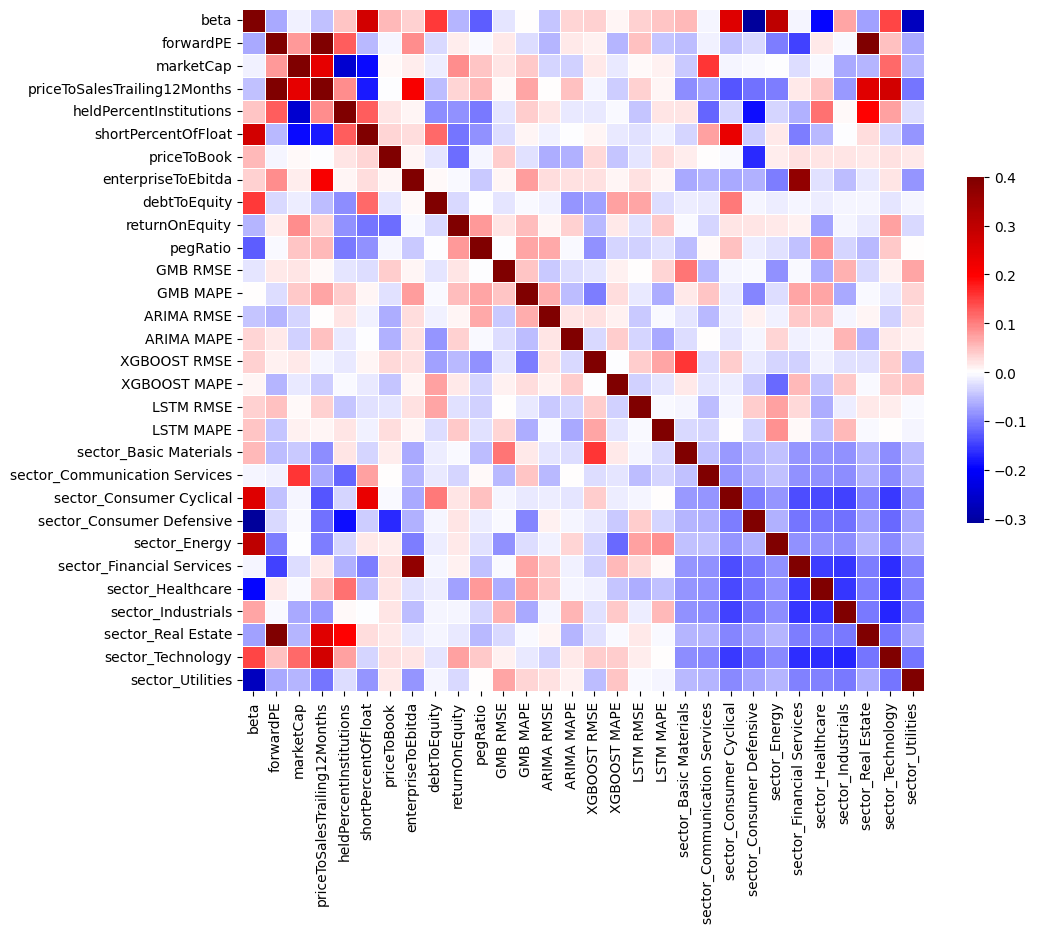

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

corr = desc_encoded.corr()

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr,
            cmap='seismic',
            vmax=.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# for column in desc_encoded.columns:
#     plt.figure(figsize=(2, 1))  # Set figure size
#     sns.distplot(desc_encoded[column].dropna())  # Drop NaN values for visualization
#     plt.title(column)
#     plt.show()

# Data Normalization

In [ ]:
# standardized_data = StandardScaler().fit_transform(desc_encoded)

In [ ]:
standardized_data = MinMaxScaler().fit_transform(desc_encoded)

# U1: PCA

In [ ]:
# pca_all = PCA()

# allComponents = pca_all.fit_transform(standardized_data)
# explained_variance_all = pca_all.explained_variance_ratio_

# # Plotting the explained variances
# components = range(1, len(explained_variance_all)+1)
# plt.figure(figsize=(10,7))
# plt.plot(components, explained_variance_all.cumsum(), marker='o', linestyle='--')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by Components')
# plt.show()

In [ ]:
# n_components = 15
# pca = PCA(n_components=n_components)

# principal_components = pca.fit_transform(standardized_data)

# # Constructing DataFrame of principal components
# principalDf = pd.DataFrame(data=principal_components,
#                            columns=['PC' + str(i) for i in range(1, n_components + 1)])

In [ ]:
# explained_variance = pca.explained_variance_ratio_
# display(explained_variance)
# print("Total explained variance:", sum(explained_variance))

## Elbow Method


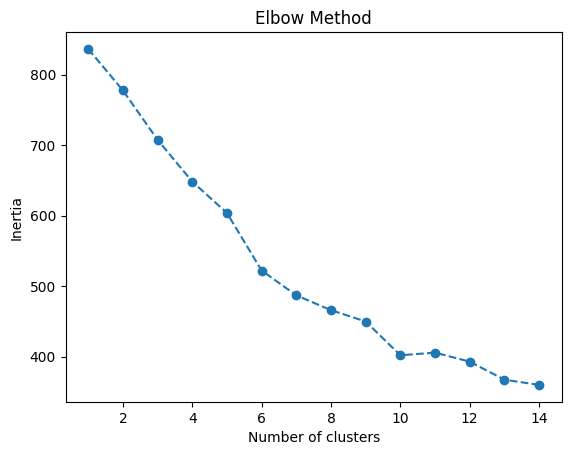

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
range_values = range(1, 15)

for k in range_values:
    kmeans = KMeans(n_clusters=k,n_init='auto')
    kmeans.fit(standardized_data)
    inertia.append(kmeans.inertia_)

plt.plot(range_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
clusters = kmeans.fit_predict(standardized_data)

desc_encoded['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_analysis = desc_encoded.groupby('Cluster').agg({
    'GMB RMSE': 'mean',
    'GMB MAPE': 'mean',
    'ARIMA RMSE': 'mean',
    'ARIMA MAPE': 'mean',
    'XGBOOST RMSE': 'mean',
    'XGBOOST MAPE': 'mean',
    'LSTM RMSE': 'mean',
    'LSTM MAPE': 'mean'
}).reset_index()
print(cluster_analysis)

   Cluster  GMB RMSE  GMB MAPE  ARIMA RMSE  ARIMA MAPE  XGBOOST RMSE  XGBOOST MAPE  LSTM RMSE  LSTM MAPE
0        0  1.506170  2.790667    1.621306    2.619812      1.379047      2.753309   1.554672   2.702577
1        1  1.647430  2.285629    1.512500    2.879542      1.411258      2.697725   1.454834   2.885815
2        2  1.498595  2.464305    1.496016    2.577747      1.555945      2.493642   1.467187   2.695413
3        3  1.755272  2.717425    1.618366    2.723582      1.289712      2.797615   1.470708   2.634287
4        4  1.536430  2.465385    1.453602    2.718128      1.541082      2.675574   1.512195   2.696351
5        5  1.376395  2.782666    1.627704    2.627845      1.437822      2.382204   1.346487   2.510939
6        6  1.497408  2.023514    1.562186    2.614831      1.407022      2.337832   1.601417   2.516056
7        7  1.624697  2.735473    1.386247    2.585079      1.723038      2.538295   1.369977   2.486158
8        8  1.173626  2.350923    1.487849    2.886769 

In [ ]:
cluster_descriptives = desc_encoded.groupby('Cluster').describe()
print(cluster_descriptives)

         beta                                                                       forwardPE                                                                               marketCap                                                                                                   priceToSalesTrailing12Months                                                                        heldPercentInstitutions                                                                     shortPercentOfFloat                                                                  priceToBook                                                                                       enterpriseToEbitda                                                                      debtToEquity                                                                                     returnOnEquity                                                                        pegRatio                                                            GMB RM

<Axes: >

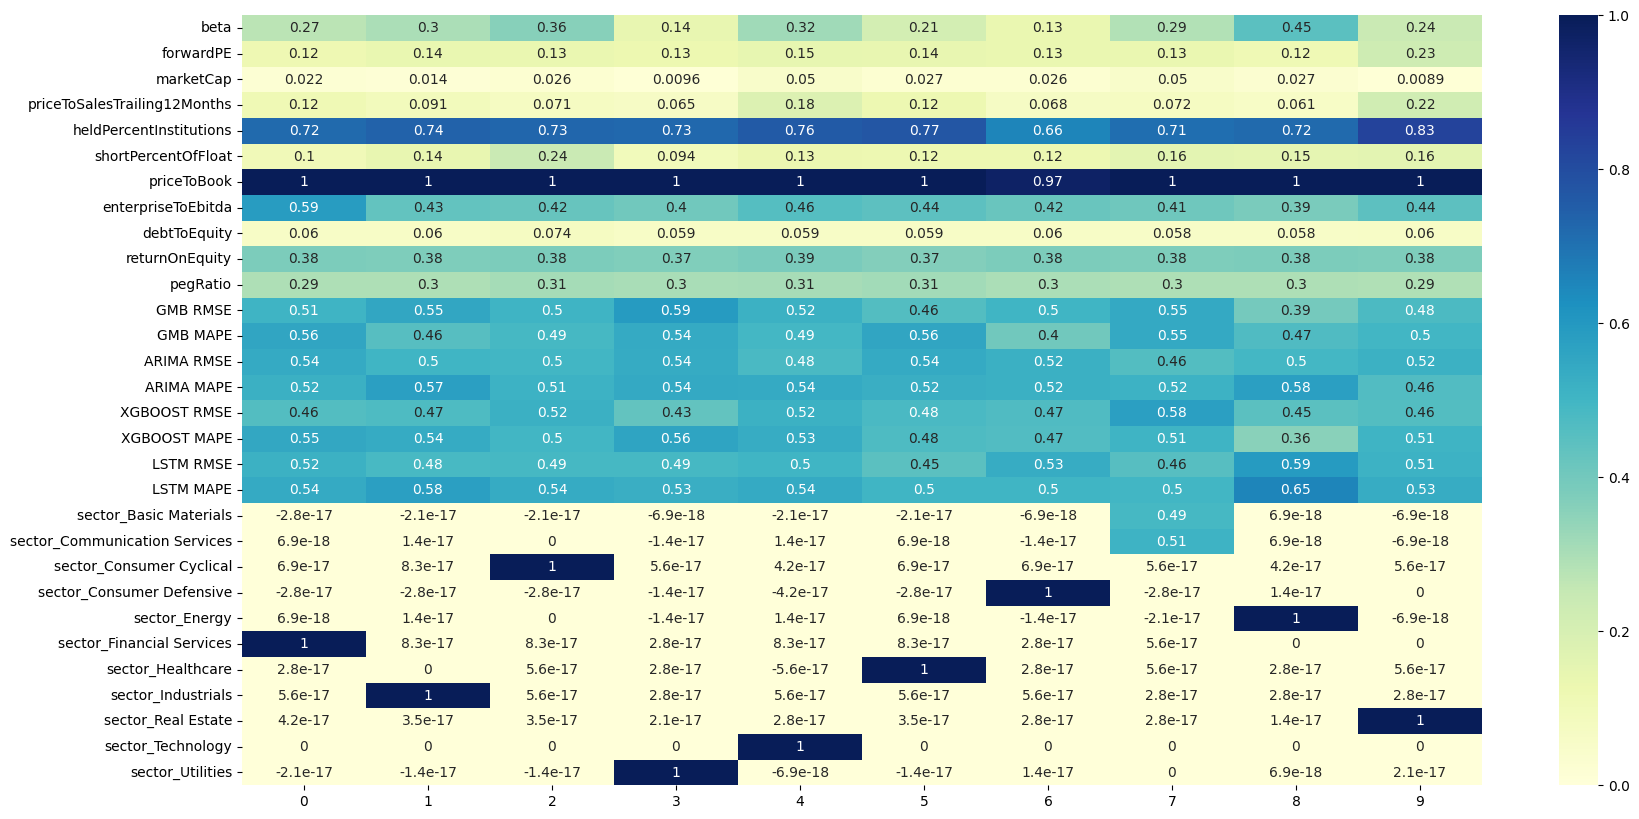

In [ ]:
import seaborn as sns

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=desc_encoded.columns[:-1])
plt.figure(figsize=(20,10))
sns.heatmap(cluster_centers.transpose(), annot=True, cmap="YlGnBu")

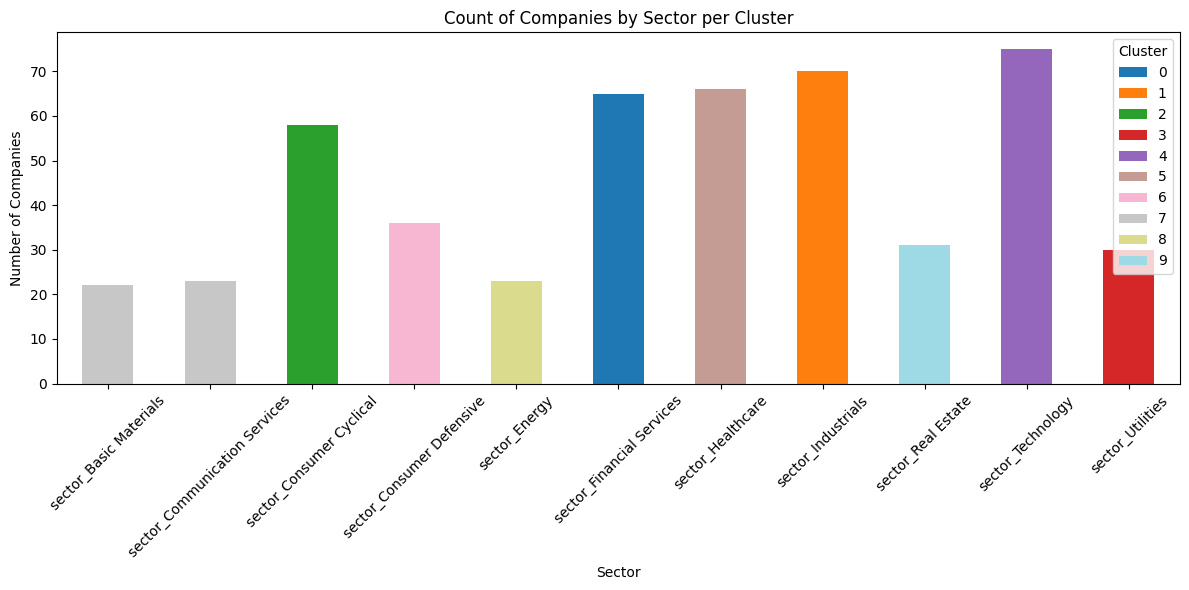

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sectors = desc_encoded.columns[desc_encoded.columns.str.startswith('sector_')]
sector_df = desc_encoded[sectors].join(desc_encoded['Cluster'])

sector_counts = sector_df.groupby('Cluster').sum().transpose()

ax = sector_counts.plot(kind='bar', stacked=True, figsize=(12, 6), cmap="tab20")
plt.title('Count of Companies by Sector per Cluster')
plt.ylabel('Number of Companies')
plt.xlabel('Sector')
plt.xticks(rotation=45)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-254-160081ba335e>:9: RuntimeWarning: divide by zero encountered in log
  centroids_log = np.log(centroids)
<ipython-input-254-160081ba335e>:9: RuntimeWarning: invalid value encountered in log
  centroids_log = np.log(centroids)


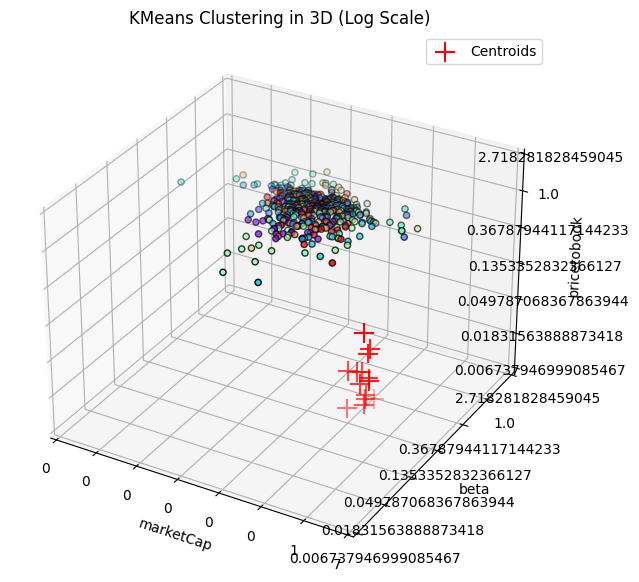

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df['log_marketCap'] = np.log(df['marketCap'])
df['log_beta'] = np.log(df['beta'])
df['log_pricetobook'] = np.log(df['priceToBook'])
centroids_log = np.log(centroids)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['log_marketCap'], df['log_beta'], df['log_pricetobook'], c=labels, cmap='rainbow', marker='o', edgecolors='k')

ax.scatter(centroids_log[:, 0], centroids_log[:, 1], centroids_log[:, 2], s=200, c='red', marker='+', label='Centroids')

ax.set_xlabel('marketCap')
ax.set_ylabel('beta')
ax.set_zlabel('pricetobook')
ax.set_title('KMeans Clustering in 3D (Log Scale)')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(np.exp(ax.get_xticks()).astype(int))
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(np.exp(ax.get_yticks()).astype(float))
ax.set_zticks(ax.get_zticks())
ax.set_zticklabels(np.exp(ax.get_zticks()).astype(float))

ax.legend()
ax.grid(True)

plt.show()